# HDDM analysis of pre- and post-treatment data from adolescent females

[Cleaning](#Cleaning)

In [3]:
import datetime, mmap,os,re, sys, decimal, hddm, glob
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(lmerTest)
%R library(afex)
%R library(ppcor)
%R library(cocor)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['cocor', 'ppcor', 'MASS', 'afex', 'reshape2', 'lmerTest', 'lme4',
       'Matrix', 'lsmeans', 'estimability', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='<U12')

In [4]:
uname = !whoami
uname = uname[0]
path2data = '/Users/victorialawlor/Work/Expts/KIDPRT/Data/'

# Cleaning

In [31]:
def SigDetParse(fname):
    '''Open the file, pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0

    with open(fname) as f:
        f = f.readlines()[17:]
        for line in f:
            #print(line)
            #print(line.split(' '))
            d[ct] = {'trial':line.split(' ')[1],
                     'length':line.split(' ')[2],
                     'rt':line.split(' ')[3], 
                     'key_press':line.split(' ')[4],
                     'correct':line.split(' ')[7],
                     'did_reward':line.split(' ')[9],
                     'reward_due':line.split(' ')[11],
                     'little_due':line.split(' ')[13],
                     'big_due':line.split(' ')[15].strip('\n')}
            ct = ct + 1

    df = pd.DataFrame.from_dict(d,orient='index')
    
    with open(fname) as f:
        for line in f:
            if line.count(':') == 1:
                value = ''
                label = line.split(':')[0]
                label = label.replace(' ', '_')
                value = line.split(':')[1].strip('\n').replace('{','').strip('}')
                df[label] = value
                df['subjectID'] = fname[50:56]
                df['file_session'] = fname[59]
                df['group'] = df.subjectID.str[:3]
                df.loc[df.group == 'DTC', 'group'] = 'CTL'
                df.loc[df.group == 'DTD', 'group'] = 'MDD'
    return df

In [212]:
dfs = []
files = (glob.glob(path2data + '/Raw/DT*/*-.txt'))
for file in files:
    df = SigDetParse(file)
    dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out.head(10)
out.rename(columns={'Subject':'subject', 'Session':'session', 'Short_Key':'short_key', 
                    'Long_Key':'long_key', 'Bias':'bias'}, inplace=True)
out.to_csv(path2data + 'trial_all.csv')

In [213]:
# Checking number of subjects, this lines up with what Randy gave us (38 mdds completed session 1 but DTD510 was 
# later found ineligible)

print(out.groupby('group').subjectID.nunique())
out.subjectID.unique()

group
CTL    43
MDD    37
Name: subjectID, dtype: int64


array(['DTC020', 'DTC021', 'DTC022', 'DTC023', 'DTC024', 'DTC025',
       'DTC026', 'DTC027', 'DTC029', 'DTC030', 'DTC031', 'DTC033',
       'DTC034', 'DTC035', 'DTC036', 'DTC037', 'DTC038', 'DTC039',
       'DTC040', 'DTC041', 'DTC042', 'DTC043', 'DTC044', 'DTC045',
       'DTC047', 'DTC048', 'DTC049', 'DTC050', 'DTC051', 'DTC052',
       'DTC053', 'DTC054', 'DTC056', 'DTC058', 'DTC059', 'DTC060',
       'DTC061', 'DTC062', 'DTC063', 'DTC064', 'DTC065', 'DTC066',
       'DTC067', 'DTD511', 'DTD513', 'DTD516', 'DTD518', 'DTD519',
       'DTD520', 'DTD521', 'DTD525', 'DTD526', 'DTD529', 'DTD530',
       'DTD531', 'DTD532', 'DTD533', 'DTD534', 'DTD535', 'DTD536',
       'DTD537', 'DTD538', 'DTD539', 'DTD540', 'DTD542', 'DTD543',
       'DTD544', 'DTD548', 'DTD549', 'DTD550', 'DTD551', 'DTD552',
       'DTD554', 'DTD556', 'DTD560', 'DTD561', 'DTD562', 'DTD564',
       'DTD565', 'DTD567'], dtype=object)

In [214]:
# splitting up by sessions
session1 = out.loc[out.session == '1']
session2 = out.loc[out.session == '2']

In [215]:
session1.groupby('group').subjectID.nunique()

group
CTL    43
MDD    37
Name: subjectID, dtype: int64

In [216]:
session2.groupby('group').subjectID.nunique()

group
CTL    36
MDD    23
Name: subjectID, dtype: int64

In [217]:
session1.to_csv(path2data + 'trial_session1.csv')
session2.to_csv(path2data + 'trial_session2.csv')

## Session 1

In [218]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'trial_session1.csv')
out['subject'] = out.subjectID
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [219]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1

cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is >/< 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1
data.loc[(data.ln_rt < (data.mean_ln_rt-3*data.ln_std)), 'outlier'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [220]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
cleandata = data[data.outlier == 0]
data['outlier_sub'] = 0
for subject in data.subjectID.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'rich_stim') & (cleandata.block == block)].did_reward.sum()
        nleanrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'lean_stim') & (cleandata.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew
        
        numcorrect = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.sum()
        count = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.count()
        accuracy = (numcorrect/count) 
        
        if ratio < 2.5:
            print ('Subject ' + str(subject) + ' was excluded for having a low reward ratio')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        
        if noutliers > 20:
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif accuracy < (.4):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # low accuracy
            print('Subject ' + str(subject) + ' was excluded for low overall accuracy')
        elif (subject == 'DTD532')|(subject == 'DTC060'): # from sigdet_analyze 
            data.loc[data.subject == subject, 'outlier_sub'] = 1

Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC047 was excluded for having a low reward ratio
Subject DTC047 was excluded for having too few rich rewarded trials
Subject DTC056 was excluded for having a low reward ratio
Subject DTC056 was excluded for having too few rich rewarded trials
Subject DTD531 was excluded for having a low reward ratio
Subject DTD531 was excluded for having more than 20 outlier trials
Subject DTD531 was excluded for having more than 20 outlier trials
Subject DTD534 was excluded for having a low reward ratio
Subject DTD534 was excluded for having too few rich rewarded trials
Subject DTD543 was excluded for having a low reward ratio
Subject DTD543 was excluded for having too few rich rewarded trials
Subject DTD562 was excluded for having a low reward ratio
Subject DTD562 was excluded for having too few rich rewarded trials


In [221]:
data['rwdct'] = 0
cleandata = data[data.outlier == 0]
for subject in data.subjectID.unique():
    reward = cleandata.loc[cleandata.subjectID == subject].did_reward.sum()
    data.loc[data.subjectID == subject, 'rwdct'] = reward 

In [222]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
data.subjectID.nunique() 

71

In [223]:
# how many left in each group?
data.groupby('group').subjectID.nunique()

group
CTL    39
MDD    32
Name: subjectID, dtype: int64

### Calculate RB & Discriminability

In [224]:
def calc_rb(subject, data):
    '''Given a subject and dataframe, returns the discriminability and response bias for the subject'''
    rh_correct = data[(data.subject == subject) & (data.rl_stim == 'rich_stim')].correct.sum() + .5
    rh_incorrect = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.correct == 0)].correct.count() + .5
    ln_correct = data[(data.subject == subject) & (data.rl_stim == 'lean_stim')].correct.sum() + .5
    ln_incorrect = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.correct == 0)].correct.count() + .5
    
    rb = .5 * np.log10((rh_correct * ln_incorrect)/(rh_incorrect * ln_correct))
    disc = .5 * np.log10((rh_correct * ln_correct)/(rh_incorrect * ln_incorrect))
    
    return(rb, disc)

In [225]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [226]:
data.head()

index  little_due  big_due   rt  correct  trial  did_reward key_press  \
0      0           0        0  670        1      1           1         m   
1      1           0        1  748        0      2           0         m   
2      2           0        1  885        0      3           0         c   
3      3           0        1  680        1      4           1         c   
4      4           0        1  869        0      5           0         c   

   reward_due length      ...       outlier mean_ln_rt    ln_std outlier_sub  \
0           1  short      ...             0   6.111284  0.277035           0   
1           1   long      ...             0   6.111284  0.277035           0   
2           0  short      ...             0   6.111284  0.277035           0   
3           1   long      ...             0   6.111284  0.277035           0   
4           0  short      ...             0   6.111284  0.277035           0   

   rwdct RB_adjst_all_total dis_adjst_all_total RB_adjst_all_block  \
0     75          -0.208286            0.668033           0.068238   
1     75          -0.208286            0.668033           0.068238   
2     75          -0.208286            0.668033           0.068238   
3     75          -0.208286            0.668033           0.068238   
4     75          -0.208286            0.668033           0.068238   

  dis_adjst_all_block RB_b2_minus_b1  
0            0.767208      -0.530491  
1            0.767208      -0.530491  
2            0.767208      -0.530491  
3            0.767208      -0.530491  
4            0.767208      -0.530491  

[5 rows x 33 columns]

In [227]:
data.tail()

index  little_due  big_due   rt  correct  trial  did_reward key_press  \
15995  15995           0        1  437        1    196           0         c   
15996  15996           0        1  427        0    197           0         c   
15997  15997           0        1  216        0    198           0         c   
15998  15998           0        1  424        1    199           0         c   
15999  15999           0        1  336        1    200           0         c   

       reward_due length      ...       outlier mean_ln_rt    ln_std  \
15995           0  short      ...             0   6.198628  0.274718   
15996           1   long      ...             0   6.198628  0.274718   
15997           1   long      ...             0   6.198628  0.274718   
15998           0  short      ...             0   6.198628  0.274718   
15999           0  short      ...             0   6.198628  0.274718   

      outlier_sub  rwdct RB_adjst_all_total dis_adjst_all_total  \
15995           0     78           0.246209             0.68925   
15996           0     78           0.246209             0.68925   
15997           0     78           0.246209             0.68925   
15998           0     78           0.246209             0.68925   
15999           0     78           0.246209             0.68925   

      RB_adjst_all_block dis_adjst_all_block RB_b2_minus_b1  
15995           0.119389            0.466877      -0.614822  
15996           0.119389            0.466877      -0.614822  
15997           0.119389            0.466877      -0.614822  
15998           0.119389            0.466877      -0.614822  
15999           0.119389            0.466877      -0.614822  

[5 rows x 33 columns]

In [228]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')

**Check that this matches the data that Paris has run through sigdet_analyze**

In [251]:
# read in data from session 1
data1 = pd.read_csv(path2data + 'session1_trial_clean.csv')
data1_summary = data1.drop_duplicates('subjectID')

In [234]:
# read in Paris's data
parisdata = pd.read_csv(path2data + 'FromParis.csv')
parisdata['subjectID'] = parisdata['subject']
cleanparisdata = parisdata[parisdata.outlier1 == 0]

In [235]:
# same number in each group as we have
cleanparisdata.groupby('group').subject.nunique()

group
0    39
1    33
Name: subject, dtype: int64

**Checking that our RB calculations match up**

In [236]:
data1_summary.RB_adjst_all_total.head()

0     -0.208286
195    0.051116
394   -0.214054
591    0.147041
789    0.021426
Name: RB_adjst_all_total, dtype: float64

In [238]:
# looks good
cleanparisdata.RB_adjst_all1_Total.head()

0   -0.208286
1    0.051116
2   -0.214054
3    0.147041
4    0.021426
Name: RB_adjst_all1_Total, dtype: float64

In [237]:
data1_summary.RB_adjst_all_total.tail()

12999    0.159277
13197   -0.140385
13394    0.084428
13587    0.060256
13787    0.246209
Name: RB_adjst_all_total, dtype: float64

In [239]:
# looks good
cleanparisdata.RB_adjst_all1_Total.tail()

75    0.159277
76   -0.140385
78    0.084428
79    0.060256
80    0.246209
Name: RB_adjst_all1_Total, dtype: float64

**Same for Discriminability**

In [109]:
data1_summary.dis_adjst_all_total.head()

0      0.668033
195    0.724532
394    0.551434
591    0.618448
789    0.715099
Name: dis_adjst_all_total, dtype: float64

In [110]:
# looks good
cleanparisdata.dis_adjst_all1_Total.head()

0    0.668033
1    0.724532
2    0.551434
3    0.618448
4    0.715099
Name: dis_adjst_all1_Total, dtype: float64

In [240]:
data1_summary.dis_adjst_all_total.tail()

12999    0.690756
13197    0.882019
13394    0.375319
13587    0.681379
13787    0.689250
Name: dis_adjst_all_total, dtype: float64

In [241]:
# looks good
cleanparisdata.dis_adjst_all1_Total.tail()

75    0.690756
76    0.882019
78    0.375319
79    0.681379
80    0.689250
Name: dis_adjst_all1_Total, dtype: float64

**Checking reward counts**

In [244]:
data1_summary.rwdct.head()

0      75
195    80
394    77
591    79
789    77
Name: rwdct, dtype: int64

In [246]:
cleanparisdata.rwdct1_Total.head()

0    75
1    80
2    77
3    79
4    77
Name: rwdct1_Total, dtype: int64

In [248]:
data1_summary.rwdct.tail()

12999    80
13197    80
13394    78
13587    79
13787    78
Name: rwdct, dtype: int64

In [247]:
cleanparisdata.rwdct1_Total.tail()

75    80
76    80
78    78
79    79
80    78
Name: rwdct1_Total, dtype: int64

In [252]:
# print subjects paris has that we don't
# excel from Randy says this person was "deemed ineligible after initial"

for sub in cleanparisdata.subject.unique():
    if sub in data.subjectID.unique():
        pass
    else:
        print(sub)

DTD510


In [253]:
# print subjects we have that Paris doesn't

for sub in data1.subjectID.unique():
    if sub in cleanparisdata.subject.unique():
        pass
    else:
        print(sub)

## Session 2


In [254]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'trial_session2.csv')
out['subject'] = out.subjectID
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [255]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data['outlier_firstpass'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1


cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is >/< 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1
data.loc[(data.ln_rt < (data.mean_ln_rt-3*data.ln_std)), 'outlier'] = 1

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier_firstpass'] = 1
data.loc[(data.ln_rt < (data.mean_ln_rt-3*data.ln_std)), 'outlier_firstpass'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [256]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
cleandata = data[data.outlier == 0]
data['outlier_sub'] = 0
for subject in data.subjectID.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'rich_stim') & (cleandata.block == block)].did_reward.sum()
        nleanrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'lean_stim') & (cleandata.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew
        
        numcorrect = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.sum()
        count = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.count()
        accuracy = (numcorrect/count) 
        
        if ratio < 2.5:
            print ('Subject ' + str(subject) + ' was excluded for having a low reward ratio')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        if noutliers > 20:
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif accuracy < (.4):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # low accuracy
            print('Subject ' + str(subject) + ' was excluded for low overall accuracy')

Subject DTC031 was excluded for having a low reward ratio
Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC031 was excluded for having more than 20 outlier trials
Subject DTC038 was excluded for having a low reward ratio
Subject DTC038 was excluded for having too few rich rewarded trials
Subject DTC060 was excluded for having a low reward ratio
Subject DTD531 was excluded for having a low reward ratio
Subject DTD531 was excluded for having too few rich rewarded trials
Subject DTD551 was excluded for having a low reward ratio
Subject DTD551 was excluded for having a low reward ratio
Subject DTD551 was excluded for having more than 20 outlier trials


In [257]:
data['rwdct'] = 0
cleandata = data[data.outlier == 0]
for subject in data.subjectID.unique():
    reward = cleandata.loc[cleandata.subjectID == subject].did_reward.sum()
    data.loc[data.subjectID == subject, 'rwdct'] = reward 

In [259]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
# how many left in each group?
data.groupby('group').subjectID.nunique()

group
CTL    33
MDD    21
Name: subjectID, dtype: int64

In [260]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [261]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')

### Compare our session 2 data to the sigdet_analzye data from paris

In [286]:
data2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')
data2_summary = data2.drop_duplicates('subjectID')
parisdata = pd.read_csv(path2data + 'FromParis.csv')
parisdata['subjectID'] = parisdata['subject']
cleanparisdata2 = parisdata[parisdata.outlier2 == '0']

In [279]:
# how many in each group does Paris have after QC?
cleanparisdata2.groupby('group').subjectID.nunique()

group
0    32
1    21
Name: subjectID, dtype: int64

In [280]:
# how many in each group do we have after QC? 
data2.groupby('group').subjectID.nunique()

group
CTL    33
MDD    21
Name: subjectID, dtype: int64

In [283]:
# subjects paris has that we don't
# we excluded DTC060 for having a reward ratio of < 2.5 (the sigdet_analyze output also shows this)

for sub in cleanparisdata2.subject.unique():
    if sub in data2.subjectID.unique():
        pass
    else:
        print(sub)

DTC060


In [284]:
# subjects we have that Paris doesn't

# What we have is correct: DTC065 was entered as DTC066 on session 2, once they get split into the correct files the 
# data looks fine

for sub in data2.subjectID.unique():
    if sub in cleanparisdata2.subject.unique():
        pass
    else:
        print(sub)

DTC065
DTC066


**Checking that our RB calculations match up**

In [287]:
data2_summary.RB_adjst_all_total.head()

0     -0.005830
190    0.284238
390    0.269444
588    0.068148
786    0.062446
Name: RB_adjst_all_total, dtype: float64

In [292]:
# looks good
cleanparisdata2.RB_adjst_all2_Total.head()

0    -.00583
1    .284238
2    .269444
3    .068148
4    .062446
Name: RB_adjst_all2_Total, dtype: object

In [293]:
data2_summary.RB_adjst_all_total.tail()

9623     0.033384
9823     0.077300
10022    0.058276
10219    0.069129
10418    0.325553
Name: RB_adjst_all_total, dtype: float64

In [295]:
# looks good
cleanparisdata2.RB_adjst_all2_Total.tail()

73    .033384
75      .0773
78    .058276
79    .069129
80    .325553
Name: RB_adjst_all2_Total, dtype: object

**Same for Discriminability**

In [296]:
data2_summary.dis_adjst_all_total.head()

0      0.539679
190    0.878280
390    0.826307
588    0.605268
786    0.426335
Name: dis_adjst_all_total, dtype: float64

In [297]:
# looks good
cleanparisdata2.dis_adjst_all2_Total.head()

0    .539679
1     .87828
2    .826307
3    .605268
4    .426335
Name: dis_adjst_all2_Total, dtype: object

In [298]:
data2_summary.dis_adjst_all_total.tail()

9623     1.129134
9823     0.813825
10022    0.615140
10219    0.742545
10418    0.307642
Name: dis_adjst_all_total, dtype: float64

In [300]:
# looks good
cleanparisdata2.dis_adjst_all2_Total.tail()

73    1.129134
75     .813825
78      .61514
79     .742545
80     .307642
Name: dis_adjst_all2_Total, dtype: object

**Checking reward counts**

In [302]:
data2_summary.rwdct.head()

0      79
190    80
390    80
588    80
786    78
Name: rwdct, dtype: int64

In [301]:
cleanparisdata2.rwdct2_Total.head()

0    79
1    80
2    80
3    80
4    78
Name: rwdct2_Total, dtype: object

# Self Report Cleaning & Merging

**T1**

In [316]:
self_rep = pd.read_csv(path2data + 'self_report.csv')

In [317]:
%cd {'/Users/victorialawlor/Work/Code/'}
import misc
%cd {'/Users/victorialawlor/Work/Expts/KIDPRT/Analysis/'}
from misc import processBDI

/Users/victorialawlor/Work/Code
/Users/victorialawlor/Work/Expts/KIDPRT/Analysis


In [318]:
self_rep = processBDI(self_rep)
self_rep = self_rep[['Subject_ID','Age','Race','Hispanic','BDI1_total', 'BDI2_total', 'shaps1_total', 'shaps2_total', 'pss1_total',\
                    'Medication', 'Medication_Class','pss2_total','masc1_total','masc2_total']]
self_rep.to_csv(path2data + 'self_report_clean.csv')

In [319]:
data1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_clean.csv')
data1_standard = data1.drop_duplicates('subjectID')

In [320]:
self_rep['subjectID'] = self_rep['Subject_ID']
self_rep = self_rep.merge(data1_standard[['subjectID','group']], on = 'subjectID')

Remove controls with a BDI > 14 at T1 or T2

In [321]:
outlier_ctls = []
for subject in self_rep.subjectID.unique():
    group = self_rep.loc[self_rep.subjectID == subject].group.unique()[0]
    bdi1 = self_rep.loc[self_rep.subjectID == subject].BDI1_total.mean()
    bdi2 = self_rep.loc[self_rep.subjectID == subject].BDI2_total.mean()
    
    if group == 'CTL':
        if bdi1 >= 14:
            print(str(subject)+ ' was excluded for a BDI at T1 of ' + str(bdi1))
            outlier_ctls.append(subject) 
        if bdi2 >= 14:
            print(str(subject)+ ' was excluded for a BDI at T2 of ' + str(bdi2))
            outlier_ctls.append(subject)
    else:
        pass

DTC023 was excluded for a BDI at T2 of 26.0
DTC025 was excluded for a BDI at T2 of 20.0
DTC033 was excluded for a BDI at T2 of 15.0


In [322]:
outlier_ctls

['DTC023', 'DTC025', 'DTC033']

In [323]:
# remove these guys
del self_rep['group']
data1 = data1.loc[~data1.subjectID.isin(outlier_ctls)].merge(self_rep, on='subjectID')
data1_standard = data1.drop_duplicates('subjectID')

In [325]:
# print the final T1 sample size
data1.groupby('group').subjectID.nunique()

group
CTL    36
MDD    32
Name: subjectID, dtype: int64

In [326]:
data1.to_csv(path2data + 'session1_trial_final.csv')
data1_standard.to_csv(path2data + 'session1_summary_final.csv')

**T2**

In [327]:
self_rep = pd.read_csv(path2data + 'self_report_clean.csv')

In [328]:
data2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_clean.csv')
data2_standard = data2.drop_duplicates('subjectID')

In [329]:
self_rep['subjectID'] = self_rep['Subject_ID']
self_rep = self_rep.merge(data2_standard[['subjectID','group']], on = 'subjectID')

In [330]:
# remove the high BDI controls
del self_rep['group']
data2 = data2.loc[~data2.subjectID.isin(outlier_ctls)].merge(self_rep, on='subjectID')
data2_standard = data2.drop_duplicates('subjectID')

In [331]:
# print the final T2 sample size
data2.groupby('group').subjectID.nunique()

group
CTL    30
MDD    21
Name: subjectID, dtype: int64

In [332]:
data2.to_csv(path2data + 'session2_trial_final.csv')
data2_standard.to_csv(path2data + 'session2_summary_final.csv')

## Participant Characteristics

In [333]:
%cd {'/Users/victorialawlor/Work/Code/'}
import misc
%cd {'/Users/victorialawlor/Work/Expts/KIDPRT/Analysis/'}
from misc import ttest_2s

/Users/victorialawlor/Work/Code
/Users/victorialawlor/Work/Expts/KIDPRT/Analysis


In [334]:
data1 = pd.read_csv(path2data + 'session1_trial_final.csv')
data1_standard = pd.read_csv(path2data + 'session1_summary_final.csv')

Age

In [335]:
print('MDD:')
print(data1_standard[(data1_standard.group == 'MDD')]['Age'].describe())
print('CTL:')
print(data1_standard[(data1_standard.group == 'CTL')]['Age'].describe())

print('\nttest:')
ttest_2s(data1_standard[(data1_standard.group == 'CTL')]['Age'],\
        data1_standard[(data1_standard.group == 'MDD')]['Age'])

MDD:
count    32.00000
mean     16.03125
std       1.53422
min      13.00000
25%      15.00000
50%      16.00000
75%      17.00000
max      18.00000
Name: Age, dtype: float64
CTL:
count    36.000000
mean     15.194444
std       1.600347
min      13.000000
25%      14.000000
50%      15.500000
75%      17.000000
max      18.000000
Name: Age, dtype: float64

ttest:
t(66) = -2.19, p = 0.032, g = -0.533


(-2.1943092501454942, 0.031738079723106195, -0.53312132000051826)

BDI

In [336]:
print('MDD:')
print(data1_standard[(data1_standard.group == 'MDD')]['BDI1_total'].describe())
print('CTL:')
print(data1_standard[(data1_standard.group == 'CTL')]['BDI1_total'].describe())

print('\nttest:')
ttest_2s(data1_standard[(data1_standard.group == 'CTL')]['BDI1_total'].dropna(),\
        data1_standard[(data1_standard.group == 'MDD')]['BDI1_total'].dropna())

MDD:
count    30.000000
mean     33.966667
std      12.344155
min      15.000000
25%      25.000000
50%      32.000000
75%      42.750000
max      59.000000
Name: BDI1_total, dtype: float64
CTL:
count    34.000000
mean      1.617647
std       2.202130
min       0.000000
25%       0.000000
50%       1.000000
75%       2.750000
max       9.000000
Name: BDI1_total, dtype: float64

ttest:
t(62) = -15.03, p = 0.000, g = -3.764


(-15.027333716177083, 2.4332396615286499e-22, -3.7641925613251841)

PSS

In [337]:
data1_standard['pss1_total'] = data1_standard.pss1_total.apply(pd.to_numeric, errors='coerce')

In [338]:
print('MDD:')
print(data1_standard[(data1_standard.group == 'MDD')]['pss1_total'].describe())
print('CTL:')
print(data1_standard[(data1_standard.group == 'CTL')]['pss1_total'].describe())

print('\nttest:')
ttest_2s(data1_standard[(data1_standard.group == 'CTL')]['pss1_total'].dropna(),\
        data1_standard[(data1_standard.group == 'MDD')]['pss1_total'].dropna())

MDD:
count    29.000000
mean     34.137931
std       6.833343
min      17.000000
25%      29.000000
50%      34.000000
75%      39.000000
max      47.000000
Name: pss1_total, dtype: float64
CTL:
count    34.000000
mean     14.264706
std       5.451210
min       3.000000
25%      12.000000
50%      14.000000
75%      19.000000
max      26.000000
Name: pss1_total, dtype: float64

ttest:
t(61) = -12.84, p = 0.000, g = -3.245


(-12.837107752246819, 5.4683127303548339e-19, -3.2448827138228959)

SHAPS

In [339]:
print('MDD:')
print(data1_standard[(data1_standard.group == 'MDD')]['shaps1_total'].describe())
print('CTL:')
print(data1_standard[(data1_standard.group == 'CTL')]['shaps1_total'].describe())

print('\nttest:')
ttest_2s(data1_standard[(data1_standard.group == 'CTL')]['shaps1_total'].dropna(),\
        data1_standard[(data1_standard.group == 'MDD')]['shaps1_total'].dropna())

MDD:
count    32.000000
mean      4.406250
std       3.509061
min       0.000000
25%       2.000000
50%       3.500000
75%       6.000000
max      12.000000
Name: shaps1_total, dtype: float64
CTL:
count    36.000000
mean      0.111111
std       0.318728
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: shaps1_total, dtype: float64

ttest:
t(66) = -7.32, p = 0.000, g = -1.778


(-7.3170486006264923, 4.4105862185022656e-10, -1.7777232667707581)

MASC total

In [340]:
print('MDD:')
print(data1_standard[(data1_standard.group == 'MDD')]['masc1_total'].describe())
print('CTL:')
print(data1_standard[(data1_standard.group == 'CTL')]['masc1_total'].describe())

print('\nttest:')
ttest_2s(data1_standard[(data1_standard.group == 'CTL')]['masc1_total'].dropna(),\
        data1_standard[(data1_standard.group == 'MDD')]['masc1_total'].dropna())

MDD:
count    32.000000
mean     63.656250
std      18.904871
min      11.000000
25%      51.750000
50%      67.000000
75%      75.500000
max      93.000000
Name: masc1_total, dtype: float64
CTL:
count    36.000000
mean     38.611111
std      14.809799
min      14.000000
25%      29.750000
50%      38.000000
75%      43.250000
max      85.000000
Name: masc1_total, dtype: float64

ttest:
t(66) = -6.12, p = 0.000, g = -1.486


(-6.1150455496204055, 5.8528245131946784e-08, -1.4856890181093509)

### Standard Analysis

Both groups developed a response bias

In [342]:
# final numbers after removing the three high BDI controls
data1.groupby('group').subjectID.nunique()

group
CTL    36
MDD    32
Name: subjectID, dtype: int64

In [343]:
data1_mdd = data1_standard.loc[data1_standard.group == 'MDD']

%Rpush data1_mdd
%R rb.test <- t.test(data1_mdd$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data1_mdd$RB_adjst_all_block
t = 1.7718, df = 31, p-value = 0.04313
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.00292449        Inf
sample estimates:
mean of x 
0.0679653 



In [344]:
data1_ctl = data1_standard.loc[data1_standard.group == 'CTL']

%Rpush data1_ctl
%R rb.test <- t.test(data1_ctl$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data1_ctl$RB_adjst_all_block
t = 2.3375, df = 35, p-value = 0.01263
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.02656748        Inf
sample estimates:
 mean of x 
0.09584535 



No significant effects of group or block on RB

Anova Table (Type 3 tests)

Response: RB_adjst_all_block
       Effect    df  MSE      F  pes p.value
1       group 1, 66 0.09   0.19 .003     .67
2       block 1, 66 0.02   0.10 .002     .75
3 group:block 1, 66 0.02 3.65 +  .05     .06

Sphericity correction method: GG 


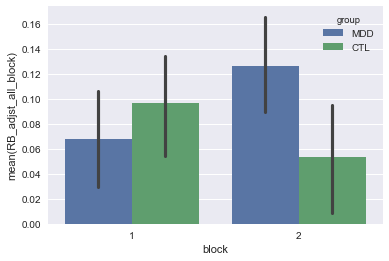

In [345]:
total_rb_plot = sns.barplot(y='RB_adjst_all_block', x = 'block', hue = 'group',hue_order = ['MDD','CTL'], data = data1, units='subjectID', ci=68)

%Rpush data1
%R rb.aov <- aov_ez("subjectID", dv = "RB_adjst_all_block", \
                                 data = data1, within = "block", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

In [346]:
# print means
data1.groupby(['group','block']).RB_adjst_all_block.mean()

group  block
CTL    1        0.096650
       2        0.053353
MDD    1        0.068315
       2        0.126067
Name: RB_adjst_all_block, dtype: float64

Block 2 - block1 

Anova Table (Type 3 tests)

Response: RB_b2_minus_b1
  Effect    df  MSE      F pes p.value
1  group 1, 66 0.05 3.65 + .05     .06


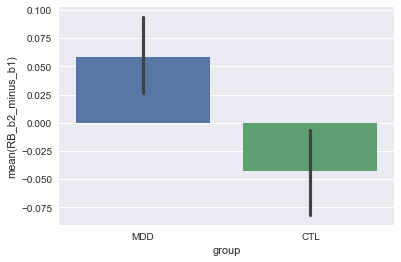

In [347]:
total_rb_plot = sns.barplot(y='RB_b2_minus_b1', x = 'group', x_order = ['MDD','CTL'], \
                            data = data1, units='subjectID', ci=68)
%Rpush data1
%R rb.aov <- aov_ez("subjectID", dv = "RB_b2_minus_b1", \
                                 data = data1, between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Worse discriminability in the second block, no effect of group

Anova Table (Type 3 tests)

Response: dis_adjst_all_block
       Effect    df  MSE       F   pes p.value
1       group 1, 66 0.08    0.06 .0009     .81
2       block 1, 66 0.02 7.69 **   .10    .007
3 group:block 1, 66 0.02    1.04   .02     .31

Sphericity correction method: GG 


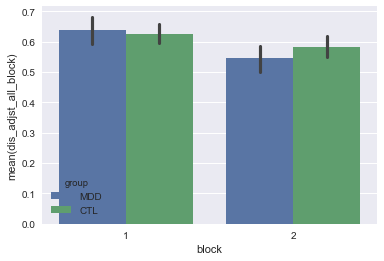

In [348]:
plot = sns.barplot(y='dis_adjst_all_block', x = 'block', 
                                   data = data1, hue = 'group',ci=68, hue_order = ['MDD','CTL'],units= 'subjectID')
%Rpush data1
%R discriminability.aov <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data1, within = 'block',\
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.aov)

In [349]:
# Adding RB as a covariate, block is no longer significant

%Rpush data1
%R discriminability.ancova <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data1, within = 'block',covariate='RB_adjst_all_total',\
                                 between = "group",factorize=FALSE,anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.ancova)

Anova Table (Type 3 tests)

Response: dis_adjst_all_block
                    Effect    df  MSE      F   pes p.value
1                    group 1, 65 0.08   0.04 .0007     .83
2       RB_adjst_all_total 1, 65 0.08   0.54  .008     .46
3                    block 1, 65 0.02 3.39 +   .05     .07
4              group:block 1, 65 0.02   0.92   .01     .34
5 RB_adjst_all_total:block 1, 65 0.02 5.32 *   .08     .02

Sphericity correction method: GG 


**No relationship between RB & disc**


	Pearson's product-moment correlation

data:  data1_standard$dis_adjst_all_total and data1_standard$RB_adjst_all_total
t = -0.76419, df = 66, p-value = 0.4475
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3248242  0.1480795
sample estimates:
        cor 
-0.09365211 



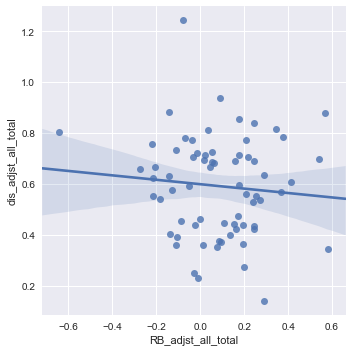

In [350]:
sns.lmplot(x="RB_adjst_all_total", y="dis_adjst_all_total", data=data1_standard, units = 'subjectID')

%R disc_rb.cor <- cor.test(data1_standard$dis_adjst_all_total,data1_standard$RB_adjst_all_total,method='pearson')
%R print(disc_rb.cor)

RT

Anova Table (Type 3 tests)

Response: ln_rt
       Effect    df  MSE      F  pes p.value
1       group 1, 66 0.08   1.01  .02     .32
2       block 1, 66 0.00 3.72 +  .05     .06
3 group:block 1, 66 0.00   0.35 .005     .56

Sphericity correction method: GG 


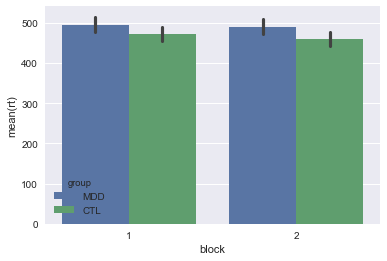

In [351]:
rt_plot = sns.barplot(y='rt', x = 'block', hue = 'group', hue_order = ['MDD','CTL'],data=data1,  \
                      ci=68, units = 'subjectID')

%Rpush data1
%R rt.aov <- aov_ez("subjectID", dv = "ln_rt", \
                                 data = data1, within = 'block',\
                                 between = 'group',anova_table=list(correction="GG", es = "pes"))
%R print (rt.aov)

#### Rewards Recieved

Discriminability, but not RB, is not associated with cumulative reward. These correlations don't differ.


	Pearson's product-moment correlation

data:  data1_standard$rwdct and data1_standard$RB_adjst_all_total
t = 1.7049, df = 66, p-value = 0.09292
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03474351  0.42308995
sample estimates:
      cor 
0.2053829 



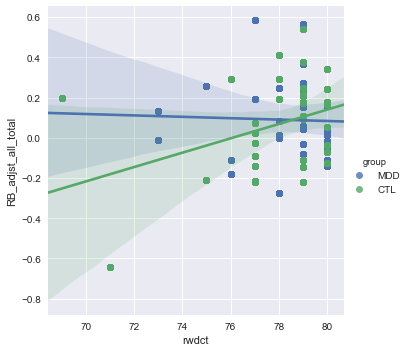

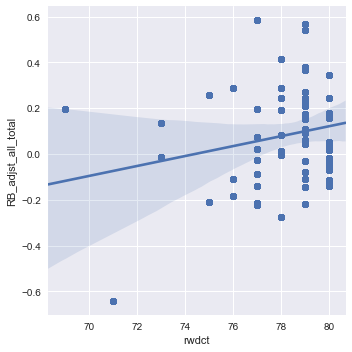

In [355]:
sns.lmplot(x="rwdct", y="RB_adjst_all_total", data=data1, hue = 'group',hue_order = ['MDD','CTL'],units = 'subjectID')
sns.lmplot(x="rwdct", y="RB_adjst_all_total", data=data1, units = 'subjectID')

%Rpush data1_standard
%R rb_rwdct <- cor.test(data1_standard$rwdct,data1_standard$RB_adjst_all_total,method="pearson")
%R print (rb_rwdct)


	Pearson's product-moment correlation

data:  data1_standard$rwdct and data1_standard$dis_adjst_all_total
t = 3.7028, df = 66, p-value = 0.0004375
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1956540 0.5943833
sample estimates:
      cor 
0.4147323 



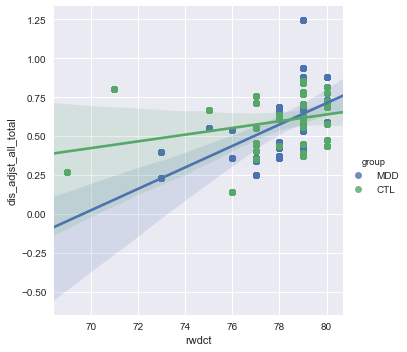

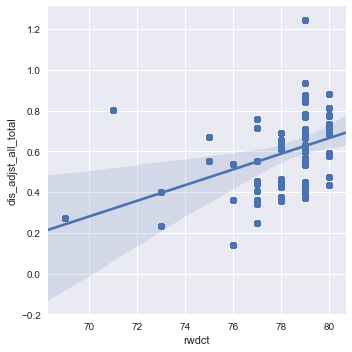

In [356]:
sns.lmplot(x="rwdct", y="dis_adjst_all_total", data=data1, hue = 'group', hue_order = ['MDD','CTL'], units = 'subjectID');
sns.lmplot(x="rwdct", y="dis_adjst_all_total", data=data1, units = 'subjectID');


%Rpush data1_standard
%R disc_rwdct <- cor.test(data1_standard$rwdct,data1_standard$dis_adjst_all_total,method="pearson")
%R print (disc_rwdct)

In [358]:
# these correlations don't differ
%Rpush data1_standard
%R compare_corr <- cocor (~ rwdct + dis_adjst_all_total | rwdct + RB_adjst_all_total,\
                          data1_standard)
%R print(compare_corr)


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk (rwdct, dis_adjst_all_total) = 0.4147 and r.jh (rwdct, RB_adjst_all_total) = 0.2054
Difference: r.jk - r.jh = 0.2093
Related correlation: r.kh = -0.0937
Data: data1_standard: j = rwdct, k = dis_adjst_all_total, h = RB_adjst_all_total
Group size: n = 68
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = 1.2809, p-value = 0.2002
  Null hypothesis retained

hotelling1940: Hotelling's t (1940)
  t = 1.3024, df = 65, p-value = 0.1974
  Null hypothesis retained

williams1959: Williams' t (1959)
  t = 1.2531, df = 65, p-value = 0.2146
  Null hypothesis retained

olkin1967: Olkin's z (1967)
  z = 1.2809, p-value = 0.2002
  Null hypothesis retained

dunn1969: Dunn and Clark's z (1969)
  z = 1.2469, p-value = 0.2124
  Null hypothesis retained

hendrickson1970: Hendrickson, Stanl

**Regression predicting cumulative reward with group*time, RB, and discriminability**

In [415]:
data1_summary = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_summary_final.csv')
data2_summary = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_summary_final.csv')
both_summary = pd.concat([data1_summary, data2_summary])

In [419]:
both_summary.head()

Age  BDI1_total  BDI2_total  Hispanic  Medication  Medication_Class  \
0   15         2.0         1.0         0           0                 0   
1   17         0.0         0.0         0           0                 0   
2   15         1.0        12.0         0           0                 0   
3   17         4.0         4.0         0           0                 0   
4   17         3.0         7.0         0           0                 0   

   RB_adjst_all_block  RB_adjst_all_total  RB_b2_minus_b1  Race  ...    \
0            0.068238           -0.208286       -0.530491     4  ...     
1            0.138662            0.051116       -0.162814     4  ...     
2           -0.259358           -0.214054        0.103844     4  ...     
3            0.046591            0.021426       -0.046591     4  ...     
4           -0.516265           -0.640933       -0.207461     4  ...     

     rl_stim    rt  rwdct  session  shaps1_total shaps2_total  short_key  \
0  lean_stim   670     75        1             1            0          m   
1  rich_stim  1172     80        1             0            0          c   
2  rich_stim   920     77        1             0            0          m   
3  lean_stim   575     77        1             0            0          m   
4  lean_stim   515     71        1             0            0          c   

   subject  subjectID  trial  
0   DTC020     DTC020      1  
1   DTC021     DTC021      1  
2   DTC022     DTC022      1  
3   DTC024     DTC024      1  
4   DTC026     DTC026      1  

[5 rows x 52 columns]

In [420]:
both_summary.tail()

Age  BDI1_total  BDI2_total  Hispanic  Medication  Medication_Class  \
46   17        31.0        13.0         0           0                 0   
47   14        53.0        53.0         0           1                 1   
48   14        59.0         0.0         0           1                 2   
49   15        48.0        36.0         0           0                 0   
50   18        50.0        52.0         1           0                 0   

    RB_adjst_all_block  RB_adjst_all_total  RB_b2_minus_b1  Race  ...    \
46            0.000000            0.033384        0.048296     4  ...     
47           -0.077110            0.077300        0.296527     5  ...     
48            0.125084            0.058276       -0.119516     4  ...     
49            0.125406            0.069129       -0.092948     4  ...     
50            0.260525            0.325553        0.122068     5  ...     

      rl_stim   rt  rwdct  session  shaps1_total shaps2_total  short_key  \
46  rich_stim  441     80        2             5            0          c   
47  rich_stim  740     80        2             3           10          m   
48  lean_stim  586     80        2            12            0          c   
49  lean_stim  439     80        2            11            5          c   
50  rich_stim  688     76        2            10           10          m   

    subject  subjectID  trial  
46   DTD554     DTD554      1  
47   DTD560     DTD560      1  
48   DTD564     DTD564      2  
49   DTD565     DTD565      1  
50   DTD567     DTD567      1  

[5 rows x 52 columns]

In [421]:
%Rpush both_summary

%R rwdct.lm <- lm(rwdct ~ group*session + RB_adjst_all_total + dis_adjst_all_total,data=both_summary)
%R print(summary(rwdct.lm))


Call:
lm(formula = rwdct ~ group * session + RB_adjst_all_total + dis_adjst_all_total, 
    data = both_summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6545 -0.8203  0.4048  1.2694  2.5163 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          74.3772     0.8764  84.864  < 2e-16 ***
groupMDD              0.7892     1.0478   0.753  0.45290    
session               0.3367     0.4597   0.733  0.46535    
RB_adjst_all_total    2.4352     0.8556   2.846  0.00526 ** 
dis_adjst_all_total   5.3430     0.8578   6.228 8.29e-09 ***
groupMDD:session     -0.6953     0.6966  -0.998  0.32039    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.86 on 113 degrees of freedom
Multiple R-squared:  0.2869,	Adjusted R-squared:  0.2554 
F-statistic: 9.093 on 5 and 113 DF,  p-value: 2.728e-07



## RT Distributions

In [359]:
data1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')

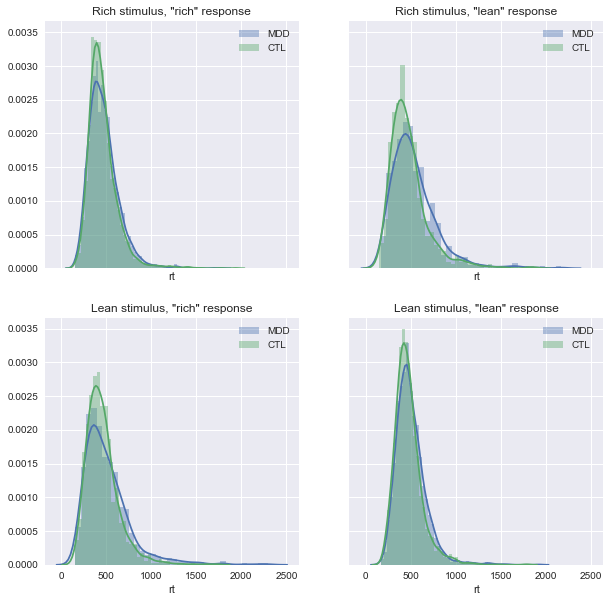

In [360]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))

# Rich stimulus
sns.distplot(data1[(data1.group == 'MDD') & (data1.rl_stim == 'rich_stim') & (data1.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax1,label='MDD')
sns.distplot(data1[(data1.group == 'CTL') & (data1.rl_stim == 'rich_stim') & (data1.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax1,label='CTL')
ax1.set_title('Rich stimulus, "rich" response')
ax1.legend()

sns.distplot(data1[(data1.group == 'MDD') & (data1.rl_stim == 'rich_stim') & (data1.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax2,label='MDD')
sns.distplot(data1[(data1.group == 'CTL') & (data1.rl_stim == 'rich_stim') & (data1.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax2,label='CTL')
ax2.set_title('Rich stimulus, "lean" response')
ax2.legend()

# Lean stimulus
sns.distplot(data1[(data1.group == 'MDD') & (data1.rl_stim == 'lean_stim') & (data1.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax3,label='MDD')
sns.distplot(data1[(data1.group == 'CTL') & (data1.rl_stim == 'lean_stim') & (data1.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax3,label='CTL')
ax3.set_title('Lean stimulus, "rich" response')
ax3.legend()

sns.distplot(data1[(data1.group == 'MDD') & (data1.rl_stim == 'lean_stim') & (data1.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax4,label='MDD')
sns.distplot(data1[(data1.group == 'CTL') & (data1.rl_stim == 'lean_stim') & (data1.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax4,label='CTL')
ax4.set_title('Lean stimulus, "lean" response')
ax4.legend()

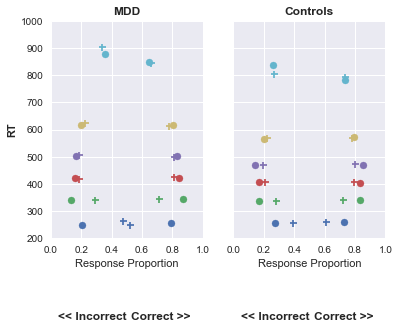

In [361]:
pal = sns.color_palette()
ct = 0

clean=data1
f,(ax1,ax2) = plt.subplots(1,2,sharex=False,sharey=True)
for pair in [(ax1,'MDD'),(ax2,'CTL')]:
    axis, grp = pair
    
    if grp == 'CTL':
        grp_name = 'Controls'
    else:
        grp_name = 'MDD'

    old_val = 0.005
    for new_val in [0.1,0.3,0.5,0.7,0.9,0.995]:
        d_clean = clean[clean.group == grp]
        df = d_clean[(d_clean.group == grp) & (d_clean.rt > d_clean.rt.quantile(q=old_val)) &
                                                 (d_clean.rt < d_clean.rt.quantile(q=new_val))]
        pct_corr_rich = df[df.rl_stim=='rich_stim'].correct.mean()
        pct_err_rich = 1 - pct_corr_rich
        pct_corr_lean = df[df.rl_stim=='lean_stim'].correct.mean()
        pct_err_lean = 1 - pct_corr_lean
        
        corr_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 0)]['rt'].mean()
        corr_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 0)]['rt'].mean()
        
        axis.scatter(x=(pct_corr_rich,pct_err_rich),
                     y=(corr_rt_rich,err_rt_rich),marker='o',c=pal[ct])
        axis.scatter(x=(pct_corr_lean,pct_err_lean),
                     y=(corr_rt_lean,err_rt_lean),marker='+',c=pal[ct])

        old_val = new_val

        if ct < 5:
            ct = ct + 1
        else:
            ct = 0
        
    axis.set_ylabel('RT',weight='bold')
    axis.set_xlabel('Response Proportion')
    axis.set_xlim(0,1)
    axis.set_ylim(200,1000)
    axis.text(x=0.53,y=-100,s='Correct >>',fontsize=12,weight='bold')
    axis.text(x=0.05,y=-100,s='<< Incorrect',fontsize=12,weight='bold')
    axis.set_title(grp_name,weight='bold')
    
ax2.set_ylabel('')

In [409]:
# Anova on accuracy for fast and slow responses—bringing this in from
# your embarc notebook

# Matching the q-q plots, main effect of stimulus for fast but not slow responses. No effects of group.

#%R detach(package:lmerTest)

# Fast RTs: strong main effects of Stimulus
fast = data1[data1.rt <= data1.rt.quantile(q=0.3)]
print('For the "fast" data, the min RT = ' + str(np.min(fast.rt)) + ', the max RT = ' + str(np.max(fast.rt)) + '.')

%Rpush fast

%R fast.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=fast,\
                     anova_table=list(correction='GG',es='pes'))
%R print(fast.aov)


# Fast: main effect of Stimulus, rich > lean
%R fast_stim.lsm <- lsmeans(fast.aov,~rl_stim)
%R print(fast_stim.lsm)

# No effect of stimulus 
slow = data1[data1.rt > data1.rt.quantile(q=0.3)]
print('For the "slow" data, the min RT = ' + str(np.min(slow.rt)) + ', the max RT = ' + str(np.max(slow.rt)) + '.')

%Rpush slow
%R slow.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=slow,\
                     anova_table=list(correction='GG',es='pes'))
%R print(slow.aov)


For the "fast" data, the min RT = 150, the max RT = 380.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE         F  pes p.value
1         group 1, 62 0.03      0.17 .003     .68
2       rl_stim 1, 62 0.06 13.17 ***  .18   .0006
3 group:rl_stim 1, 62 0.06      0.85  .01     .36

Sphericity correction method: GG 


 rl_stim      lsmean         SE     df  lower.CL  upper.CL
 lean_stim 0.6508440 0.02649212 107.97 0.5983319 0.7033562
 rich_stim 0.8111179 0.02649212 107.97 0.7586058 0.8636300

Results are averaged over the levels of: group 
Confidence level used: 0.95 


For the "slow" data, the min RT = 381, the max RT = 2300.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE    F   pes p.value
1         group 1, 66 0.01 0.02 .0004     .88
2       rl_stim 1, 66 0.01 1.36   .02     .25
3 group:rl_stim 1, 66 0.01 0.20  .003     .66

Sphericity correction method: GG 


 rl_stim      lsmean         SE     df  lower.CL  upper.CL
 lean_stim 0.7803060 0.01234097 131.95 0.7558942 0.8047177
 rich_stim 0.8008773 0.01234097 131.95 0.7764656 0.8252891

Results are averaged over the levels of: group 
Confidence level used: 0.95 


### HDDM

In [362]:
# getting the data HDDM compatible
data = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')
data.loc[data.rl_resp == 'rich_resp', 'response'] = 1
data.loc[data.rl_resp == 'lean_resp', 'response'] = 0
data.loc[data.rl_stim == 'rich_stim', 'stim'] = 1
data.loc[data.rl_stim == 'lean_stim', 'stim'] = 0
data.rename(columns={'subjectID': 'subj_idx'}, inplace=True)
data['rt'] = data.rt/1000
data.to_csv(path2data + 'session1_hddm_ready.csv')

In [374]:
data1_for_ddm = hddm.load_csv(path2data + 'session1_hddm_ready.csv')

Model with group included

In [151]:
session1_model = hddm.HDDMStimCoding(data1_for_ddm, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
session1_model.find_starting_values()
session1_model.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1758.5 sec

In [152]:
session1_model.dic_info

{'DIC': -1546.8003099015916,
 'deviance': -1791.9999605403357,
 'pD': 245.19965063874406}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting v_std
Plotting t(CTL)
Plotting t(MDD)
Plotting t_std
Plotting z(CTL)
Plotting z(MDD)
Plotting z_std


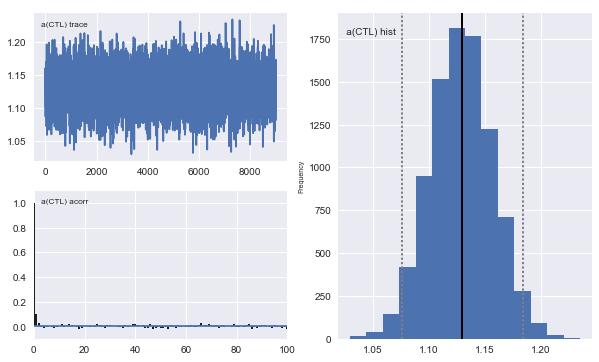

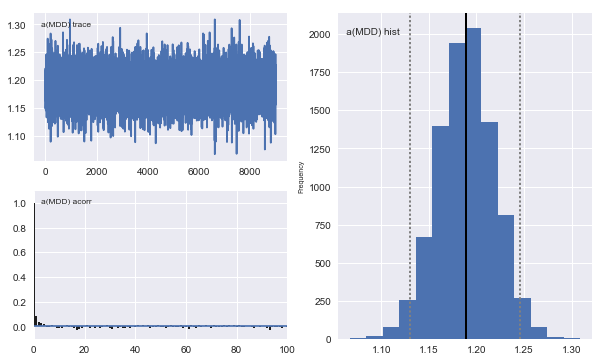

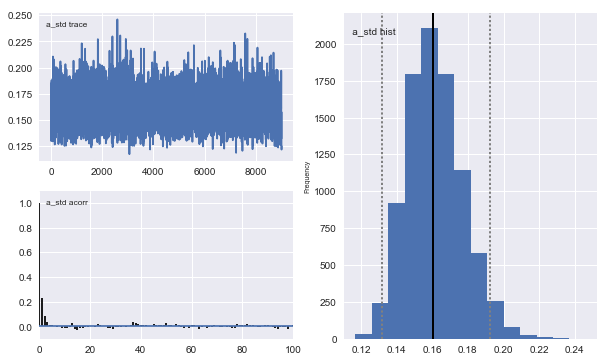

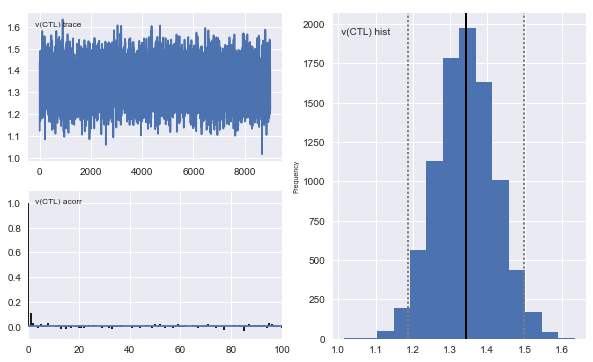

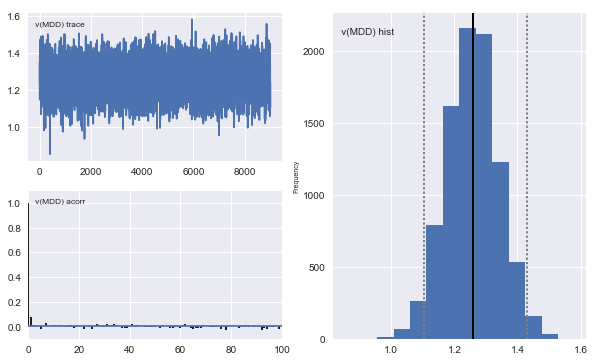

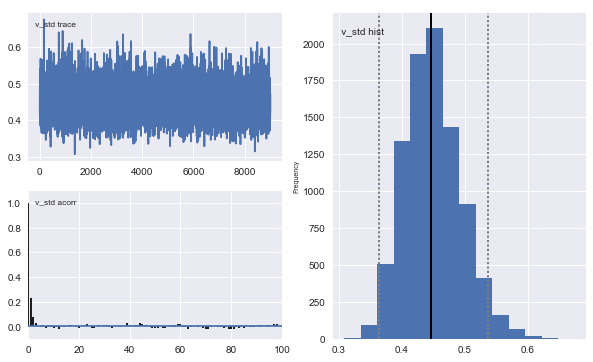

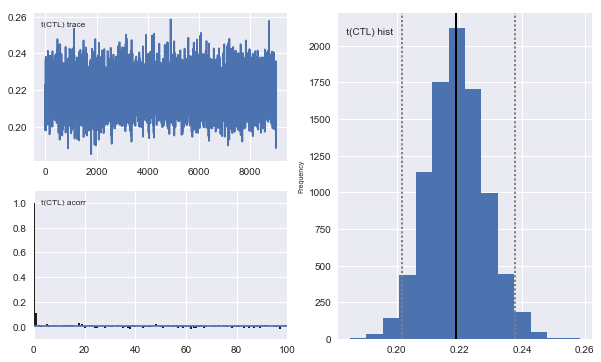

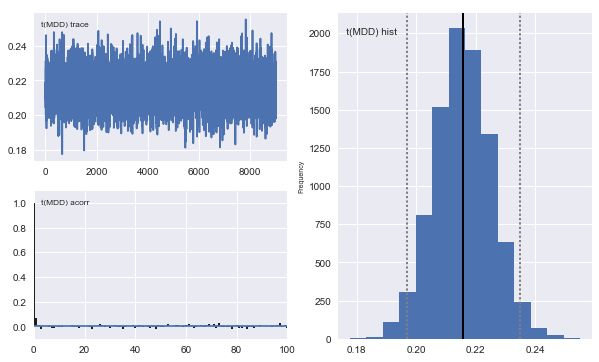

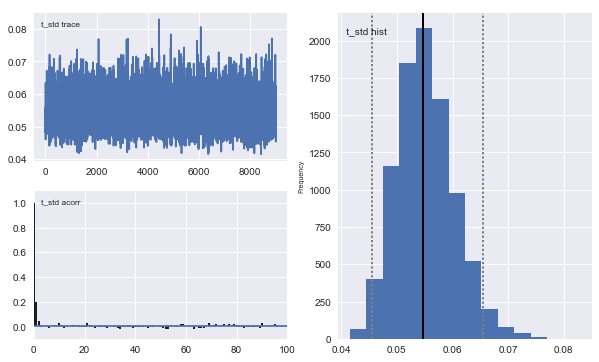

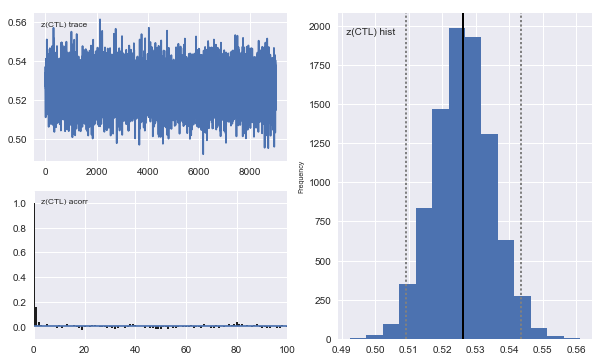

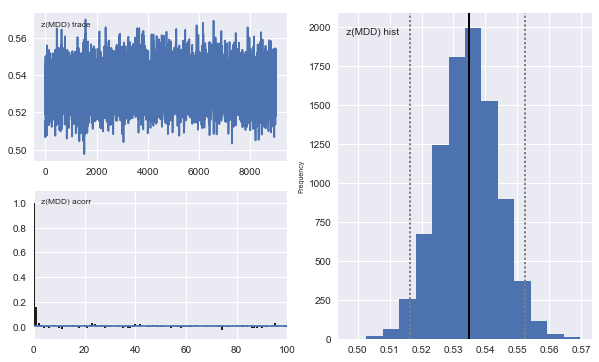

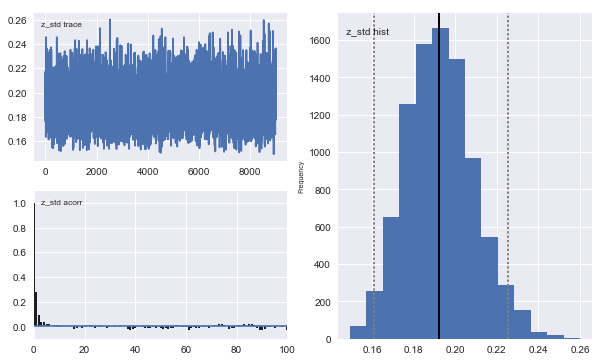

In [153]:
session1_model.plot_posteriors(['a', 't', 'v', 'z','a_std','t_std','v_std','z_std'])

P_a(MDD > CON) =  0.928222222222
P_a(CON > MDD) =  0.0717777777778


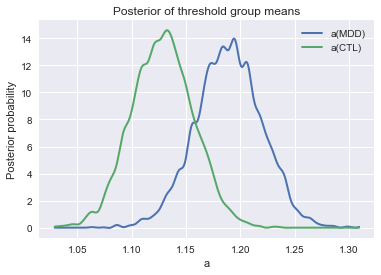

In [364]:
a_MDD, a_CON = session1_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.225666666667
P_a(CON > MDD) =  0.774333333333


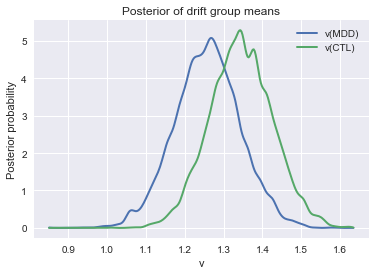

In [365]:
v_MDD, v_CON = session1_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.750555555556
P_a(CON > MDD) =  0.249444444444


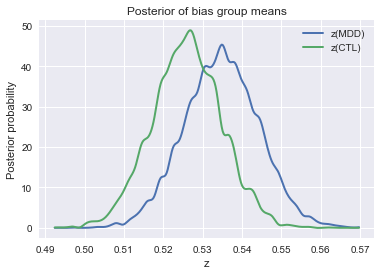

In [366]:
z_MDD, z_CON = session1_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of bias group means')

print ("P_a(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.392555555556
P_a(CON > MDD) =  0.607444444444


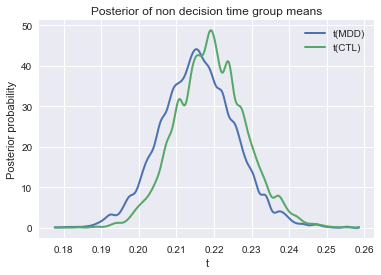

In [367]:
t_MDD, t_CON = session1_model.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means')

print ("P_a(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

In [368]:
def get_param(item):
    '''Returns the parameter from the genstats() data'''
    if len(item) == 13:
        param = item[0]
    elif len(item) == 18:
        param = item[0]
    else:
        param = np.nan
    return(param)
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 13:
        sub_id = item[7:13]
    elif len(item) == 18:
        sub_id = item[12:18]
    else:
        sub_id = np.nan
    return(sub_id)

In [369]:
stats = session1_model.gen_stats()
stats.to_csv(path2data + 'session1_modelstats_grp.csv')
stats = pd.read_csv(path2data + 'session1_modelstats_grp.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q  \
0              a(CTL)  1.129018  0.027954  1.075182  1.109953  1.129189   
1              a(MDD)  1.188828  0.029861  1.130145  1.169132  1.189148   
2               a_std  0.161498  0.015665  0.134271  0.150495  0.160315   
3  a_subj(CTL).DTC020  1.281590  0.050251  1.188677  1.246160  1.280088   
4  a_subj(CTL).DTC021  1.255495  0.047689  1.166212  1.222482  1.254608   

        75q     97.5q    mc err  
0  1.147681  1.183509  0.000354  
1  1.208630  1.245895  0.000335  
2  0.171425  0.195037  0.000221  
3  1.314623  1.385047  0.000695  
4  1.287722  1.351796  0.000589

In [370]:
sess1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')
sess1_standard = sess1.drop_duplicates('subjectID')

In [371]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
sess1['subj_idx'] = sess1.subjectID.apply(lambda x: str(x))
sess1_summary = sess1.drop_duplicates('subj_idx')
reward_stats = pd.merge(reward_stats, sess1_summary, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  Unnamed: 0.1  \
0  a_subj(CTL).DTC020  1.281590     a   DTC020           0             0   
1  v_subj(CTL).DTC020  1.384951     v   DTC020           0             0   
2  t_subj(CTL).DTC020  0.178441     t   DTC020           0             0   
3  z_subj(CTL).DTC020  0.439072     z   DTC020           0             0   
4  a_subj(CTL).DTC021  1.255495     a   DTC021         195           200   

   index  little_due  big_due    rt     ...      BDI1_total  BDI2_total  \
0      0           0        0   670     ...             2.0         1.0   
1      0           0        0   670     ...             2.0         1.0   
2      0           0        0   670     ...             2.0         1.0   
3      0           0        0   670     ...             2.0         1.0   
4    200           0        0  1172     ...             0.0         0.0   

   shaps1_total shaps2_total  pss1_total Medication Medication_Class  \
0             1            0          20          0                0   
1             1            0          20          0                0   
2             1            0          20          0                0   
3             1            0          20          0                0   
4             0            0           8          0                0   

  pss2_total  masc1_total masc2_total  
0         16           39          45  
1         16           39          45  
2         16           39          45  
3         16           39          45  
4         12           30          43  

[5 rows x 53 columns]

In [372]:
# get the data into usable form 
reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  Unnamed: 0.1  index  \
0  v_subj(CTL).DTC020  1.384951   DTC020           0             0      0   
1  v_subj(CTL).DTC021  1.442334   DTC021         195           200    200   
2  v_subj(CTL).DTC022  0.836997   DTC022         394           400    400   
3  v_subj(CTL).DTC024  1.748692   DTC024         591           800    800   
4  v_subj(CTL).DTC026  1.274460   DTC026         787          1200   1200   
5  v_subj(CTL).DTC027  1.174543   DTC027         983          1400   1400   
6  v_subj(CTL).DTC029  1.324883   DTC029        1183          1600   1600   
7  v_subj(CTL).DTC030  1.759928   DTC030        1381          1800   1800   
8  v_subj(CTL).DTC034  1.451201   DTC034        1580          2400   2400   
9  v_subj(CTL).DTC035  1.239559   DTC035        1779          2600   2600   

   little_due  big_due    rt  correct    ...     shaps2_total  pss1_total  \
0           0        0   670        1    ...                0          20   
1           0        0  1172        0    ...                0           8   
2           0        0   920        0    ...                0          20   
3           0        0   575        1    ...                0          19   
4           0        0   515        1    ...                0          19   
5           0        0   786        1    ...                           19   
6           0        0   728        1    ...                0          13   
7           0        0   615        1    ...                0          14   
8           1        0   398        0    ...                0           8   
9           0        0   417        1    ...                0          26   

  Medication  Medication_Class pss2_total masc1_total masc2_total    mean_a  \
0          0                 0         16          39          45  1.281590   
1          0                 0         12          30          43  1.255495   
2          0                 0         22          30          51  1.584868   
3          0                 0         10          60          61  1.087401   
4          0                 0         19          38          40  1.220787   
5          0                 0                     39              1.254626   
6          0                 0         20          25          36  1.357716   
7          0                 0          9          25          27  1.189070   
8          0                 0          6          16          22  1.168064   
9          0                 0         29          67          59  1.197066   

     mean_z    mean_t  
0  0.439072  0.178441  
1  0.576440  0.235484  
2  0.545109  0.254670  
3  0.549181  0.223758  
4  0.393020  0.213642  
5  0.622425  0.244257  
6  0.453763  0.255831  
7  0.541268  0.251869  
8  0.441413  0.160321  
9  0.552453  0.146241  

[10 rows x 55 columns]

In [83]:
reward_stats.to_csv(path2data + 'session1_hddm_params_grp.csv')

**Building a second model without group for regressions**

In [375]:
session1_model_nogrp = hddm.HDDMStimCoding(data1_for_ddm, include='z', stim_col='stim', split_param='v')
session1_model_nogrp.find_starting_values()
session1_model_nogrp.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1575.2 sec

In [376]:
session1_model_nogrp.dic_info

{'DIC': -1546.6622076212884,
 'deviance': -1791.6355925543287,
 'pD': 244.97338493304028}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


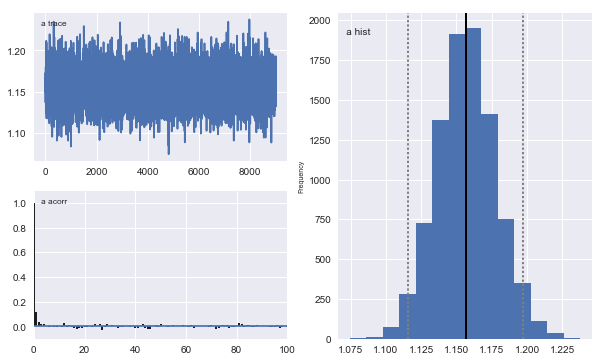

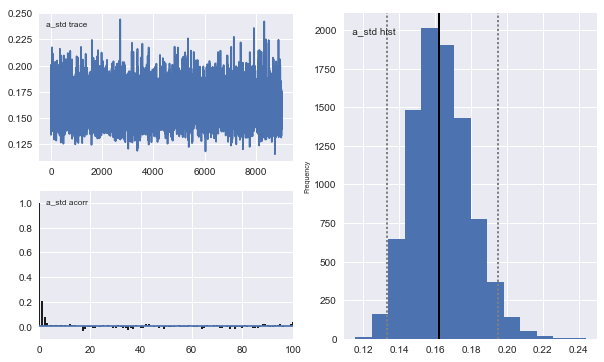

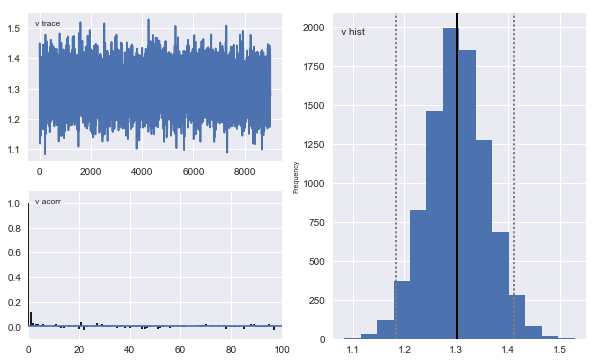

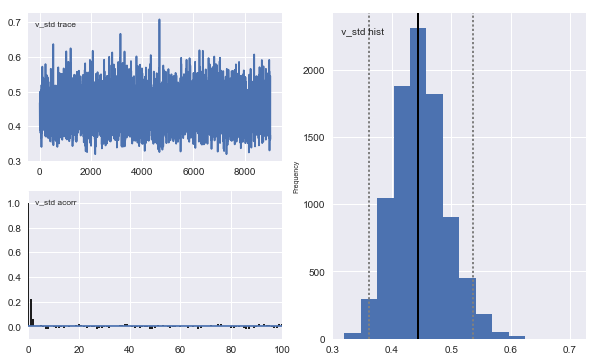

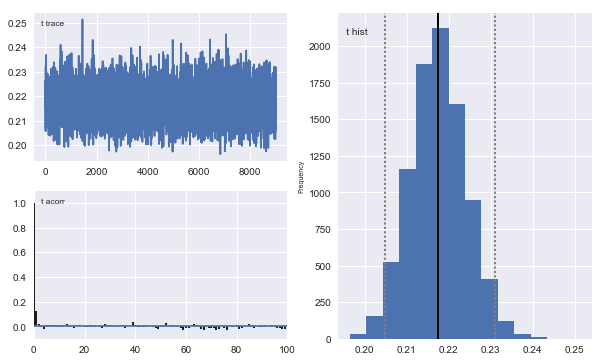

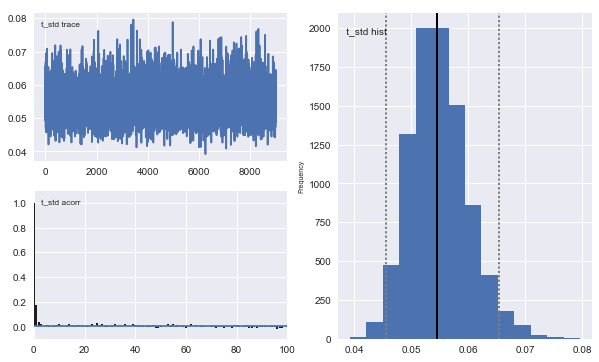

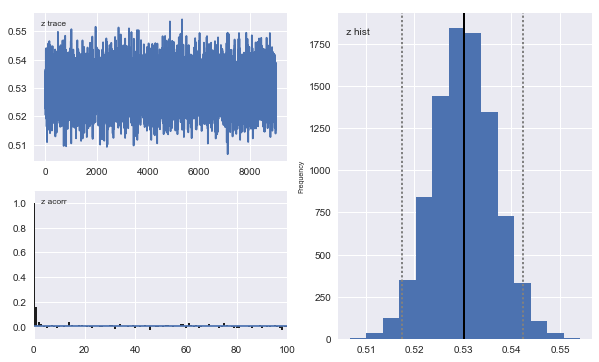

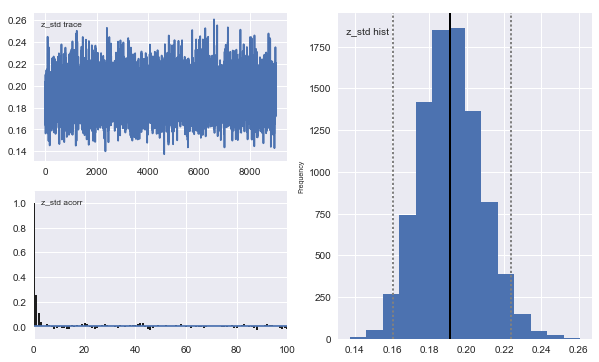

In [377]:
session1_model_nogrp.plot_posteriors(['a', 't', 'v', 'z','a_std','t_std','v_std','z_std'])

Get subject means

In [28]:
stats = session1_model_nogrp.gen_stats()
stats.to_csv(path2data + 'session1_modelstats.csv')
stats = pd.read_csv(path2data + 'session1_modelstats.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0              a  1.157435  0.020586  1.117955  1.143639  1.156868  1.171151   
1          a_std  0.163416  0.016006  0.135200  0.152081  0.162202  0.173555   
2  a_subj.DTC020  1.284002  0.049567  1.190328  1.249500  1.282820  1.316827   
3  a_subj.DTC021  1.256396  0.046825  1.168686  1.223998  1.255913  1.287590   
4  a_subj.DTC022  1.584275  0.053445  1.484919  1.546896  1.582735  1.619696   

      97.5q    mc err  
0  1.199063  0.000255  
1  0.198012  0.000232  
2  1.384309  0.000710  
3  1.351318  0.000626  
4  1.690860  0.000700

In [40]:
sess1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')
sess1_standard = sess1.drop_duplicates('subjectID')

In [205]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
sess1['subj_idx'] = sess1.subjectID.apply(lambda x: str(x))
sess1_summary = sess1.drop_duplicates('subj_idx')
reward_stats = pd.merge(reward_stats, sess1_summary, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  Unnamed: 0.1  index  \
0  a_subj.DTC020  1.284002     a   DTC020           0             0      0   
1  v_subj.DTC020  1.381627     v   DTC020           0             0      0   
2  t_subj.DTC020  0.178168     t   DTC020           0             0      0   
3  z_subj.DTC020  0.440410     z   DTC020           0             0      0   
4  a_subj.DTC021  1.256396     a   DTC021         195           200    200   

   little_due  did_reward  big_due     ...      BDI1_total  BDI2_total  \
0           0           1        0     ...             2.0         1.0   
1           0           1        0     ...             2.0         1.0   
2           0           1        0     ...             2.0         1.0   
3           0           1        0     ...             2.0         1.0   
4           0           0        0     ...             0.0         0.0   

   shaps1_total shaps2_total  pss1_total Medication Medication_Class  \
0             1            0          20          0                0   
1             1            0          20          0                0   
2             1            0          20          0                0   
3             1            0          20          0                0   
4             0            0           8          0                0   

  pss2_total  masc1_total masc2_total  
0         16           39          45  
1         16           39          45  
2         16           39          45  
3         16           39          45  
4         12           30          43  

[5 rows x 53 columns]

In [206]:
# get the data into usable form 
reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  Unnamed: 0.1  index  \
0  v_subj.DTC020  1.381627   DTC020           0             0      0   
1  v_subj.DTC021  1.439893   DTC021         195           200    200   
2  v_subj.DTC022  0.836511   DTC022         394           400    400   
3  v_subj.DTC024  1.750654   DTC024         591           800    800   
4  v_subj.DTC026  1.272939   DTC026         787          1200   1200   
5  v_subj.DTC027  1.169613   DTC027         983          1400   1400   
6  v_subj.DTC029  1.324404   DTC029        1183          1600   1600   
7  v_subj.DTC030  1.756605   DTC030        1381          1800   1800   
8  v_subj.DTC034  1.450410   DTC034        1580          2400   2400   
9  v_subj.DTC035  1.236606   DTC035        1779          2600   2600   

   little_due  did_reward  big_due  trial    ...     shaps2_total  pss1_total  \
0           0           1        0      1    ...                0          20   
1           0           0        0      1    ...                0           8   
2           0           0        0      1    ...                0          20   
3           0           1        0      1    ...                0          19   
4           0           1        0      1    ...                0          19   
5           0           0        0      1    ...                           19   
6           0           1        0      1    ...                0          13   
7           0           0        0      1    ...                0          14   
8           1           0        0      1    ...                0           8   
9           0           0        0      1    ...                0          26   

  Medication  Medication_Class pss2_total masc1_total masc2_total    mean_a  \
0          0                 0         16          39          45  1.284002   
1          0                 0         12          30          43  1.256396   
2          0                 0         22          30          51  1.584275   
3          0                 0         10          60          61  1.089692   
4          0                 0         19          38          40  1.221459   
5          0                 0                     39              1.256940   
6          0                 0         20          25          36  1.361353   
7          0                 0          9          25          27  1.190498   
8          0                 0          6          16          22  1.169594   
9          0                 0         29          67          59  1.199640   

     mean_z    mean_t  
0  0.440410  0.178168  
1  0.576663  0.235447  
2  0.545900  0.254810  
3  0.549151  0.223620  
4  0.394238  0.213505  
5  0.622726  0.244051  
6  0.454835  0.255391  
7  0.541955  0.251773  
8  0.442004  0.160325  
9  0.553335  0.146185  

[10 rows x 55 columns]

In [207]:
reward_stats.to_csv(path2data + 'session1_hddm_params.csv')

**ANCOVA w/ Age**

In [29]:
reward_stats = pd.read_csv(path2data + 'session1_hddm_params.csv')

In [35]:
%Rpush reward_stats
%R drift.aov <- aov_ez("subjectID", dv = "mean_v", \
                                 data = reward_stats, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(drift.aov)

Anova Table (Type 3 tests)

Response: mean_v
  Effect    df  MSE      F pes p.value
1  group 1, 61 0.16   0.81 .01     .37
2    Age 5, 61 0.16 2.26 + .16     .06


In [36]:
%Rpush reward_stats
%R thresh.aov <- aov_ez("subjectID", dv = "mean_a", \
                                 data = reward_stats, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(thresh.aov)

Anova Table (Type 3 tests)

Response: mean_a
  Effect    df  MSE    F pes p.value
1  group 1, 61 0.02 1.00 .02     .32
2    Age 5, 61 0.02 1.90 .13     .11


In [37]:
%Rpush reward_stats
%R bias.aov <- aov_ez("subjectID", dv = "mean_z", \
                                 data = reward_stats, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(bias.aov)

Anova Table (Type 3 tests)

Response: mean_z
  Effect    df  MSE    F  pes p.value
1  group 1, 61 0.00 0.59 .010     .44
2    Age 5, 61 0.00 0.70  .05     .62


In [38]:
%Rpush reward_stats
%R nond.aov <- aov_ez("subjectID", dv = "mean_t", \
                                 data = reward_stats, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(nond.aov)

Anova Table (Type 3 tests)

Response: mean_t
  Effect    df  MSE    F   pes p.value
1  group 1, 61 0.00 0.05 .0009     .82
2    Age 5, 61 0.00 0.52   .04     .76


## Relationships between HDDM parameters & standard parameters

In [312]:
# this is the model without group included
reward_stats = pd.read_csv(path2data + 'session1_hddm_params.csv')
reward_stats.groupby('group').subjectID.nunique()

group
CTL    36
MDD    32
Name: subjectID, dtype: int64


	Pearson's product-moment correlation

data:  reward_stats$mean_v and reward_stats$dis_adjst_all_total
t = 15.522, df = 66, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8209805 0.9283102
sample estimates:
      cor 
0.8859815 



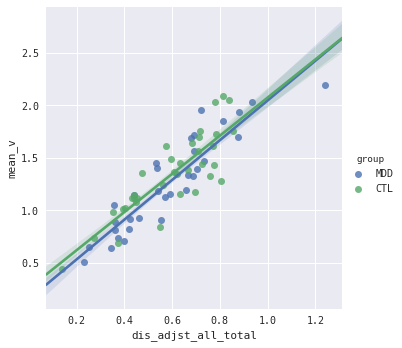

In [313]:
# disc and drift, nice

corr_param = sns.lmplot(y='mean_v', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_v, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a and reward_stats$dis_adjst_all_total
t = 1.7261, df = 66, p-value = 0.08901
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03219242  0.42518447
sample estimates:
      cor 
0.2078279 



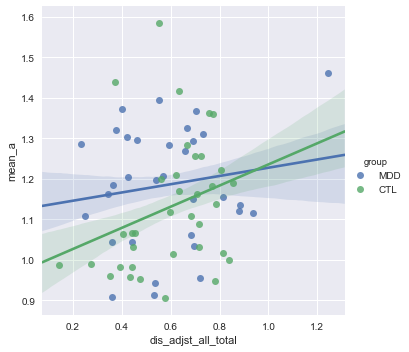

In [34]:
# disc and threshold

corr_param = sns.lmplot(y='mean_a', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_a, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z and reward_stats$dis_adjst_all_total
t = -0.93325, df = 66, p-value = 0.3541
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3432104  0.1277778
sample estimates:
       cor 
-0.1141241 



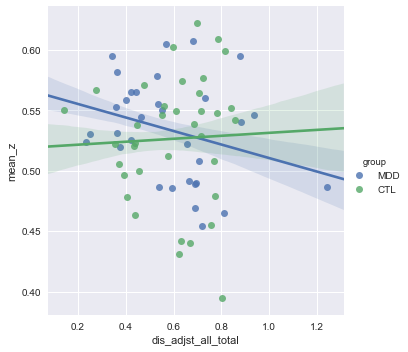

In [35]:
# disc and starting point

corr_param = sns.lmplot(y='mean_z', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_z, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z and reward_stats$RB_adjst_all_total
t = 8.2076, df = 66, p-value = 1.126e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5686486 0.8116107
sample estimates:
      cor 
0.7107149 



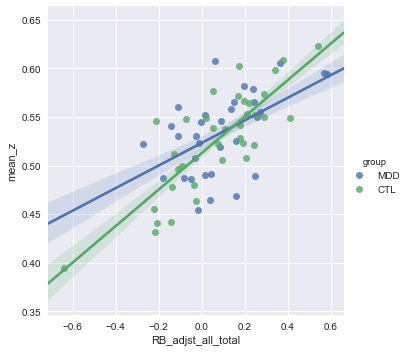

In [36]:
# RB & z, nice again

corr_param = sns.lmplot(y='mean_z', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_z.cor <- cor.test(reward_stats$mean_z, reward_stats$RB_adjst_all_total)
%R print(rb_z.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a and reward_stats$RB_adjst_all_total
t = -1.4985, df = 66, p-value = 0.1388
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.40241076  0.05961427
sample estimates:
      cor 
-0.181389 



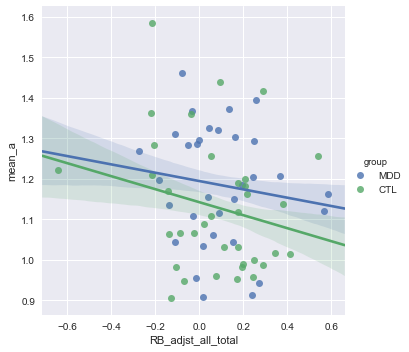

In [37]:
# RB & threshold

corr_param = sns.lmplot(y='mean_a', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_a, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_v and reward_stats$RB_adjst_all_total
t = -0.28921, df = 66, p-value = 0.7733
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2716972  0.2045837
sample estimates:
        cor 
-0.03557674 



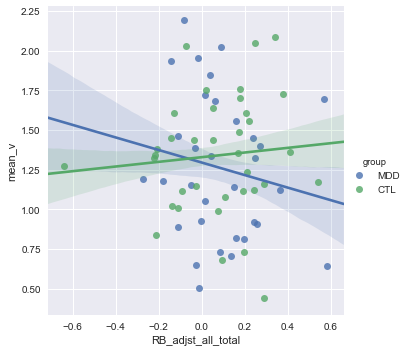

In [38]:
# RB & drift

corr_param = sns.lmplot(y='mean_v', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_v, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)

### Regression w/ discriminability

In [41]:
# this is the model without group included group
reward_stats = pd.read_csv(path2data + 'session1_hddm_params.csv')
reward_stats = reward_stats[['subjectID', 'mean_v', 'mean_a', 'mean_z']]
sess1_summary = sess1.drop_duplicates(['subjectID','block'])
prt_params_df = sess1_summary.merge(reward_stats, on='subjectID')

In [42]:
%R library(lmerTest)
%Rpush prt_params_df

# make the model with just group
%R disc_reg1.lm = lm(dis_adjst_all_block ~ block + group, data = prt_params_df)
%R disc_reg2.lm = lm(dis_adjst_all_block ~ block*group, data=prt_params_df)

# compare the two models: no diff so top is better
%R test_models.aov <- anova(disc_reg1.lm, disc_reg2.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group
Model 2: dis_adjst_all_block ~ block * group
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1    133 6.7783                           
2    132 6.7566  1  0.021727 0.4245 0.5158


In [43]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg3.lm = lm(dis_adjst_all_block ~ block + group + mean_v + mean_a + mean_z, data=prt_params_df)

# compare the new model w/ old: new is better
%R test_models.aov <- anova(disc_reg1.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group
Model 2: dis_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1    133 6.7783                                  
2    130 1.7500  3    5.0283 124.51 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [44]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg4.lm = lm(dis_adjst_all_block ~ block + group*mean_v + mean_a + mean_z, data=prt_params_df)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg4.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_v + mean_a + mean_z
Model 2: dis_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df  Sum of Sq      F Pr(>F)
1    129 1.7441                            
2    130 1.7500 -1 -0.0058521 0.4328 0.5118


In [45]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg5.lm = lm(dis_adjst_all_block ~ block + group*mean_a + mean_v + mean_z, data=prt_params_df)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg5.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_a + mean_v + mean_z
Model 2: dis_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df  Sum of Sq      F Pr(>F)
1    129 1.7467                            
2    130 1.7500 -1 -0.0032643 0.2411 0.6243


In [46]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg6.lm = lm(dis_adjst_all_block ~ block + group*mean_z + mean_v + mean_a, data=prt_params_df)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg6.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_z + mean_v + mean_a
Model 2: dis_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1    129 1.7396                           
2    130 1.7500 -1 -0.010325 0.7656 0.3832


In [48]:
# print the winner
%R print(summary(disc_reg3.lm))


Call:
lm(formula = dis_adjst_all_block ~ block + group + mean_v + mean_a + 
    mean_z, data = prt_params_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24919 -0.07936 -0.00674  0.06146  0.55291 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.438854   0.158624  -2.767 0.006490 ** 
block       -0.067336   0.019898  -3.384 0.000944 ***
groupMDD    -0.002721   0.020392  -0.133 0.894039    
mean_v       0.462649   0.024772  18.676  < 2e-16 ***
mean_a       0.528964   0.067698   7.814 1.65e-12 ***
mean_z      -0.143880   0.212166  -0.678 0.498883    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.116 on 130 degrees of freedom
Multiple R-squared:  0.7477,	Adjusted R-squared:  0.738 
F-statistic: 77.07 on 5 and 130 DF,  p-value: < 2.2e-16



### Regression w/ Response bias

In [49]:
%R library(lmerTest)
%Rpush prt_params_df

# make the model with just group (need to redo after model w/ no group)
%R rb_reg1.lm = lm(RB_adjst_all_block ~ block + group, data = prt_params_df)
%R rb_reg2.lm = lm(RB_adjst_all_block ~ block*group, data=prt_params_df)

# compare the two models: no diff so top is better
%R test_models.aov <- anova(rb_reg1.lm, rb_reg2.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group
Model 2: RB_adjst_all_block ~ block * group
  Res.Df    RSS Df Sum of Sq     F Pr(>F)
1    133 7.8942                          
2    132 7.8071  1  0.087061 1.472 0.2272


In [50]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg3.lm = lm(RB_adjst_all_block ~ block + group + mean_v + mean_a + mean_z, data=prt_params_df)

# compare the new model w/ old: new is better
%R test_models.aov <- anova(rb_reg1.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group
Model 2: RB_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1    133 7.8942                                  
2    130 4.9651  3    2.9291 25.564 4.592e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [51]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg4.lm = lm(RB_adjst_all_block ~ block + group*mean_v + mean_a + mean_z, data=prt_params_df)

# compare the new model w/ old: old is better
%R test_models.aov <- anova(rb_reg4.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_v + mean_a + mean_z
Model 2: RB_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df  Sum of Sq      F Pr(>F)
1    129 4.9621                            
2    130 4.9651 -1 -0.0030465 0.0792 0.7788


In [52]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg5.lm = lm(RB_adjst_all_block ~ block + group*mean_a + mean_v + mean_z, data=prt_params_df)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(rb_reg5.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_a + mean_v + mean_z
Model 2: RB_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1    129 4.9254                           
2    130 4.9651 -1  -0.03973 1.0406 0.3096


In [53]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg6.lm = lm(RB_adjst_all_block ~ block + group*mean_z + mean_v + mean_a, data=prt_params_df)

# compare the new model w/ old: this is the winner
%R test_models.aov <- anova(rb_reg6.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_z + mean_v + mean_a
Model 2: RB_adjst_all_block ~ block + group + mean_v + mean_a + mean_z
  Res.Df    RSS Df Sum of Sq      F  Pr(>F)  
1    129 4.8123                              
2    130 4.9651 -1  -0.15284 4.0972 0.04502 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [54]:
# print the winner
%R print(summary(rb_reg6.lm))


Call:
lm(formula = RB_adjst_all_block ~ block + group * mean_z + mean_v + 
    mean_a, data = prt_params_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37609 -0.14207  0.00579  0.11800  0.74423 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.623326   0.286795  -5.660 9.33e-08 ***
block            0.005603   0.033124   0.169    0.866    
groupMDD         0.811266   0.398903   2.034    0.044 *  
mean_z           3.533410   0.439532   8.039 5.03e-13 ***
mean_v          -0.022506   0.042705  -0.527    0.599    
mean_a          -0.124305   0.113114  -1.099    0.274    
groupMDD:mean_z -1.515778   0.748844  -2.024    0.045 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1931 on 129 degrees of freedom
Multiple R-squared:  0.3918,	Adjusted R-squared:  0.3636 
F-statistic: 13.85 on 6 and 129 DF,  p-value: 4.11e-12



In [55]:
# follow up on group * z interaction
%R detach(package:lmerTest) # do this if you get not a linear model error

%R library(lsmeans)
%R group_x_mean_v.lsm <- lsmeans(rb_reg6.lm, ~ group*mean_z)
%R print(group_x_mean_v.lsm)
%R print(pairs(group_x_mean_v.lsm))

 group    mean_z     lsmean         SE  df   lower.CL  upper.CL
 CTL   0.5299293 0.08449422 0.02303520 129 0.03891852 0.1300699
 MDD   0.5299293 0.09250537 0.02449719 129 0.04403708 0.1409737

Confidence level used: 0.95 


 contrast                                          estimate         SE  df
 CTL,0.529929254570656 - MDD,0.529929254570656 -0.008011143 0.03395253 129
 t.ratio p.value
  -0.236  0.8138



# Follow-up

In [398]:
data2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_final.csv')

In [380]:
data2.groupby('group').subjectID.nunique()

group
CTL    30
MDD    21
Name: subjectID, dtype: int64

### Standard Analysis

Both groups still show a response bias

In [58]:
data_standard = data2.drop_duplicates('subjectID')
data_mdd = data_standard.loc[data_standard.group == 'MDD']
%Rpush data_mdd
%R rb.test <- t.test(data_mdd$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_mdd$RB_adjst_all_block
t = 2.1484, df = 20, p-value = 0.02206
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.01893049        Inf
sample estimates:
 mean of x 
0.09599408 



In [59]:
data_ctl = data_standard.loc[data_standard.group == 'CTL']
%Rpush data_ctl
%R rb.test <- t.test(data_ctl$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  data_ctl$RB_adjst_all_block
t = 1.89, df = 29, p-value = 0.0344
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.00780442        Inf
sample estimates:
 mean of x 
0.07728655 



In [60]:
data2.groupby('group').RB_adjst_all_block.mean()

group
CTL    0.074062
MDD    0.112424
Name: RB_adjst_all_block, dtype: float64

Anova Table (Type 3 tests)

Response: RB_adjst_all_block
       Effect    df  MSE    F  pes p.value
1       group 1, 49 0.07 0.55  .01     .46
2       block 1, 49 0.03 0.22 .004     .64
3 group:block 1, 49 0.03 0.36 .007     .55

Sphericity correction method: GG 


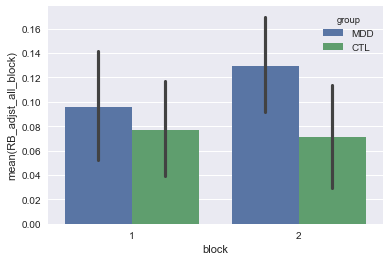

In [61]:
total_rb_plot = sns.barplot(y='RB_adjst_all_block', x = 'block', hue = 'group',\
                            hue_order = ['MDD','CTL'], data = data2, units = 'subjectID',ci=68)

%Rpush data2
%R rb.aov <- aov_ez("subjectID", dv = "RB_adjst_all_block", \
                                 data = data2, within = "block", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

In [62]:
%Rpush data2
%R rb.aov <- aov_ez("subjectID", dv = "RB_b2_minus_b1", \
                                 data = data2, between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: RB_b2_minus_b1
  Effect    df  MSE    F  pes p.value
1  group 1, 49 0.06 0.36 .007     .55


Anova Table (Type 3 tests)

Response: dis_adjst_all_block
       Effect    df  MSE       F  pes p.value
1       group 1, 49 0.09    0.11 .002     .74
2       block 1, 49 0.01 8.69 **  .15    .005
3 group:block 1, 49 0.01    0.73  .01     .40

Sphericity correction method: GG 


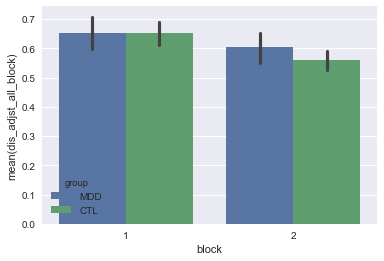

In [74]:
plot = sns.barplot(y='dis_adjst_all_block', x = 'block', 
                                   data = data2, hue = 'group', hue_order = ['MDD','CTL'],ci=68, units= 'subjectID')
%Rpush data2
%R discriminability.aov <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data2, within = 'block',\
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.aov)

In [141]:
# Adding RB as a covariate, block is still significant

%Rpush data2
%R discriminability.ancova <- aov_ez("subjectID", dv = "dis_adjst_all_block", \
                                 data = data2, within = 'block',covariate='RB_adjst_all_total',\
                                 between = "group",factorize=FALSE,anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.ancova)

Anova Table (Type 3 tests)

Response: dis_adjst_all_block
                    Effect    df  MSE      F   pes p.value
1                    group 1, 48 0.09   0.12  .003     .73
2       RB_adjst_all_total 1, 48 0.09   0.03 .0007     .86
3                    block 1, 48 0.02 5.59 *   .10     .02
4              group:block 1, 48 0.02   0.81   .02     .37
5 RB_adjst_all_total:block 1, 48 0.02   0.31  .006     .58

Sphericity correction method: GG 


No relationship between RB & disc


	Pearson's product-moment correlation

data:  data2_standard$RB_adjst_all_total2 and data2_standard$dis_adjst_all_total2
t = -0.17861, df = 49, p-value = 0.859
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2989896  0.2518464
sample estimates:
        cor 
-0.02550767 



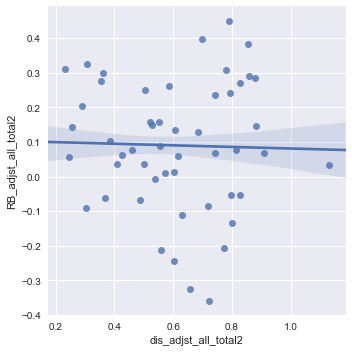

In [140]:
rb_disc = sns.lmplot(y='RB_adjst_all_total2', \
                                   x = 'dis_adjst_all_total2',data=data2_standard,ci=68)
%Rpush data2_standard
%R rb1_rb2 <- cor.test(data2_standard$RB_adjst_all_total2,data2_standard$dis_adjst_all_total2,method="pearson")
%R print (rb1_rb2)

Anova Table (Type 3 tests)

Response: ln_rt
       Effect    df  MSE       F  pes p.value
1       group 1, 49 0.07  4.07 *  .08     .05
2       block 1, 49 0.01 7.62 **  .13    .008
3 group:block 1, 49 0.01    0.31 .006     .58

Sphericity correction method: GG 


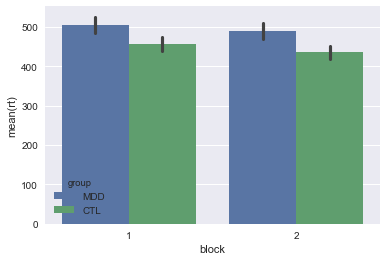

In [75]:
rt_plot = sns.barplot(y='rt', x = 'block', hue = 'group', hue_order = ['MDD','CTL'], data=data2,  \
                      ci=68, units = 'subjectID')

%Rpush data
%R rt.aov <- aov_ez("subjectID", dv = "ln_rt", \
                                 data = data2, within = 'block',\
                                 between = 'group',anova_table=list(correction="GG", es = "pes"))
%R print (rt.aov)

### Relationships between RB/disc and reward count


	Pearson's product-moment correlation

data:  data2_standard$RB_adjst_all_total and data2_standard$rwdct
t = 1.1844, df = 49, p-value = 0.242
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1139951  0.4229671
sample estimates:
      cor 
0.1668296 



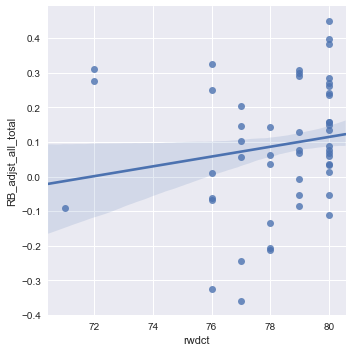

In [383]:
rb_rwdct = sns.lmplot(y='RB_adjst_all_total', \
                                   x = 'rwdct',data=data2_standard,ci=68)
%Rpush data2_standard
%R rb2_rwdct <- cor.test(data2_standard$RB_adjst_all_total,data2_standard$rwdct,method="pearson")
%R print (rb2_rwdct)


	Pearson's product-moment correlation

data:  data2_standard$dis_adjst_all_total and data2_standard$rwdct
t = 4.7034, df = 49, p-value = 2.122e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3333648 0.7222831
sample estimates:
      cor 
0.5577116 



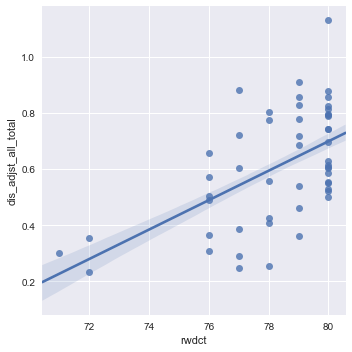

In [384]:
disc_rwdct = sns.lmplot(y='dis_adjst_all_total', \
                                   x = 'rwdct',data=data2_standard,ci=68)
%Rpush data2_standard
%R disc2_rwdct <- cor.test(data2_standard$dis_adjst_all_total,data2_standard$rwdct,method="pearson")
%R print (disc2_rwdct)

In [385]:
# these correlations don't differ
%Rpush data2_standard
%R compare_corr <- cocor (~ rwdct + dis_adjst_all_total | rwdct + RB_adjst_all_total,\
                          data2_standard)
%R print(compare_corr)


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk (rwdct, dis_adjst_all_total) = 0.5577 and r.jh (rwdct, RB_adjst_all_total) = 0.1668
Difference: r.jk - r.jh = 0.3909
Related correlation: r.kh = -0.0255
Data: data2_standard: j = rwdct, k = dis_adjst_all_total, h = RB_adjst_all_total
Group size: n = 51
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = 2.2679, p-value = 0.0233
  Null hypothesis rejected

hotelling1940: Hotelling's t (1940)
  t = 2.3344, df = 48, p-value = 0.0238
  Null hypothesis rejected

williams1959: Williams' t (1959)
  t = 2.2221, df = 48, p-value = 0.0310
  Null hypothesis rejected

olkin1967: Olkin's z (1967)
  z = 2.2679, p-value = 0.0233
  Null hypothesis rejected

dunn1969: Dunn and Clark's z (1969)
  z = 2.1827, p-value = 0.0291
  Null hypothesis rejected

hendrickson1970: Hendrickson, Stanl

### RT distributions

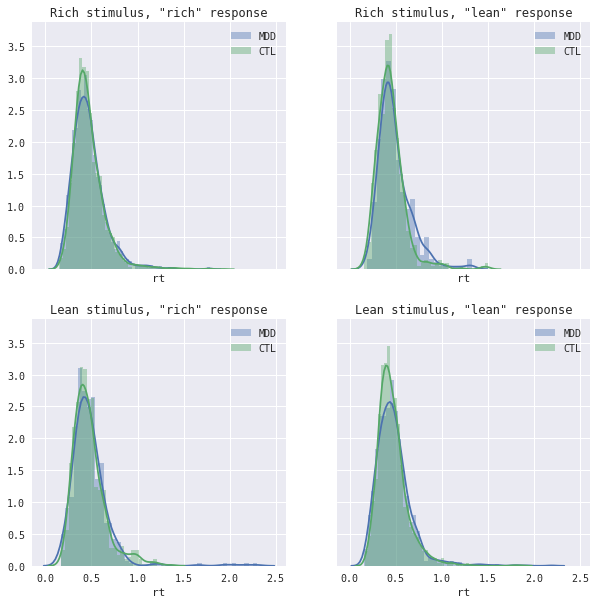

In [274]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))

# Rich stimulus
sns.distplot(data2[(data2.group == 'MDD') & (data2.rl_stim == 'rich_stim') & (data2.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax1,label='MDD')
sns.distplot(data2[(data2.group == 'CTL') & (data2.rl_stim == 'rich_stim') & (data2.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax1,label='CTL')
ax1.set_title('Rich stimulus, "rich" response')
ax1.legend()

sns.distplot(data2[(data2.group == 'MDD') & (data2.rl_stim == 'rich_stim') & (data2.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax2,label='MDD')
sns.distplot(data2[(data2.group == 'CTL') & (data2.rl_stim == 'rich_stim') & (data2.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax2,label='CTL')
ax2.set_title('Rich stimulus, "lean" response')
ax2.legend()

# Lean stimulus
sns.distplot(data2[(data2.group == 'MDD') & (data2.rl_stim == 'lean_stim') & (data2.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax3,label='MDD')
sns.distplot(data2[(data2.group == 'CTL') & (data2.rl_stim == 'lean_stim') & (data2.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax3,label='CTL')
ax3.set_title('Lean stimulus, "rich" response')
ax3.legend()

sns.distplot(data2[(data2.group == 'MDD') & (data2.rl_stim == 'lean_stim') & (data2.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax4,label='MDD')
sns.distplot(data2[(data2.group == 'CTL') & (data2.rl_stim == 'lean_stim') & (data2.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax4,label='CTL')
ax4.set_title('Lean stimulus, "lean" response')
ax4.legend()

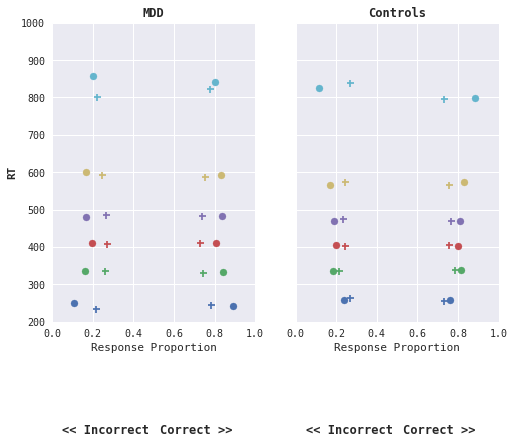

In [295]:
data2['rt'] = data2.rt*1000
pal = sns.color_palette()
ct = 0

clean=data2
f,(ax1,ax2) = plt.subplots(1,2,sharex=False,sharey=True)
for pair in [(ax1,'MDD'),(ax2,'CTL')]:
    axis, grp = pair
    
    if grp == 'CTL':
        grp_name = 'Controls'
    else:
        grp_name = 'MDD'

    old_val = 0.005
    for new_val in [0.1,0.3,0.5,0.7,0.9,0.995]:
        d_clean = clean[clean.group == grp]
        df = d_clean[(d_clean.group == grp) & (d_clean.rt > d_clean.rt.quantile(q=old_val)) &
                                                 (d_clean.rt < d_clean.rt.quantile(q=new_val))]
        pct_corr_rich = df[df.rl_stim=='rich_stim'].correct.mean()
        pct_err_rich = 1 - pct_corr_rich
        pct_corr_lean = df[df.rl_stim=='lean_stim'].correct.mean()
        pct_err_lean = 1 - pct_corr_lean
        
        corr_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 0)]['rt'].mean()
        corr_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 0)]['rt'].mean()
        
        axis.scatter(x=(pct_corr_rich,pct_err_rich),
                     y=(corr_rt_rich,err_rt_rich),marker='o',c=pal[ct])
        axis.scatter(x=(pct_corr_lean,pct_err_lean),
                     y=(corr_rt_lean,err_rt_lean),marker='+',c=pal[ct])

        old_val = new_val

        if ct < 5:
            ct = ct + 1
        else:
            ct = 0
        
    axis.set_ylabel('RT',weight='bold')
    axis.set_xlabel('Response Proportion')
    axis.set_xlim(0,1)
    axis.set_ylim(200,1000)
    axis.text(x=0.53,y=-100,s='Correct >>',fontsize=12,weight='bold')
    axis.text(x=0.05,y=-100,s='<< Incorrect',fontsize=12,weight='bold')
    axis.set_title(grp_name,weight='bold')
    
ax2.set_ylabel('')

In [408]:
# Anova on accuracy for fast and slow responses—bringing this in from
# your embarc notebook
#%R detach(package:lmerTest)

# Fast RTs: strong main effects of Stimulus
fast = data2[data2.rt <= data2.rt.quantile(q=0.3)]
print('For the "fast" data, the min RT = ' + str(np.min(fast.rt)) + ', the max RT = ' + str(np.max(fast.rt)) + '.')

%Rpush fast

%R fast.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=fast,\
                     anova_table=list(correction='GG',es='pes'))
%R print(fast.aov)


# Fast: main effect of Stimulus, rich > lean
%R fast_stim.lsm <- lsmeans(fast.aov,~rl_stim)
%R print(fast_stim.lsm)

# Main effect of stimulus 
slow = data2[data2.rt > data2.rt.quantile(q=0.3)]
print('For the "slow" data, the min RT = ' + str(np.min(slow.rt)) + ', the max RT = ' + str(np.max(slow.rt)) + '.')

%Rpush slow
%R slow.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=slow,\
                     anova_table=list(correction='GG',es='pes'))
%R print(slow.aov)

# Slow: main effect of Stimulus, rich > lean
%R slow_stim.lsm <- lsmeans(slow.aov,~rl_stim)
%R print(slow_stim.lsm)

For the "fast" data, the min RT = 151, the max RT = 374.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE       F  pes p.value
1         group 1, 47 0.04    0.44 .009     .51
2       rl_stim 1, 47 0.04 7.29 **  .13    .010
3 group:rl_stim 1, 47 0.04    0.72  .01     .40

Sphericity correction method: GG 


 rl_stim      lsmean         SE    df  lower.CL  upper.CL
 lean_stim 0.6924059 0.02910031 93.47 0.6346222 0.7501895
 rich_stim 0.8076467 0.02910031 93.47 0.7498631 0.8654304

Results are averaged over the levels of: group 
Confidence level used: 0.95 


For the "slow" data, the min RT = 375, the max RT = 2283.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE      F   pes p.value
1         group 1, 49 0.01   0.01 .0002     .93
2       rl_stim 1, 49 0.01 5.26 *   .10     .03
3 group:rl_stim 1, 49 0.01   1.66   .03     .20

Sphericity correction method: GG 


 rl_stim      lsmean         SE    df  lower.CL  upper.CL
 lean_stim 0.7795595 0.01365974 95.74 0.7524441 0.8066748
 rich_stim 0.8203047 0.01365974 95.74 0.7931894 0.8474200

Results are averaged over the levels of: group 
Confidence level used: 0.95 


In [314]:
data2.rt.describe()

count    10018.000000
mean       469.740667
std        179.862748
min        150.000000
25%        357.000000
50%        439.000000
75%        542.000000
max       2300.000000
Name: rt, dtype: float64

### Changes in standard variables from T1 to T2
Discriminability is stable, RB is not.

**Response Bias**

In [65]:
data1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')
data1_standard = data1.drop_duplicates('subjectID')
data2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_final.csv')
data2_standard = data2.drop_duplicates('subjectID')

data2_standard['RB_adjst_all_total2'] = data2_standard['RB_adjst_all_total']
del data2_standard['RB_adjst_all_total']
all_data = data1_standard.merge(data2_standard, on='subjectID')


	Pearson's product-moment correlation

data:  all_data$RB_adjst_all_total2 and all_data$RB_adjst_all_total
t = 0.16451, df = 45, p-value = 0.8701
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2645121  0.3095047
sample estimates:
     cor 
0.024517 



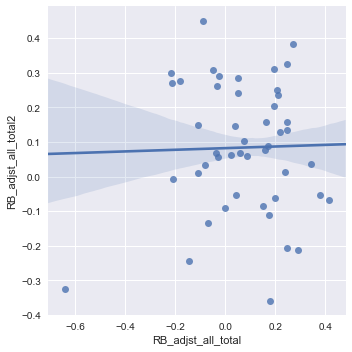

In [66]:
# in everyone: Nothing
rb_two = sns.lmplot(y='RB_adjst_all_total2', \
                                   x = 'RB_adjst_all_total',data=all_data,ci=68)
%Rpush all_data
%R rb1_rb2 <- cor.test(all_data$RB_adjst_all_total2,all_data$RB_adjst_all_total,method="pearson")
%R print (rb1_rb2)


	Pearson's product-moment correlation

data:  ctl_data$RB_adjst_all_total2 and ctl_data$RB_adjst_all_total
t = 0.19544, df = 26, p-value = 0.8466
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3396296  0.4055819
sample estimates:
       cor 
0.03830032 



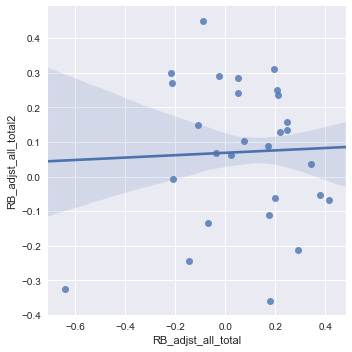

In [67]:
# in controls: still nothing
ctl_data = all_data[all_data.group_x == 'CTL']
rb_two = sns.lmplot(y='RB_adjst_all_total2', \
                                   x = 'RB_adjst_all_total',data=ctl_data,ci=68)
%Rpush ctl_data
%R rb1_rb2_ctl <- cor.test(ctl_data$RB_adjst_all_total2,ctl_data$RB_adjst_all_total,method="pearson")
%R print (rb1_rb2_ctl)

**Discriminability**

In [95]:
data1 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session1_trial_final.csv')
data1_standard = data1.drop_duplicates('subjectID')
data2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_final.csv')
data2_standard = data2.drop_duplicates('subjectID')
data2_standard['dis_adjst_all_total2'] = data2_standard['dis_adjst_all_total']
data2_standard['RB_adjst_all_total2'] = data2_standard['RB_adjst_all_total']
del data2_standard['dis_adjst_all_total']
del data2_standard['RB_adjst_all_total']
all_data = data1_standard.merge(data2_standard[['subjectID','dis_adjst_all_total2','RB_adjst_all_total2']], on='subjectID')


	Pearson's product-moment correlation

data:  all_data$dis_adjst_all_total2 and all_data$dis_adjst_all_total
t = 3.8575, df = 45, p-value = 0.0003623
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2466440 0.6872828
sample estimates:
      cor 
0.4985029 



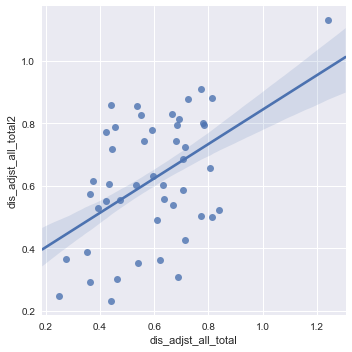

In [96]:
# in everyone
rb_two = sns.lmplot(y='dis_adjst_all_total2', \
                                   x = 'dis_adjst_all_total',data=all_data,ci=68)
%Rpush all_data
%R dis1_dis2 <- cor.test(all_data$dis_adjst_all_total2,all_data$dis_adjst_all_total,method="pearson")
%R print (dis1_dis2)


	Pearson's product-moment correlation

data:  ctl_data$dis_adjst_all_total2 and ctl_data$dis_adjst_all_total
t = 1.6989, df = 26, p-value = 0.1013
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.06460287  0.61647095
sample estimates:
      cor 
0.3160925 



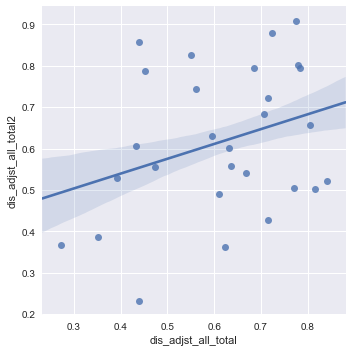

In [98]:
# in just controls
ctl_data = all_data[all_data.group == 'CTL']
rb_two = sns.lmplot(y='dis_adjst_all_total2', \
                                   x = 'dis_adjst_all_total',data=ctl_data,ci=68)
%Rpush ctl_data
%R dis1_dis2_ctl <- cor.test(ctl_data$dis_adjst_all_total2,ctl_data$dis_adjst_all_total,method="pearson")
%R print (dis1_dis2_ctl)

**Discriminability vs. RB stability**

In [100]:
# Disc is more stable than RB

%Rpush all_data
%R compare_corr <- cocor (~ dis_adjst_all_total + dis_adjst_all_total2 | RB_adjst_all_total + RB_adjst_all_total2,\
                          all_data)
%R print(compare_corr)


  Results of a comparison of two nonoverlapping correlations based on dependent groups

Comparison between r.jk (dis_adjst_all_total, dis_adjst_all_total2) = 0.4985 and r.hm (RB_adjst_all_total, RB_adjst_all_total2) = 0.0245
Difference: r.jk - r.hm = 0.474
Related correlations: r.jh = -0.0832, r.jm = -0.1189, r.kh = -0.0948, r.km = -0.0377
Data: all_data: j = dis_adjst_all_total, k = dis_adjst_all_total2, h = RB_adjst_all_total, m = RB_adjst_all_total2
Group size: n = 47
Null hypothesis: r.jk is equal to r.hm
Alternative hypothesis: r.jk is not equal to r.hm (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = 2.6114, p-value = 0.0090
  Null hypothesis rejected

dunn1969: Dunn and Clark's z (1969)
  z = 2.4646, p-value = 0.0137
  Null hypothesis rejected

steiger1980: Steiger's (1980) modification of Dunn and Clark's z (1969) using average correlations
  z = 2.4645, p-value = 0.0137
  Null hypothesis rejected

raghunathan1996: Raghunathan, Rosenthal, and Rubin's (1

## HDDM

In [76]:
# getting the data HDDM compatible

data2.loc[data2.rl_resp == 'rich_resp', 'response'] = 1
data2.loc[data2.rl_resp == 'lean_resp', 'response'] = 0
data2.loc[data2.rl_stim == 'rich_stim', 'stim'] = 1
data2.loc[data2.rl_stim == 'lean_stim', 'stim'] = 0
data2.rename(columns={'subjectID': 'subj_idx'}, inplace=True)
data2['rt'] = data.rt/1000
data2.to_csv(path2data + 'session2_hddm_ready.csv')

In [389]:
data2 = hddm.load_csv(path2data + 'session2_hddm_ready.csv')

In [396]:
session2_model = hddm.HDDMStimCoding(data2, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
session2_model.find_starting_values()
session2_model.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1234.0 sec

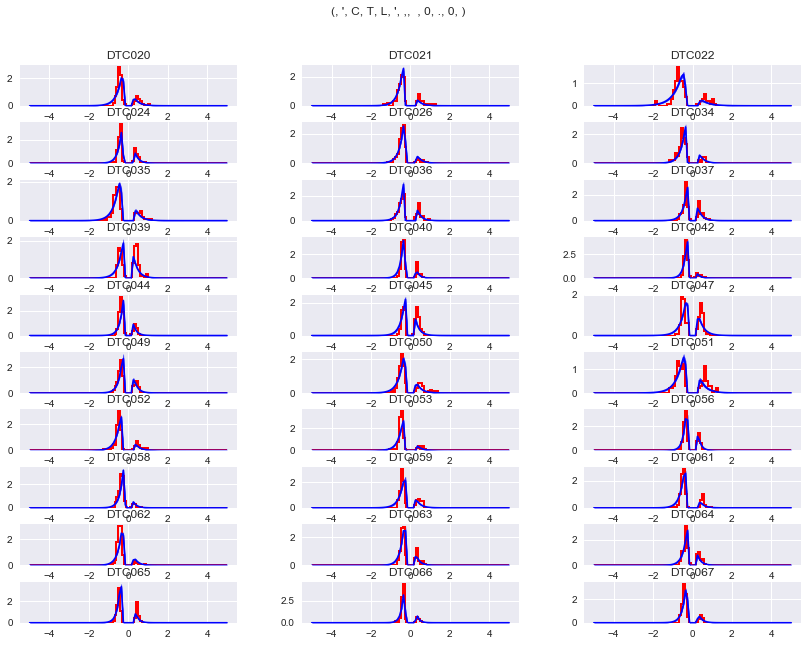

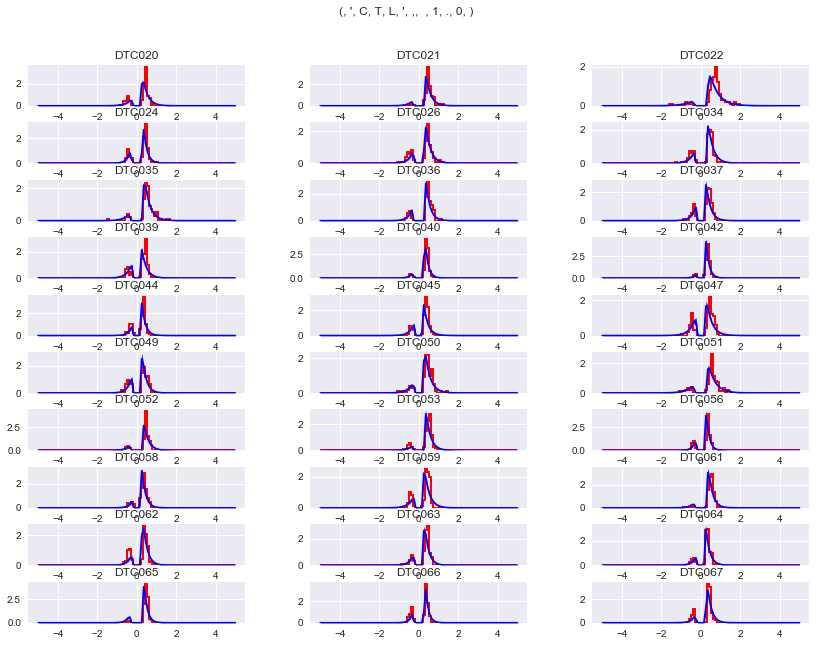

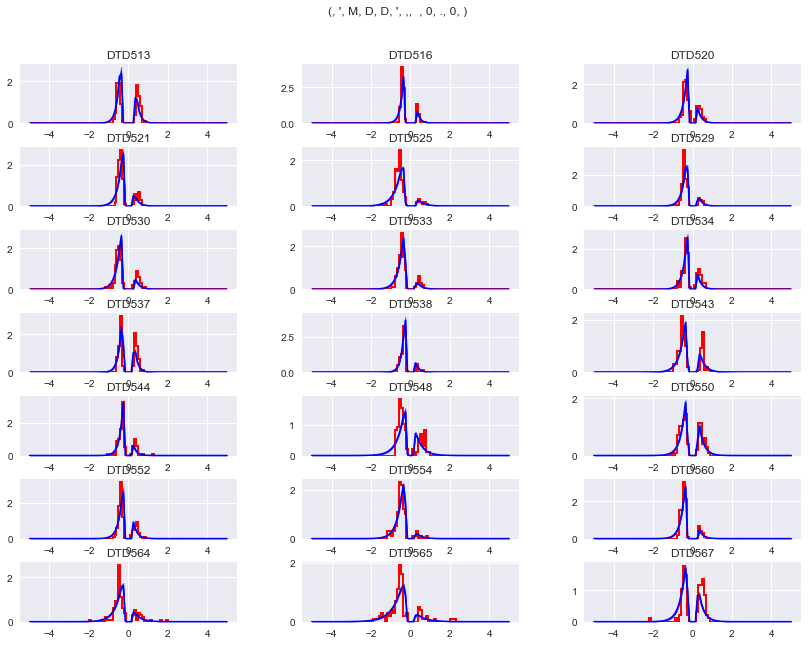

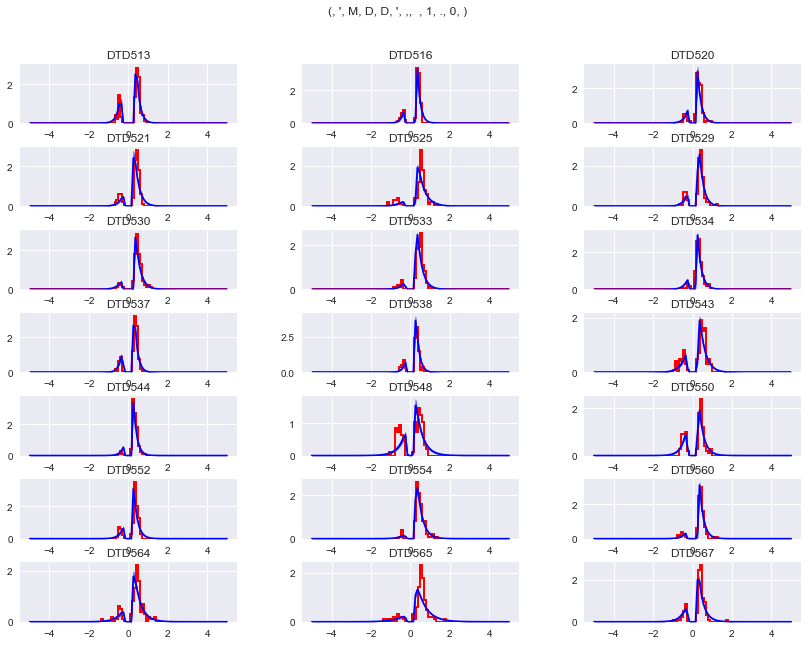

In [410]:
session2_model.plot_posterior_predictive(figsize=(14, 10))

In [391]:
session2_model.dic_info

{'DIC': -178.86387185825527,
 'deviance': -345.95528275843128,
 'pD': 167.09141090017602}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting v_std
Plotting t(CTL)
Plotting t(MDD)
Plotting t_std
Plotting z(CTL)
Plotting z(MDD)
Plotting z_std


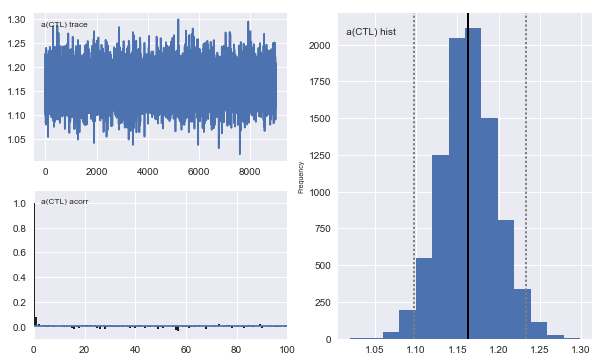

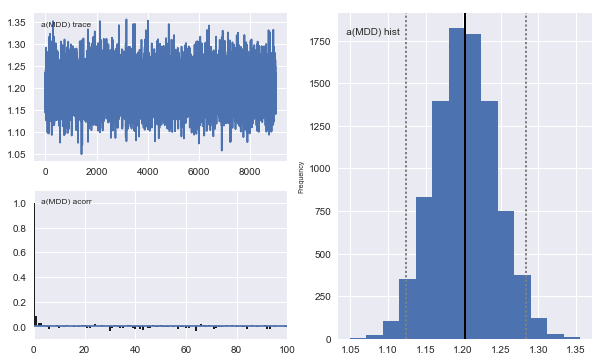

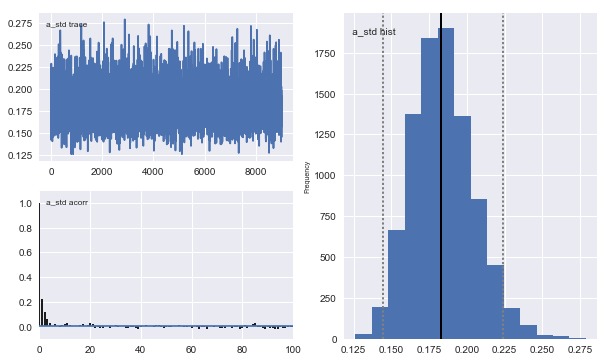

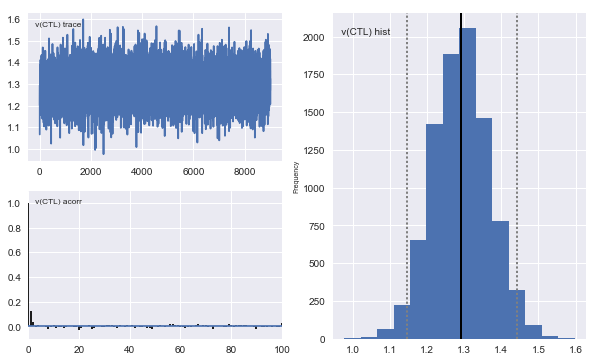

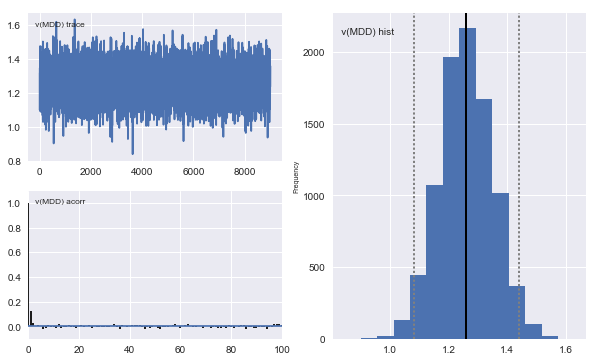

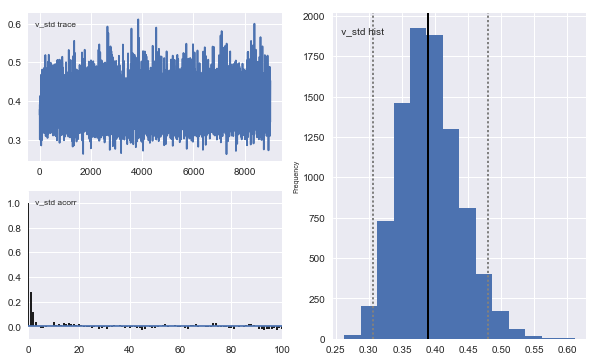

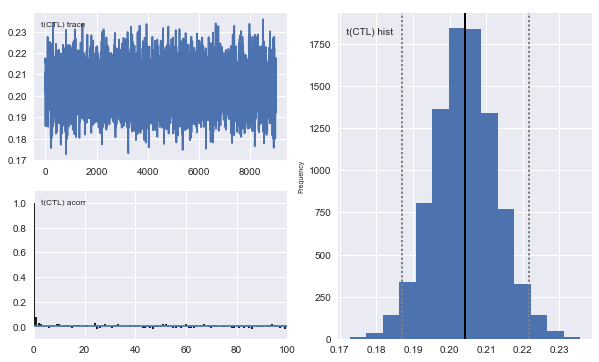

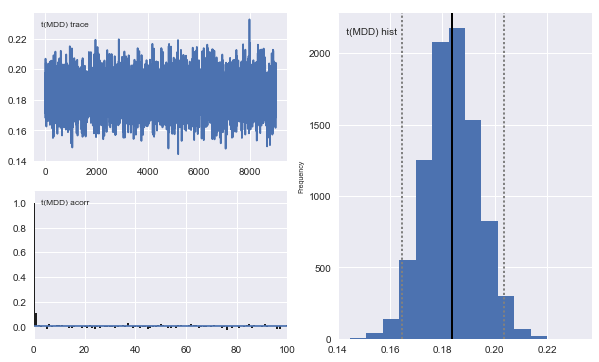

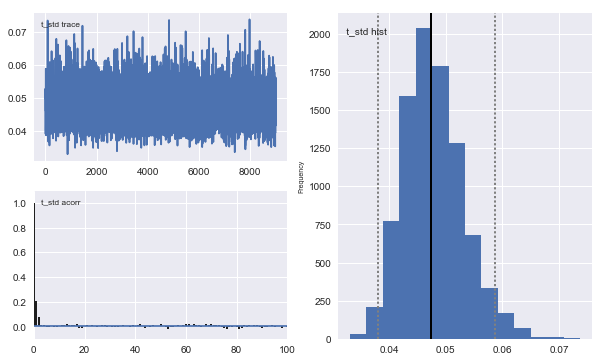

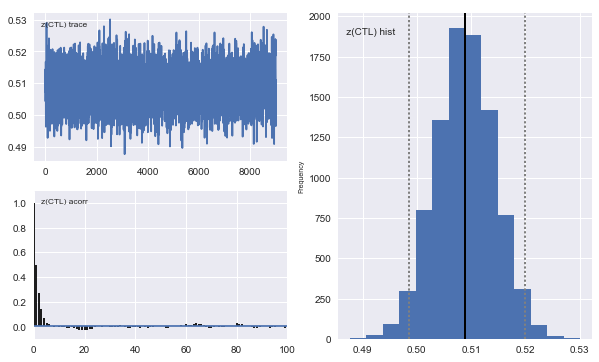

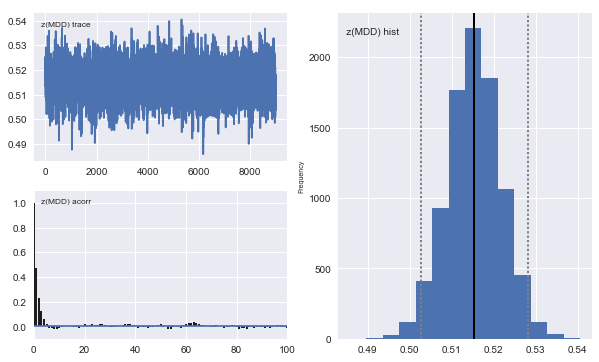

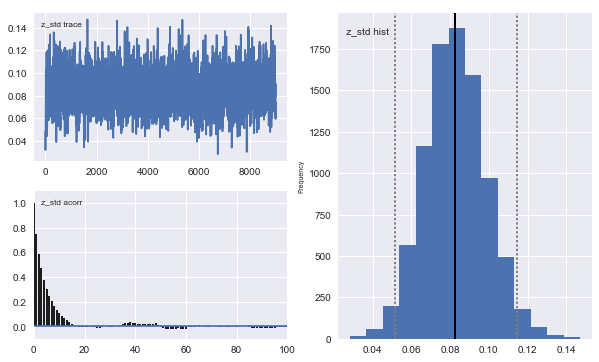

In [392]:
session2_model.plot_posteriors(['a', 't', 'v', 'z','a_std','t_std','v_std','z_std'])

P_a(MDD > CON) =  0.773888888889
P_a(CON > MDD) =  0.226111111111


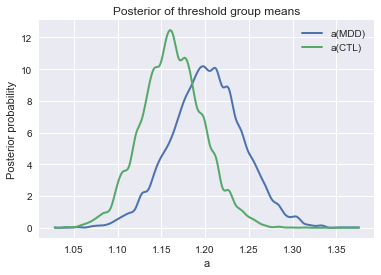

In [79]:
a_MDD, a_CON = session2_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.382
P_a(CON > MDD) =  0.618


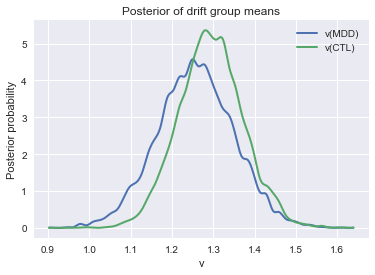

In [80]:
v_MDD, v_CON = session2_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.761666666667
P_a(CON > MDD) =  0.238333333333


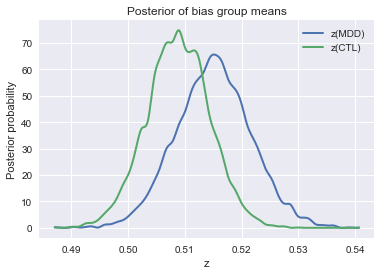

In [81]:
z_MDD, z_CON = session2_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of bias group means')

print ("P_a(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.055
P_a(CON > MDD) =  0.945


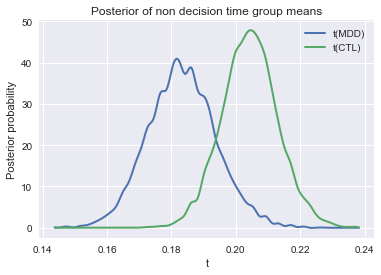

In [82]:
t_MDD, t_CON = session2_model.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means')

print ("P_a(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

**Running new model without group for later regressions**

In [397]:
session2_model_nogrp = hddm.HDDMStimCoding(data2, include='z', stim_col='stim', split_param='v')
session2_model_nogrp.find_starting_values()
session2_model_nogrp.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1325.8 sec

In [411]:
session2_model_nogrp.dic_info

{'DIC': -178.13652806768857,
 'deviance': -345.52754232914072,
 'pD': 167.39101426145214}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


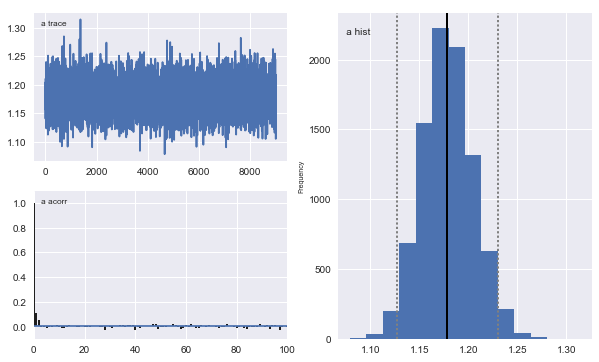

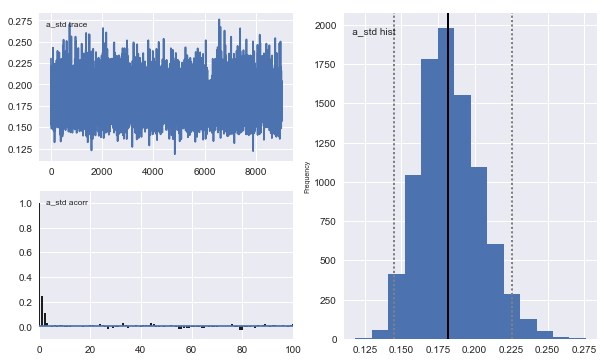

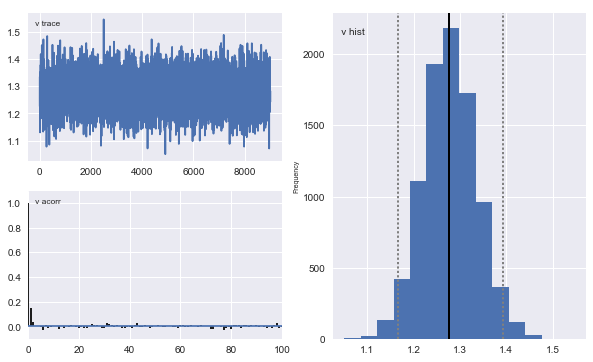

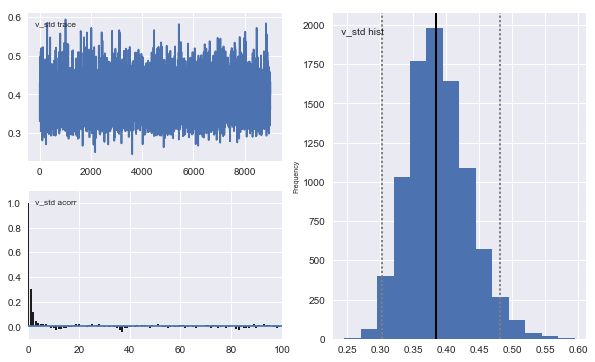

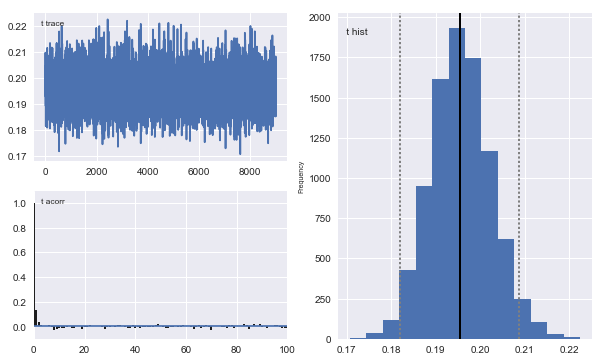

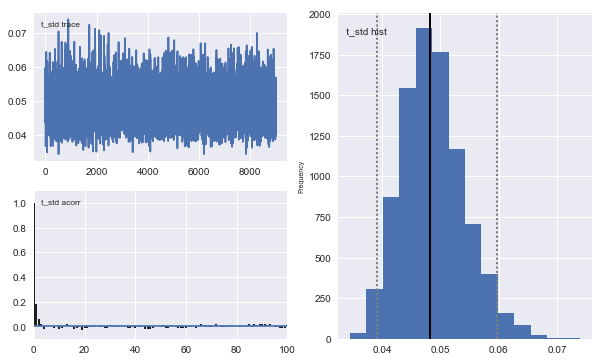

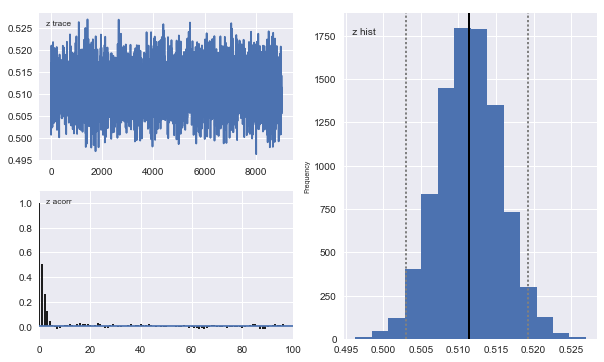

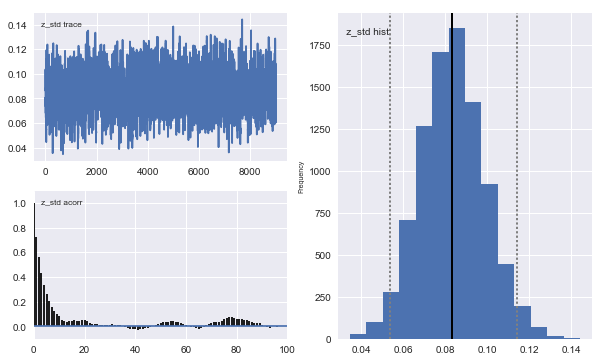

In [412]:
# autocorrelation for z_std I think is okay just needs to "drop to 0 well smaller than 50"
# we could play around with sampling more or using thin=n though if you think it's an issue

session2_model_nogrp.plot_posteriors(['a', 't', 'v', 'z','a_std','t_std','v_std','z_std'])

In [93]:
sess2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_final.csv')

In [94]:
stats = session2_model_nogrp.gen_stats()
stats.to_csv(path2data + 'session2_modelstats.csv')
stats = pd.read_csv(path2data + 'session2_modelstats.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0              a  1.178482  0.026571  1.125930  1.160520  1.178558  1.196058   
1          a_std  0.183159  0.020212  0.148428  0.168884  0.181857  0.195628   
2  a_subj.DTC020  1.239118  0.045371  1.152996  1.208055  1.237610  1.269270   
3  a_subj.DTC021  1.286527  0.053288  1.188099  1.249264  1.284032  1.320697   
4  a_subj.DTC022  1.698789  0.066698  1.574669  1.653112  1.696788  1.742557   

      97.5q    mc err  
0  1.232339  0.000311  
1  0.227088  0.000240  
2  1.331696  0.000618  
3  1.397263  0.000889  
4  1.837477  0.001040

In [95]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
sess2['subj_idx'] = sess2.subjectID.apply(lambda x: str(x))
sess2_summary = sess2.drop_duplicates('subj_idx')
reward_stats = pd.merge(reward_stats, sess2_summary, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  Unnamed: 0_x  index  \
0  a_subj.DTC020  1.239118     a   DTC020           0             0      0   
1  v_subj.DTC020  1.174534     v   DTC020           0             0      0   
2  t_subj.DTC020  0.175101     t   DTC020           0             0      0   
3  z_subj.DTC020  0.504698     z   DTC020           0             0      0   
4  a_subj.DTC021  1.286527     a   DTC021         190           200    200   

   little_due  did_reward  big_due     ...      BDI1_total  BDI2_total  \
0           0           0        0     ...             2.0         1.0   
1           0           0        0     ...             2.0         1.0   
2           0           0        0     ...             2.0         1.0   
3           0           0        0     ...             2.0         1.0   
4           0           1        0     ...             0.0         0.0   

   shaps1_total shaps2_total  pss1_total Medication Medication_Class  \
0             1            0          20          0                0   
1             1            0          20          0                0   
2             1            0          20          0                0   
3             1            0          20          0                0   
4             0            0           8          0                0   

  pss2_total  masc1_total masc2_total  
0         16           39          45  
1         16           39          45  
2         16           39          45  
3         16           39          45  
4         12           30          43  

[5 rows x 54 columns]

In [96]:
# get the data into usable form 
reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v2'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a2'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z2'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t2'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a2', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z2', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t2', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head()

to_extract   mean_v2 subj_idx  Unnamed: 0  Unnamed: 0_x  index  \
0  v_subj.DTC020  1.174534   DTC020           0             0      0   
1  v_subj.DTC021  1.529945   DTC021         190           200    200   
2  v_subj.DTC022  1.149688   DTC022         390           400    400   
3  v_subj.DTC024  1.124378   DTC024         588           800    800   
4  v_subj.DTC026  1.259442   DTC026         787          1200   1200   

   little_due  did_reward  big_due  trial    ...     shaps2_total  pss1_total  \
0           0           0        0      1    ...                0          20   
1           0           1        0      1    ...                0           8   
2           0           1        0      1    ...                0          20   
3           0           0        0      1    ...                0          19   
4           0           1        0      1    ...                0          19   

  Medication  Medication_Class pss2_total masc1_total masc2_total   mean_a2  \
0          0                 0         16          39          45  1.239118   
1          0                 0         12          30          43  1.286527   
2          0                 0         22          30          51  1.698789   
3          0                 0         10          60          61  1.014492   
4          0                 0         19          38          40  1.184698   

    mean_z2   mean_t2  
0  0.504698  0.175101  
1  0.509098  0.224901  
2  0.516389  0.242732  
3  0.498171  0.223352  
4  0.467347  0.207270  

[5 rows x 56 columns]

In [97]:
reward_stats.to_csv(path2data + 'session2_hddm_params.csv')

**ANCOVA w/ Age**

In [40]:
reward_stats2 = pd.read_csv(path2data + 'session2_hddm_params.csv')

In [42]:
%Rpush reward_stats2
%R drift.aov <- aov_ez("subjectID", dv = "mean_v2", \
                                 data = reward_stats2, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(drift.aov)

Anova Table (Type 3 tests)

Response: mean_v2
  Effect    df  MSE    F  pes p.value
1  group 1, 44 0.13 0.25 .006     .62
2    Age 5, 44 0.13 1.02  .10     .42


In [43]:
%Rpush reward_stats2
%R thresh.aov <- aov_ez("subjectID", dv = "mean_a2", \
                                 data = reward_stats2, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(thresh.aov)

Anova Table (Type 3 tests)

Response: mean_a2
  Effect    df  MSE    F  pes p.value
1  group 1, 44 0.03 0.19 .004     .66
2    Age 5, 44 0.03 1.59  .15     .18


In [44]:
%Rpush reward_stats2
%R bias.aov <- aov_ez("subjectID", dv = "mean_z2", \
                                 data = reward_stats2, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(bias.aov)

Anova Table (Type 3 tests)

Response: mean_z2
  Effect    df  MSE    F pes p.value
1  group 1, 44 0.00 0.47 .01     .50
2    Age 5, 44 0.00 0.52 .06     .76


In [45]:
%Rpush reward_stats2
%R nond.aov <- aov_ez("subjectID", dv = "mean_t2", \
                                 data = reward_stats2, covariate = "Age", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(nond.aov)

Anova Table (Type 3 tests)

Response: mean_t2
  Effect    df  MSE    F pes p.value
1  group 1, 44 0.00 2.56 .06     .12
2    Age 5, 44 0.00 1.97 .18     .10


## Relationships between HDDM parameters & standard parameters

In [422]:
# this is the model without group included
reward_stats = pd.read_csv(path2data + 'session2_hddm_params.csv')
reward_stats.groupby('group').subjectID.nunique()

group
CTL    30
MDD    21
Name: subjectID, dtype: int64


	Pearson's product-moment correlation

data:  reward_stats$mean_v2 and reward_stats$dis_adjst_all_total
t = 12.286, df = 49, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7800686 0.9233576
sample estimates:
      cor 
0.8688681 



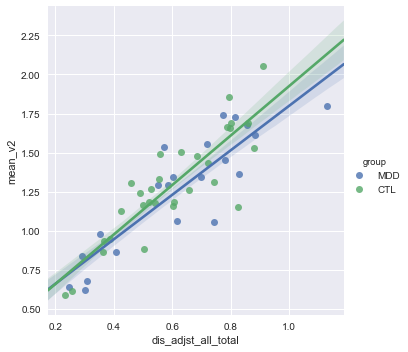

In [426]:
# disc and drift, nice

corr_param = sns.lmplot(y='mean_v2', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_v2, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a2 and reward_stats$dis_adjst_all_total
t = 2.9817, df = 49, p-value = 0.004456
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1303819 0.6024099
sample estimates:
      cor 
0.3918847 



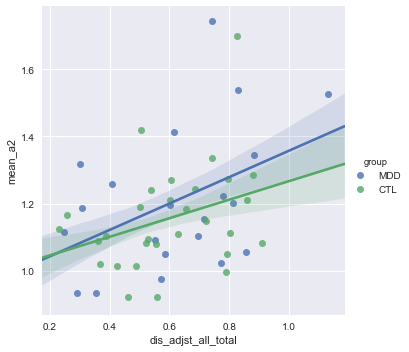

In [427]:
# disc and threshold

corr_param = sns.lmplot(y='mean_a2', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_a2, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z2 and reward_stats$dis_adjst_all_total
t = -0.67238, df = 49, p-value = 0.5045
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3616674  0.1848406
sample estimates:
        cor 
-0.09561352 



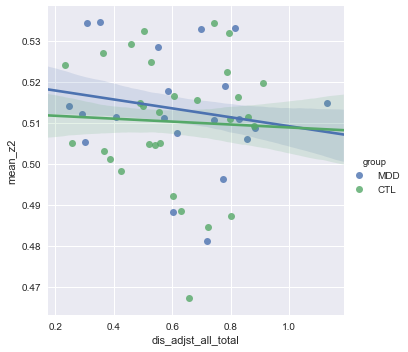

In [428]:
# disc and starting point

corr_param = sns.lmplot(y='mean_z2', x='dis_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_z2, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z2 and reward_stats$RB_adjst_all_total
t = 7.3263, df = 49, p-value = 2.075e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5587808 0.8326918
sample estimates:
      cor 
0.7230252 



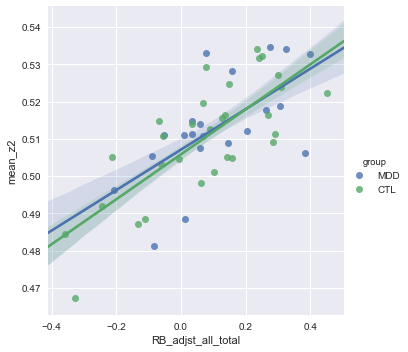

In [429]:
# RB & z, nice again

corr_param = sns.lmplot(y='mean_z2', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_z.cor <- cor.test(reward_stats$mean_z2, reward_stats$RB_adjst_all_total)
%R print(rb_z.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a2 and reward_stats$RB_adjst_all_total
t = 0.059882, df = 49, p-value = 0.9525
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2676604  0.2834696
sample estimates:
        cor 
0.008554222 



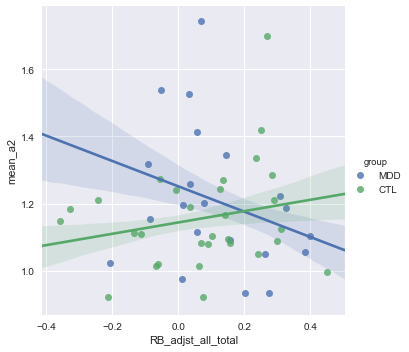

In [431]:
# RB & threshold

corr_param = sns.lmplot(y='mean_a2', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_a2, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_v2 and reward_stats$RB_adjst_all_total
t = -0.76374, df = 49, p-value = 0.4487
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3729001  0.1722704
sample estimates:
       cor 
-0.1084626 



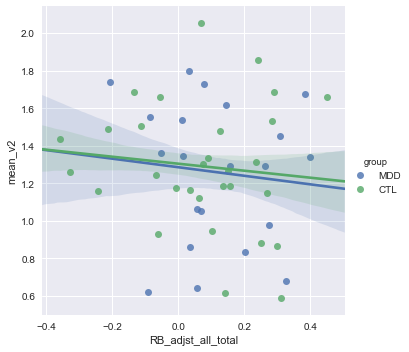

In [432]:
# RB & drift

corr_param = sns.lmplot(y='mean_v2', x='RB_adjst_all_total', hue = 'group', hue_order = ['MDD','CTL'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_v2, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)

### Regression w/ discriminability

In [434]:
# this is the model without group included group
reward_stats = pd.read_csv(path2data + 'session2_hddm_params.csv')
reward_stats = reward_stats[['subjectID', 'mean_v2', 'mean_a2', 'mean_z2']]
sess2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/session2_trial_final.csv')
sess2_summary = sess2.drop_duplicates(['subjectID','block'])
prt_params_df2 = sess2_summary.merge(reward_stats, on='subjectID')

In [435]:
%R library(lmerTest)
%Rpush prt_params_df2

# make the model with just group
%R disc_reg1.lm = lm(dis_adjst_all_block ~ block + group, data = prt_params_df2)
%R disc_reg2.lm = lm(dis_adjst_all_block ~ block*group, data=prt_params_df2)

# compare the two models: no diff so top is better
%R test_models.aov <- anova(disc_reg1.lm, disc_reg2.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group
Model 2: dis_adjst_all_block ~ block * group
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1     99 5.0499                           
2     98 5.0391  1  0.010793 0.2099 0.6479


In [437]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg3.lm = lm(dis_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: new is better
%R test_models.aov <- anova(disc_reg1.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group
Model 2: dis_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df    RSS Df Sum of Sq     F    Pr(>F)    
1     99 5.0499                                 
2     96 0.9171  3    4.1327 144.2 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [438]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg4.lm = lm(dis_adjst_all_block ~ block + group*mean_v2 + mean_a2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg4.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_v2 + mean_a2 + mean_z2
Model 2: dis_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df     RSS Df  Sum of Sq      F Pr(>F)
1     95 0.91470                            
2     96 0.91712 -1 -0.0024175 0.2511 0.6175


In [439]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg5.lm = lm(dis_adjst_all_block ~ block + group*mean_a2 + mean_v2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg5.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_a2 + mean_v2 + mean_z2
Model 2: dis_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df     RSS Df  Sum of Sq      F Pr(>F)
1     95 0.91376                            
2     96 0.91712 -1 -0.0033599 0.3493 0.5559


In [440]:
# compare model w/ parameters to simpler one from cell above

%R disc_reg6.lm = lm(dis_adjst_all_block ~ block + group*mean_z2 + mean_v2 + mean_a2, data=prt_params_df2)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(disc_reg6.lm, disc_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: dis_adjst_all_block ~ block + group * mean_z2 + mean_v2 + mean_a2
Model 2: dis_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df     RSS Df Sum of Sq      F Pr(>F)
1     95 0.90505                           
2     96 0.91712 -1 -0.012067 1.2667 0.2632


In [441]:
# print the winner
%R print(summary(disc_reg3.lm))


Call:
lm(formula = dis_adjst_all_block ~ block + group + mean_v2 + 
    mean_a2 + mean_z2, data = prt_params_df2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.264835 -0.063099 -0.005363  0.052684  0.231448 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.602966   0.348847  -1.728 0.087122 .  
block       -0.075906   0.019356  -3.922 0.000165 ***
groupMDD     0.009959   0.019977   0.499 0.619241    
mean_v2      0.532528   0.027831  19.134  < 2e-16 ***
mean_a2      0.496166   0.054708   9.069 1.49e-14 ***
mean_z2      0.117128   0.655320   0.179 0.858523    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09774 on 96 degrees of freedom
Multiple R-squared:  0.8239,	Adjusted R-squared:  0.8147 
F-statistic:  89.8 on 5 and 96 DF,  p-value: < 2.2e-16



### Regression w/ Response bias

In [442]:
%R library(lmerTest)
%Rpush prt_params_df2

# make the model with just group (need to redo after model w/ no group)
%R rb_reg1.lm = lm(RB_adjst_all_block ~ block + group, data = prt_params_df2)
%R rb_reg2.lm = lm(RB_adjst_all_block ~ block*group, data=prt_params_df2)

# compare the two models: no diff so top is better
%R test_models.aov <- anova(rb_reg1.lm, rb_reg2.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group
Model 2: RB_adjst_all_block ~ block * group
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1     99 4.7732                           
2     98 4.7629  1  0.010249 0.2109 0.6471


In [443]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg3.lm = lm(RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: new is better
%R test_models.aov <- anova(rb_reg1.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group
Model 2: RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1     99 4.7732                                  
2     96 3.0199  3    1.7533 18.578 1.391e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [444]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg4.lm = lm(RB_adjst_all_block ~ block + group*mean_v2 + mean_a2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: old is better
%R test_models.aov <- anova(rb_reg4.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_v2 + mean_a2 + mean_z2
Model 2: RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df    RSS Df  Sum of Sq      F Pr(>F)
1     95 3.0105                            
2     96 3.0199 -1 -0.0094412 0.2979 0.5865


In [445]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg5.lm = lm(RB_adjst_all_block ~ block + group*mean_a2 + mean_v2 + mean_z2, data=prt_params_df2)

# compare the new model w/ old: no difference so continue w/ 3
%R test_models.aov <- anova(rb_reg5.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_a2 + mean_v2 + mean_z2
Model 2: RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df    RSS Df Sum of Sq     F  Pr(>F)  
1     95 2.9300                             
2     96 3.0199 -1 -0.089904 2.915 0.09103 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [446]:
# compare model w/ parameters to simpler one from cell above

%R rb_reg6.lm = lm(RB_adjst_all_block ~ block + group*mean_z2 + mean_v2 + mean_a2, data=prt_params_df2)

# compare the new model w/ old: old is the winner
%R test_models.aov <- anova(rb_reg6.lm, rb_reg3.lm)
%R print(test_models.aov)

Analysis of Variance Table

Model 1: RB_adjst_all_block ~ block + group * mean_z2 + mean_v2 + mean_a2
Model 2: RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + mean_z2
  Res.Df    RSS Df Sum of Sq     F Pr(>F)
1     95 2.9851                          
2     96 3.0199 -1 -0.034817 1.108 0.2952


In [447]:
# print the winner
%R print(summary(rb_reg3.lm))


Call:
lm(formula = RB_adjst_all_block ~ block + group + mean_v2 + mean_a2 + 
    mean_z2, data = prt_params_df2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46491 -0.11235  0.01082  0.10637  0.59534 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.4262358  0.6330220  -6.992 3.60e-10 ***
block        0.0122782  0.0351229   0.350    0.727    
groupMDD     0.0125314  0.0362508   0.346    0.730    
mean_v2     -0.0087742  0.0505024  -0.174    0.862    
mean_a2     -0.0001961  0.0992741  -0.002    0.998    
mean_z2      8.8076881  1.1891513   7.407 5.01e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1774 on 96 degrees of freedom
Multiple R-squared:  0.3728,	Adjusted R-squared:  0.3401 
F-statistic: 11.41 on 5 and 96 DF,  p-value: 1.176e-08



# HDDM Stability

In [47]:
# models without group
sess1_params = pd.read_csv(path2data + 'session1_hddm_params.csv')
sess2_params = pd.read_csv(path2data + 'session2_hddm_params.csv')

In [48]:
all_params = pd.merge(sess1_params[['subj_idx','mean_v', 'mean_z', 'mean_a', 'mean_t']], \
                      sess2_params, on= 'subj_idx')


	Pearson's product-moment correlation

data:  all_params$mean_v and all_params$mean_v2
t = 2.6996, df = 45, p-value = 0.009744
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09652226 0.59655077
sample estimates:
      cor 
0.3733408 



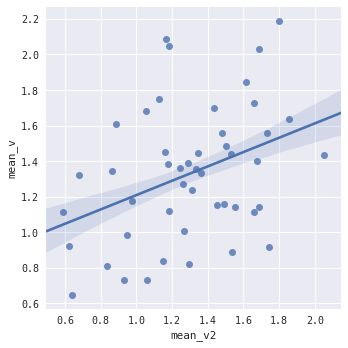

In [306]:
# drift rate correlation
corr_param = sns.lmplot(y='mean_v', \
                        x = 'mean_v2', data=all_params,ci=68, \
                        units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_v,all_params$mean_v2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_a and all_params$mean_a2
t = 2.6724, df = 45, p-value = 0.01045
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09278654 0.59411727
sample estimates:
      cor 
0.3700922 



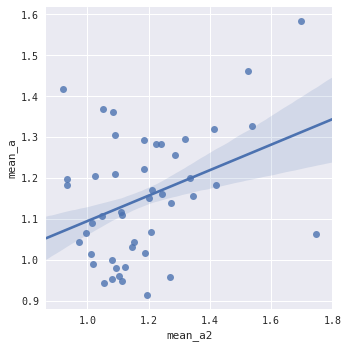

In [307]:
# threshold correlation
corr_param = sns.lmplot(y='mean_a', \
                        x = 'mean_a2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_a,all_params$mean_a2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_z and all_params$mean_z2
t = -0.73151, df = 45, p-value = 0.4683
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3836289  0.1845060
sample estimates:
       cor 
-0.1084045 



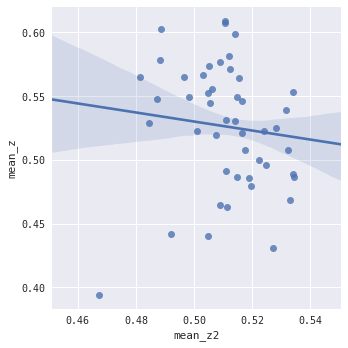

In [308]:
# Starting point bias correlation
corr_param = sns.lmplot(y='mean_z', \
                        x = 'mean_z2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_z,all_params$mean_z2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_t and all_params$mean_t2
t = -0.55225, df = 45, p-value = 0.5835
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3607143  0.2100700
sample estimates:
       cor 
-0.0820463 



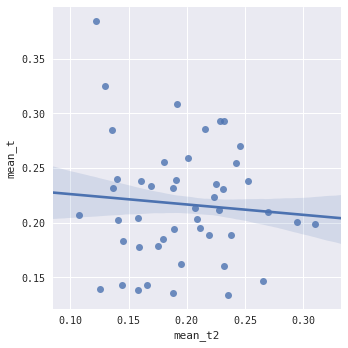

In [309]:
# non-decision time correlation
corr_param = sns.lmplot(y='mean_t', \
                        x = 'mean_t2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_t,all_params$mean_t2,method="pearson")
%R print (rl_disc.cor)

**Group x Time x Parameter**

In [49]:
all_params2 = all_params[["subj_idx","mean_v","mean_v2","mean_a","mean_a2","mean_z",'mean_z2','mean_t','mean_t2']]
melted = pd.melt(all_params2, id_vars=["subj_idx"], 
                 var_name="parameter", value_name="value")

In [50]:
new = {'mean_a': "mean_a1", 'mean_v': "mean_v1",'mean_z':'mean_z1','mean_t':'mean_t1'}
melted['parameter'].replace(new, inplace=True)
melted['time'] = melted.parameter.apply(lambda x: x[6])
melted['parameter'] = melted.parameter.apply(lambda x: x[5])
melted.head()

subj_idx parameter     value time
0   DTC020         v  1.381627    1
1   DTC021         v  1.439893    1
2   DTC022         v  0.836511    1
3   DTC024         v  1.750654    1
4   DTC026         v  1.272939    1

In [52]:
melted.tail()

subj_idx parameter     value time
371   DTD554         t  0.158423    2
372   DTD560         t  0.228729    2
373   DTD564         t  0.125083    2
374   DTD565         t  0.107601    2
375   DTD567         t  0.188985    2

In [55]:
data1_standard['subj_idx'] = data1_standard.subjectID
melted = melted.merge(data1_standard[['subj_idx','group']], on='subj_idx')

In [56]:
melted.head()

subj_idx parameter     value time group
0   DTC020         v  1.381627    1   CTL
1   DTC020         v  1.174534    2   CTL
2   DTC020         a  1.284002    1   CTL
3   DTC020         a  1.239118    2   CTL
4   DTC020         z  0.440410    1   CTL

In [57]:
melted.tail()

subj_idx parameter     value time group
371   DTD567         a  1.186470    2   MDD
372   DTD567         z  0.489171    1   MDD
373   DTD567         z  0.534185    2   MDD
374   DTD567         t  0.194127    1   MDD
375   DTD567         t  0.188985    2   MDD

In [248]:
%Rpush melted
%R rb.aov <- aov_ez("subj_idx", dv = "value", \
                                 data = melted, within = c("time","parameter"), \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: value
                Effect          df  MSE          F  pes p.value
1                group       1, 45 0.06       0.30 .007     .58
2                 time       1, 45 0.02       0.18 .004     .67
3           group:time       1, 45 0.02       0.68  .01     .42
4            parameter 1.40, 62.80 0.12 460.91 ***  .91  <.0001
5      group:parameter 1.40, 62.80 0.12       1.84  .04     .18
6       time:parameter 1.35, 60.91 0.06       0.47  .01     .55
7 group:time:parameter 1.35, 60.91 0.06       0.98  .02     .35

Sphericity correction method: GG 


## Exploratory correlations betweeen clinical measures and HDDM parameters in MDDs

This is based on model without group included.

In [146]:
data1 = pd.read_csv(path2data + 'session1_hddm_params.csv')
data1_standard = data1.drop_duplicates('subjectID')

In [147]:
data1_standard['pss1_total'] = pd.to_numeric(data1_standard.pss1_total, errors='coerce')
data1_standard['BDI1_total'] = pd.to_numeric(data1_standard.BDI1_total, errors='coerce')
data1_standard['shaps1_total'] = pd.to_numeric(data1_standard.shaps1_total, errors='coerce')
data1_standard['masc1_total'] = pd.to_numeric(data1_standard.masc1_total, errors='coerce')

In [185]:
%%R
flattenCorrMatrix <- function(cormat, pmat) {
  ut <- upper.tri(cormat)
  data.frame(
    row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut],
    p = pmat[ut]
    )
}

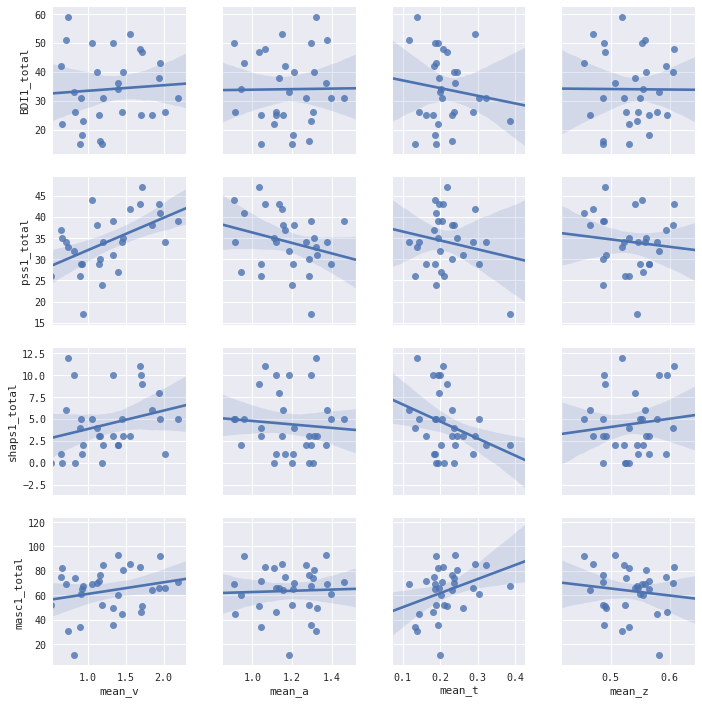

In [196]:
data1_standard_mdds = data1_standard[data1_standard.group == 'MDD']
g = sns.pairplot(data1_standard_mdds,
                  x_vars=["mean_v", "mean_a","mean_t", 'mean_z'],
                  y_vars=['BDI1_total','pss1_total','shaps1_total','masc1_total'], dropna=True, kind='reg')
plt.show()

In [197]:
%R library("Hmisc")

%Rpush data1_standard_mdds
%R res2 <- rcorr(as.matrix(data1_standard_mdds[c("mean_v","mean_a", "mean_t","mean_z",'BDI1_total','pss1_total','shaps1_total','masc1_total')]))
%R res2$P=round(res2$P,3)
%R flattenCorrMatrix(res2$r, res2$P)[7:28,]

row        column       cor      p
7         mean_v    BDI1_total  0.069245  0.716
8         mean_a    BDI1_total  0.011313  0.953
9         mean_t    BDI1_total -0.126171  0.506
10        mean_z    BDI1_total -0.006065  0.975
11        mean_v    pss1_total  0.516147  0.004
12        mean_a    pss1_total -0.268303  0.159
13        mean_t    pss1_total -0.183342  0.341
14        mean_z    pss1_total -0.109717  0.571
15    BDI1_total    pss1_total  0.650381  0.000
16        mean_v  shaps1_total  0.271886  0.132
17        mean_a  shaps1_total -0.083186  0.651
18        mean_t  shaps1_total -0.317553  0.077
19        mean_z  shaps1_total  0.114498  0.533
20    BDI1_total  shaps1_total  0.533861  0.002
21    pss1_total  shaps1_total  0.494158  0.006
22        mean_v   masc1_total  0.228063  0.209
23        mean_a   masc1_total  0.039016  0.832
24        mean_t   masc1_total  0.348955  0.050
25        mean_z   masc1_total -0.128496  0.483
26    BDI1_total   masc1_total  0.052776  0.782
27    pss1_total   masc1_total  0.265190  0.164
28  shaps1_total   masc1_total -0.463670  0.008

## Hierarchical linear modeling to predict slope of change in clinical variables

See if the HDDM parameters (or the standard PRT variables) predict the slope of change in BDI/SHAPS/MASC scores (there is also a clinician-rated depression variable that can be analyzed—Randy will send us the name of that variable). The idea here is that pre-post change scores are fairly coarse, and these participants completed self-report measures at multiple times so we might be able to pick up more signal looking at slope. Hierarchical linear modeling is the way to go here (because subjects are nested within time).

**Primary:** (i) self-report depression symptoms (bditot_i, bditot_1,…bditot_12, bditot_post; weekly assessments of depressive symptoms) and (ii) clinician rated depression (4 times: cdrs_raw_i, cdrsT_i, cdrs_raw_1, cdrsT_1, … cdrs_raw_3/cdrsT_3)
 
**Secondary:** (i) self-report anxious symptoms (masc_tot_i, masc_tot_1,…masc_tot_12); (ii) self-report anhedonia symptoms (shapstot_i, shapstot_1…shapstot_5)

# PAD: Test-retest data from healthy adolescents aged 12-14  
Looking at reliability of signal detection and DDM variables in PAD data.  
  
**Naming convention:**  
Low risk girls = 200  
Low risk boys = 400  
High risk girls = 800  
High risk boys = 600

### Data Prep

In [58]:
# get the initial files together in 1 df
dfs = []
files = (glob.glob(path2data + '/PAD/Initial/sigdet_output*.txt'))
for file in files:
    df = SigDetParse(file)
    dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out.head(10)
out.rename(columns={'Subject':'subject', 'Session':'session', 'Short_Key':'short_key', 
                    'Long_Key':'long_key', 'Bias':'bias'}, inplace=True)
out.session = 1
out.to_csv(path2data + 'PAD_initial_trial_all.csv')

In [59]:
# get the 6 month follow up together in another df
dfs = []
files = (glob.glob(path2data + 'PAD/FU6/sigdet_output*.txt'))
for file in files:
    df = SigDetParse_v2(file)
    dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out.head(10)
out.rename(columns={'Subject':'subject', 'Session':'session', 'Short_Key':'short_key', 
                    'Long_Key':'long_key', 'Bias':'bias'}, inplace=True)
out.session = 2
out.to_csv(path2data + 'PAD_FU_trial_all.csv')

## Session 1

In [70]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'PAD_initial_trial_all.csv')
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [71]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1

cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is >/< 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1
data.loc[(data.ln_rt < (data.mean_ln_rt-3*data.ln_std)), 'outlier'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [72]:
data.subject.unique()

array([200, 201, 203, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 222, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 234, 235, 237, 239, 244, 245, 247, 248, 249, 250, 251, 253,
       254, 255, 256, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269,
       270, 271, 273, 275, 276, 400, 401, 402, 404, 405, 410, 412, 413,
       414, 415, 416, 417, 418, 420, 421, 422, 423, 424, 426, 427, 429,
       431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 602, 603, 604,
       605, 607, 608, 609, 610, 612, 800, 801, 803, 805, 806, 807, 808,
       809, 810, 813, 815, 816, 817, 818, 819, 820, 822])

In [73]:
data.rl_stim.unique()

array(['rich_stim', 'lean_stim'], dtype=object)

In [74]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
data.subject = data.subject.apply(lambda x: str(x))
cleandata = data[data.outlier == 0]
data['outlier_sub'] = 0
for subject in data.subject.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'rich_stim') & (cleandata.block == block)].did_reward.sum()
        nleanrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'lean_stim') & (cleandata.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew
        
        numcorrect = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.sum()
        count = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.count()
        accuracy = (numcorrect/count) 
        
        if ratio < 2.5:
            print ('Subject ' + str(subject) + ' was excluded for having a low reward ratio')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        
        if noutliers > 20:
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif accuracy < (.4):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # low accuracy
            print('Subject ' + str(subject) + ' was excluded for low overall accuracy')


Subject 203 was excluded for having more than 20 outlier trials
Subject 218 was excluded for having more than 20 outlier trials
Subject 222 was excluded for having more than 20 outlier trials
Subject 224 was excluded for having too few rich rewarded trials
Subject 229 was excluded for having a low reward ratio
Subject 229 was excluded for having too few rich rewarded trials
Subject 229 was excluded for having a low reward ratio
Subject 229 was excluded for having too few rich rewarded trials
Subject 231 was excluded for having more than 20 outlier trials
Subject 231 was excluded for having more than 20 outlier trials
Subject 245 was excluded for having a low reward ratio
Subject 245 was excluded for having more than 20 outlier trials
Subject 245 was excluded for having a low reward ratio
Subject 245 was excluded for having more than 20 outlier trials
Subject 247 was excluded for having a low reward ratio
Subject 247 was excluded for having more than 20 outlier trials
Subject 247 was ex

In [77]:
# print the subjects that were excluded in an easier to read format
data.loc[data.outlier_sub ==1].subject.unique()

array(['203', '218', '222', '224', '229', '231', '245', '247', '253',
       '254', '259', '266', '405', '410', '413', '414', '420', '424',
       '435', '436', '437', '609', '807'], dtype=object)

In [78]:
data['rwdct'] = 0
cleandata = data[data.outlier == 0]
for subject in data.subject.unique():
    reward = cleandata.loc[cleandata.subject == subject].did_reward.sum()
    data.loc[data.subject == subject, 'rwdct'] = reward 

In [80]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
data.subject.nunique() 

91

In [95]:
# how many left in each group
data.group = data.subject
data.group = data.group.apply(lambda x: x[0])
data.group.replace({'2': 'LR','4':'LR','8':'HR','6':'HR'},inplace=True)
data.groupby('group').subject.nunique()

group
HR    24
LR    67
Name: subject, dtype: int64

### Calculate RB & Discriminability

In [96]:
def calc_rb(subject, data):
    '''Given a subject and dataframe, returns the discriminability and response bias for the subject'''
    rh_correct = data[(data.subject == subject) & (data.rl_stim == 'rich_stim')].correct.sum() + .5
    rh_incorrect = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.correct == 0)].correct.count() + .5
    ln_correct = data[(data.subject == subject) & (data.rl_stim == 'lean_stim')].correct.sum() + .5
    ln_incorrect = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.correct == 0)].correct.count() + .5
    
    rb = .5 * np.log10((rh_correct * ln_incorrect)/(rh_incorrect * ln_correct))
    disc = .5 * np.log10((rh_correct * ln_correct)/(rh_incorrect * ln_incorrect))
    
    return(rb, disc)

In [97]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [98]:
data.head()

index    rt  did_reward  little_due length key_press  reward_due  big_due  \
0      0  1826           0           0  short         c           0        0   
1      1   662           1           0   long         m           1        0   
2      2   705           0           1  short         m           1        0   
3      3   529           0           1   long         c           0        0   
4      4   482           0           1  short         m           1        0   

   trial  correct      ...       outlier mean_ln_rt    ln_std outlier_sub  \
0      1        1      ...             0   6.181892  0.484481           0   
1      2        1      ...             0   6.181892  0.484481           0   
2      3        0      ...             0   6.181892  0.484481           0   
3      4        0      ...             0   6.181892  0.484481           0   
4      5        0      ...             0   6.181892  0.484481           0   

   rwdct RB_adjst_all_total dis_adjst_all_total RB_adjst_all_block  \
0     79           0.119377            0.687306           0.212326   
1     79           0.119377            0.687306           0.212326   
2     79           0.119377            0.687306           0.212326   
3     79           0.119377            0.687306           0.212326   
4     79           0.119377            0.687306           0.212326   

  dis_adjst_all_block RB_b2_minus_b1  
0             0.61325      -0.212326  
1             0.61325      -0.212326  
2             0.61325      -0.212326  
3             0.61325      -0.212326  
4             0.61325      -0.212326  

[5 rows x 33 columns]

In [99]:
data.tail()

index   rt  did_reward  little_due length key_press  reward_due  \
22794  22794  448           1           0   long         c           1   
22795  22795  378           0           0  short         m           0   
22796  22796  391           0           0   long         m           0   
22797  22797  355           0           0   long         c           0   
22798  22798  418           0           0  short         c           0   

       big_due  trial  correct      ...       outlier mean_ln_rt    ln_std  \
22794        0    195        1      ...             0   6.181892  0.484481   
22795        0    196        1      ...             0   6.181892  0.484481   
22796        0    197        0      ...             0   6.181892  0.484481   
22797        0    198        1      ...             0   6.181892  0.484481   
22798        0    199        0      ...             0   6.181892  0.484481   

      outlier_sub  rwdct RB_adjst_all_total dis_adjst_all_total  \
22794           0     80           0.002895            0.485886   
22795           0     80           0.002895            0.485886   
22796           0     80           0.002895            0.485886   
22797           0     80           0.002895            0.485886   
22798           0     80           0.002895            0.485886   

      RB_adjst_all_block dis_adjst_all_block RB_b2_minus_b1  
22794           0.060441            0.525824       0.110287  
22795           0.060441            0.525824       0.110287  
22796           0.060441            0.525824       0.110287  
22797           0.060441            0.525824       0.110287  
22798           0.060441            0.525824       0.110287  

[5 rows x 33 columns]

In [100]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/PAD_session1_trial_clean.csv')

### Standard Analysis—Time 1

Only low risk kids developed a response bias

In [6]:
pad_data = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/PAD_session1_trial_clean.csv')
pad_data_standard = pad_data.drop_duplicates('subject')

In [104]:
pad_data.groupby('group').subject.nunique()

group
HR    24
LR    67
Name: subject, dtype: int64

In [106]:
pad_data_HR = pad_data_standard.loc[pad_data_standard.group == 'HR']

%Rpush pad_data_HR
%R rb.test <- t.test(pad_data_HR$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  pad_data_HD$RB_adjst_all_block
t = 0.62259, df = 23, p-value = 0.2698
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 -0.04059242         Inf
sample estimates:
 mean of x 
0.02315825 



In [107]:
pad_data_LR = pad_data_standard.loc[pad_data_standard.group == 'LR']

%Rpush pad_data_LR
%R rb.test <- t.test(pad_data_LR$RB_adjst_all_block, mu=0, alternative="greater")
%R print (rb.test)


	One Sample t-test

data:  pad_data_LR$RB_adjst_all_block
t = 1.7601, df = 66, p-value = 0.04151
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.002420715         Inf
sample estimates:
 mean of x 
0.04639517 



RB increases over the blocks

Anova Table (Type 3 tests)

Response: RB_adjst_all_block
       Effect    df  MSE      F  pes p.value
1       group 1, 89 0.06   0.99  .01     .32
2       block 1, 89 0.02 6.89 *  .07     .01
3 group:block 1, 89 0.02   0.46 .005     .50

Sphericity correction method: GG 


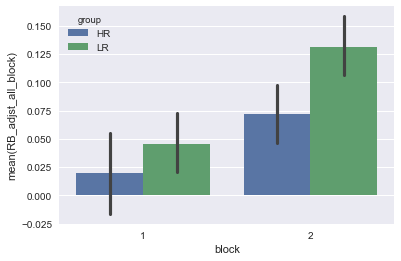

In [110]:
total_rb_plot = sns.barplot(y='RB_adjst_all_block', x = 'block', hue = 'group',hue_order = ['HR','LR'], data = pad_data, units='subject', ci=68)

%Rpush pad_data
%R rb.aov <- aov_ez("subject", dv = "RB_adjst_all_block", \
                                 data = pad_data, within = "block", \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

In [112]:
# print means
pad_data.groupby(['group','block']).RB_adjst_all_block.mean()

group  block
HR     1        0.020115
       2        0.072336
LR     1        0.045203
       2        0.130799
Name: RB_adjst_all_block, dtype: float64

Block 2 - block1 

Anova Table (Type 3 tests)

Response: RB_b2_minus_b1
  Effect    df  MSE    F  pes p.value
1  group 1, 89 0.05 0.46 .005     .50


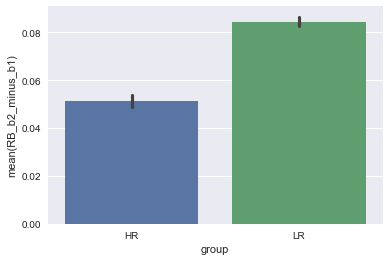

In [114]:
total_rb_plot = sns.barplot(y='RB_b2_minus_b1', x = 'group', x_order = ['HR','LR'], \
                            data = pad_data, units='subjectID', ci=68)
%Rpush pad_data
%R rb.aov <- aov_ez("subject", dv = "RB_b2_minus_b1", \
                                 data = pad_data, between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: dis_adjst_all_block
       Effect    df  MSE    F   pes p.value
1       group 1, 89 0.09 0.47  .005     .50
2       block 1, 89 0.02 0.01 .0001     .92
3 group:block 1, 89 0.02 2.31   .03     .13

Sphericity correction method: GG 


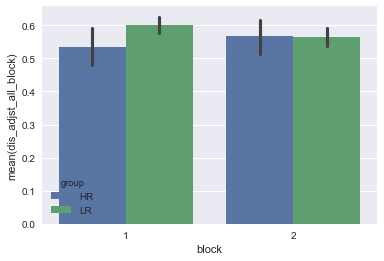

In [115]:
plot = sns.barplot(y='dis_adjst_all_block', x = 'block', 
                                   data = pad_data, hue = 'group',ci=68, hue_order = ['HR','LR'],units= 'subject')
%Rpush pad_data
%R discriminability.aov <- aov_ez("subject", dv = "dis_adjst_all_block", \
                                 data = pad_data, within = 'block',\
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print (discriminability.aov)

**No relationship between RB & disc**


	Pearson's product-moment correlation

data:  pad_data_standard$dis_adjst_all_total and pad_data_standard$RB_adjst_all_total
t = -1.4183, df = 89, p-value = 0.1596
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.34408218  0.05908126
sample estimates:
       cor 
-0.1486726 



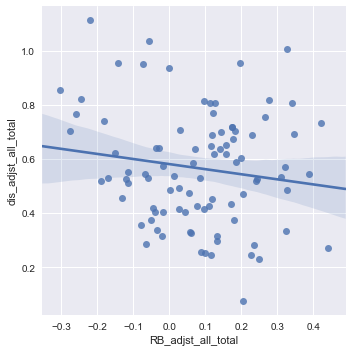

In [117]:
sns.lmplot(x="RB_adjst_all_total", y="dis_adjst_all_total", data=pad_data_standard, units = 'subject')

%Rpush pad_data_standard
%R disc_rb.cor <- cor.test(pad_data_standard$dis_adjst_all_total,pad_data_standard$RB_adjst_all_total,method='pearson')
%R print(disc_rb.cor)

RT  
No significant effect of group but the trend looks like the opposite of what we'd expect

Anova Table (Type 3 tests)

Response: ln_rt
       Effect    df  MSE    F   pes p.value
1       group 1, 89 0.12 2.34   .03     .13
2       block 1, 89 0.01 0.01 .0001     .92
3 group:block 1, 89 0.01 2.68   .03     .11

Sphericity correction method: GG 


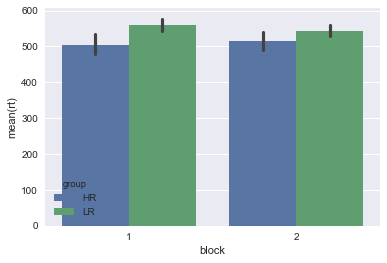

In [119]:
rt_plot = sns.barplot(y='rt', x = 'block', hue = 'group', hue_order = ['HR','LR'],data=pad_data,  \
                      ci=68, units = 'subject')

%Rpush pad_data
%R rt.aov <- aov_ez("subject", dv = "ln_rt", \
                                 data = pad_data, within = 'block',\
                                 between = 'group',anova_table=list(correction="GG", es = "pes"))
%R print (rt.aov)

#### Rewards Recieved

Discriminability, but not RB, is not associated with cumulative reward. These correlations differ.


	Pearson's product-moment correlation

data:  pad_data_standard$rwdct and pad_data_standard$RB_adjst_all_total
t = 0.50917, df = 89, p-value = 0.6119
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1537575  0.2569864
sample estimates:
       cor 
0.05389393 



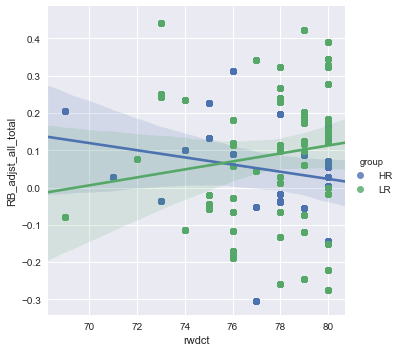

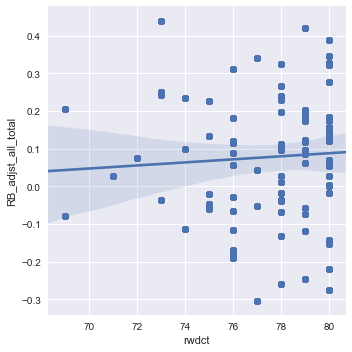

In [121]:
sns.lmplot(x="rwdct", y="RB_adjst_all_total", data=pad_data, hue = 'group',hue_order = ['HR','LR'],units = 'subject')
sns.lmplot(x="rwdct", y="RB_adjst_all_total", data=pad_data, units = 'subject')

%Rpush pad_data_standard
%R rb_rwdct <- cor.test(pad_data_standard$rwdct,pad_data_standard$RB_adjst_all_total,method="pearson")
%R print (rb_rwdct)


	Pearson's product-moment correlation

data:  pad_data_standard$rwdct and pad_data_standard$dis_adjst_all_total
t = 6.5253, df = 89, p-value = 4.031e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.411078 0.693555
sample estimates:
      cor 
0.5688632 



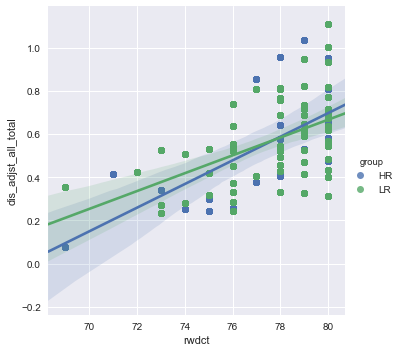

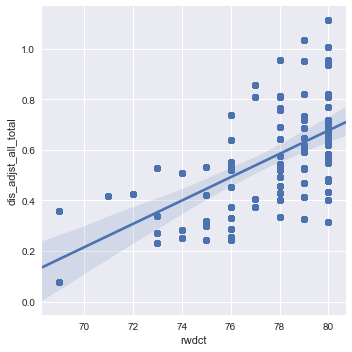

In [123]:
sns.lmplot(x="rwdct", y="dis_adjst_all_total", data=pad_data, hue = 'group', hue_order = ['HR','LR'], units = 'subject');
sns.lmplot(x="rwdct", y="dis_adjst_all_total", data=pad_data, units = 'subject');


%Rpush pad_data_standard
%R disc_rwdct <- cor.test(pad_data_standard$rwdct,pad_data_standard$dis_adjst_all_total,method="pearson")
%R print (disc_rwdct)

In [124]:
# these correlations differ
%Rpush pad_data_standard
%R compare_corr <- cocor (~ rwdct + dis_adjst_all_total | rwdct + RB_adjst_all_total,\
                          pad_data_standard)
%R print(compare_corr)


  Results of a comparison of two overlapping correlations based on dependent groups

Comparison between r.jk (rwdct, dis_adjst_all_total) = 0.5689 and r.jh (rwdct, RB_adjst_all_total) = 0.0539
Difference: r.jk - r.jh = 0.515
Related correlation: r.kh = -0.1487
Data: pad_data_standard: j = rwdct, k = dis_adjst_all_total, h = RB_adjst_all_total
Group size: n = 91
Null hypothesis: r.jk is equal to r.jh
Alternative hypothesis: r.jk is not equal to r.jh (two-sided)
Alpha: 0.05

pearson1898: Pearson and Filon's z (1898)
  z = 3.7992, p-value = 0.0001
  Null hypothesis rejected

hotelling1940: Hotelling's t (1940)
  t = 3.9328, df = 88, p-value = 0.0002
  Null hypothesis rejected

williams1959: Williams' t (1959)
  t = 3.7297, df = 88, p-value = 0.0003
  Null hypothesis rejected

olkin1967: Olkin's z (1967)
  z = 3.7992, p-value = 0.0001
  Null hypothesis rejected

dunn1969: Dunn and Clark's z (1969)
  z = 3.6402, p-value = 0.0003
  Null hypothesis rejected

hendrickson1970: Hendrickson, Sta

## RT Distributions

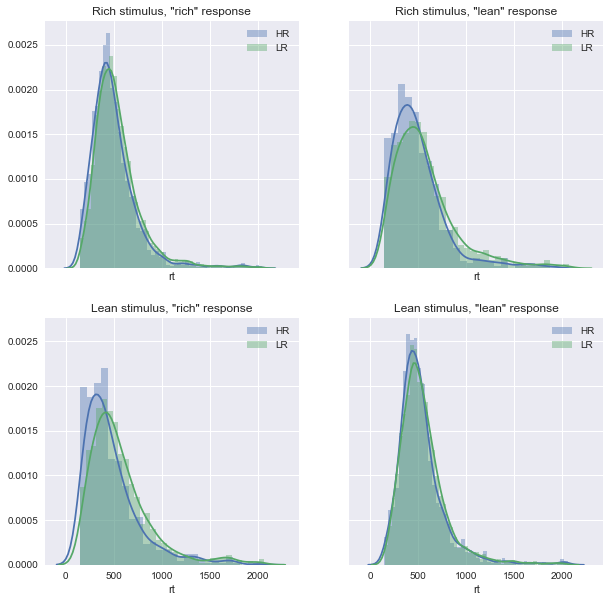

In [128]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))

# Rich stimulus
sns.distplot(pad_data[(pad_data.group == 'HR') & (pad_data.rl_stim == 'rich_stim') & (pad_data.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax1,label='HR')
sns.distplot(pad_data[(pad_data.group == 'LR') & (pad_data.rl_stim == 'rich_stim') & (pad_data.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax1,label='LR')
ax1.set_title('Rich stimulus, "rich" response')
ax1.legend()

sns.distplot(pad_data[(pad_data.group == 'HR') & (pad_data.rl_stim == 'rich_stim') & (pad_data.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax2,label='HR')
sns.distplot(pad_data[(pad_data.group == 'LR') & (pad_data.rl_stim == 'rich_stim') & (pad_data.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax2,label='LR')
ax2.set_title('Rich stimulus, "lean" response')
ax2.legend()

# Lean stimulus
sns.distplot(pad_data[(pad_data.group == 'HR') & (pad_data.rl_stim == 'lean_stim') & (pad_data.rl_resp == 'rich_resp')]['rt'],
            color='#4c72b0',ax=ax3,label='HR')
sns.distplot(pad_data[(pad_data.group == 'LR') & (pad_data.rl_stim == 'lean_stim') & (pad_data.rl_resp == 'rich_resp')]['rt'],
            color='#55a868',ax=ax3,label='LR')
ax3.set_title('Lean stimulus, "rich" response')
ax3.legend()

sns.distplot(pad_data[(pad_data.group == 'HR') & (pad_data.rl_stim == 'lean_stim') & (pad_data.rl_resp == 'lean_resp')]['rt'],
            color='#4c72b0',ax=ax4,label='HR')
sns.distplot(pad_data[(pad_data.group == 'LR') & (pad_data.rl_stim == 'lean_stim') & (pad_data.rl_resp == 'lean_resp')]['rt'],
            color='#55a868',ax=ax4,label='LR')
ax4.set_title('Lean stimulus, "lean" response')
ax4.legend()

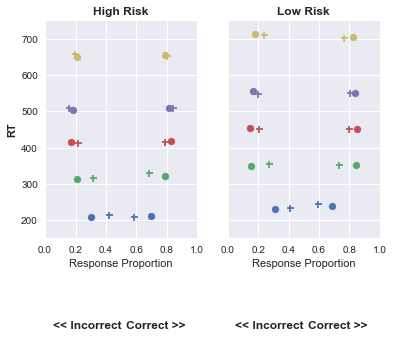

In [132]:
pal = sns.color_palette()
ct = 0

clean=pad_data
f,(ax1,ax2) = plt.subplots(1,2,sharex=False,sharey=True)
for pair in [(ax1,'HR'),(ax2,'LR')]:
    axis, grp = pair
    
    if grp == 'LR':
        grp_name = 'Low Risk'
    else:
        grp_name = 'High Risk'

    old_val = 0.005
    for new_val in [0.1,0.3,0.5,0.7,0.9,0.995]:
        d_clean = clean[clean.group == grp]
        df = d_clean[(d_clean.group == grp) & (d_clean.rt > d_clean.rt.quantile(q=old_val)) &
                                                 (d_clean.rt < d_clean.rt.quantile(q=new_val))]
        pct_corr_rich = df[df.rl_stim=='rich_stim'].correct.mean()
        pct_err_rich = 1 - pct_corr_rich
        pct_corr_lean = df[df.rl_stim=='lean_stim'].correct.mean()
        pct_err_lean = 1 - pct_corr_lean
        
        corr_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_rich = df[(df.rl_stim=='rich_stim') & (df.correct == 0)]['rt'].mean()
        corr_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 1)]['rt'].mean()
        err_rt_lean = df[(df.rl_stim=='lean_stim') & (df.correct == 0)]['rt'].mean()
        
        axis.scatter(x=(pct_corr_rich,pct_err_rich),
                     y=(corr_rt_rich,err_rt_rich),marker='o',c=pal[ct])
        axis.scatter(x=(pct_corr_lean,pct_err_lean),
                     y=(corr_rt_lean,err_rt_lean),marker='+',c=pal[ct])

        old_val = new_val

        if ct < 5:
            ct = ct + 1
        else:
            ct = 0
        
    axis.set_ylabel('RT',weight='bold')
    axis.set_xlabel('Response Proportion')
    axis.set_xlim(0,1)
    axis.set_ylim(150,750)
    axis.text(x=0.53,y=-100,s='Correct >>',fontsize=12,weight='bold')
    axis.text(x=0.05,y=-100,s='<< Incorrect',fontsize=12,weight='bold')
    axis.set_title(grp_name,weight='bold')
    
ax2.set_ylabel('')

In [136]:
# Anova on accuracy for fast and slow responses

# Matching the q-q plots, main effect of stimulus for fast but not slow responses. Interaction between 
# group and stimulus for the slow responses

#%R detach(package:lmerTest)
# Fast RTs: strong main effects of Stimulus
fast = pad_data[pad_data.rt <= pad_data.rt.quantile(q=0.3)]
print('For the "fast" data, the min RT = ' + str(np.min(fast.rt)) + ', the max RT = ' + str(np.max(fast.rt)) + '.')

%Rpush fast

%R fast.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=fast,\
                     anova_table=list(correction='GG',es='pes'))
%R print(fast.aov)


# Fast: main effect of Stimulus, rich > lean
%R fast_stim.lsm <- lsmeans(fast.aov,~rl_stim)
%R print(fast_stim.lsm)

# No effect of stimulus 
slow = pad_data[pad_data.rt > pad_data.rt.quantile(q=0.3)]
print('For the "slow" data, the min RT = ' + str(np.min(slow.rt)) + ', the max RT = ' + str(np.max(slow.rt)) + '.')

%Rpush slow
%R slow.aov <- aov_ez(id='subject',dv='correct',within='rl_stim',between='group',data=slow,\
                     anova_table=list(correction='GG',es='pes'))
%R print(slow.aov)

For the "fast" data, the min RT = 150, the max RT = 397.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE       F  pes p.value
1         group 1, 84 0.04    0.63 .007     .43
2       rl_stim 1, 84 0.03 9.38 **  .10    .003
3 group:rl_stim 1, 84 0.03    0.10 .001     .76

Sphericity correction method: GG 


 rl_stim      lsmean         SE     df  lower.CL  upper.CL
 lean_stim 0.6799991 0.02148751 168.29 0.6375793 0.7224189
 rich_stim 0.7780050 0.02148751 168.29 0.7355852 0.8204248

Results are averaged over the levels of: group 
Confidence level used: 0.95 


For the "slow" data, the min RT = 398, the max RT = 2068.


Anova Table (Type 3 tests)

Response: correct
         Effect    df  MSE      F  pes p.value
1         group 1, 89 0.01   0.30 .003     .59
2       rl_stim 1, 89 0.01   2.45  .03     .12
3 group:rl_stim 1, 89 0.01 4.36 *  .05     .04

Sphericity correction method: GG 


In [138]:
# follow up on group x stim interaction in slow responses
# %R detach(package:lmerTest) 

%R library(lsmeans)
%R group_x_stim.lsm <- lsmeans(slow.aov, ~ group*rl_stim)
%R print(group_x_stim.lsm)
%R print(pairs(group_x_stim.lsm))

 group rl_stim      lsmean         SE     df  lower.CL  upper.CL
 HR    lean_stim 0.7884868 0.01741970 155.84 0.7540776 0.8228960
 LR    lean_stim 0.7612430 0.01301343 175.63 0.7355602 0.7869259
 HR    rich_stim 0.7796780 0.01741970 155.84 0.7452688 0.8140872
 LR    rich_stim 0.8228185 0.01301343 175.63 0.7971357 0.8485014

Confidence level used: 0.95 


 contrast                        estimate         SE     df t.ratio p.value
 HR,lean_stim - LR,lean_stim  0.027243788 0.02228337 174.43   1.223  0.6134
 HR,lean_stim - HR,rich_stim  0.008808803 0.02890959  89.00   0.305  0.9901
 HR,lean_stim - LR,rich_stim -0.034331711 0.02228337 174.43  -1.541  0.4155
 LR,lean_stim - HR,rich_stim -0.018434985 0.02228337 174.43  -0.827  0.8415
 LR,lean_stim - LR,rich_stim -0.061575499 0.01730255  89.00  -3.559  0.0033
 HR,rich_stim - LR,rich_stim -0.043140513 0.02228337 174.43  -1.936  0.2169

P value adjustment: tukey method for comparing a family of 4 estimates 


## HDDM

In [7]:
# getting the data HDDM compatible
pad_data.loc[pad_data.rl_resp == 'rich_resp', 'response'] = 1
pad_data.loc[pad_data.rl_resp == 'lean_resp', 'response'] = 0
pad_data.loc[pad_data.rl_stim == 'rich_stim', 'stim'] = 1
pad_data.loc[pad_data.rl_stim == 'lean_stim', 'stim'] = 0
pad_data.rename(columns={'subject': 'subj_idx'}, inplace=True)
pad_data['rt'] = pad_data.rt/1000
pad_data_ddm = pad_data_ddm[['subj_idx','stim','response','group','rt']]
pad_data_ddm = pad_data_ddm.dropna()
pad_data.to_csv(path2data + 'PAD_session1_hddm_ready.csv')

In [8]:
pad_data_ddm = hddm.load_csv(path2data + 'PAD_session1_hddm_ready.csv')

In [9]:
pad_data_ddm.rt.describe()

count    17704.000000
mean         0.540841
std          0.266804
min          0.150000
25%          0.373000
50%          0.488000
75%          0.636000
max          2.068000
Name: rt, dtype: float64

In [11]:
pad_data_ddm.subj_idx.unique()

array([200, 201, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 219, 225, 226, 227, 228, 230, 232, 234, 235, 237, 239, 244,
       248, 249, 250, 251, 255, 256, 260, 261, 262, 264, 265, 267, 268,
       269, 270, 271, 273, 275, 276, 400, 401, 402, 404, 412, 415, 416,
       417, 418, 421, 422, 423, 426, 427, 429, 431, 432, 433, 434, 438,
       439, 440, 602, 603, 604, 605, 607, 608, 610, 612, 800, 801, 803,
       805, 806, 808, 809, 810, 813, 815, 816, 817, 818, 819, 820, 822])

Model with group included

In [12]:
pad_session1_model = hddm.HDDMStimCoding(pad_data_ddm, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
pad_session1_model.find_starting_values()
pad_session1_model.sample(10000, burn=1000,dbname=path2data + 'PAD_T1_group.db', db='pickle')
pad_session1_model.save(path2data + 'PAD_T1_group.db')

 [-----------------100%-----------------] 10000 of 10000 complete in 2246.1 sec

In [13]:
pad_session1_model.dic_info

{'DIC': 10060.413662134228,
 'deviance': 9739.5654238103652,
 'pD': 320.84823832386246}

Plotting a(HR)
Plotting a(LR)
Plotting a_std
Plotting v(HR)
Plotting v(LR)
Plotting v_std
Plotting t(HR)
Plotting t(LR)
Plotting t_std
Plotting z(HR)
Plotting z(LR)
Plotting z_std


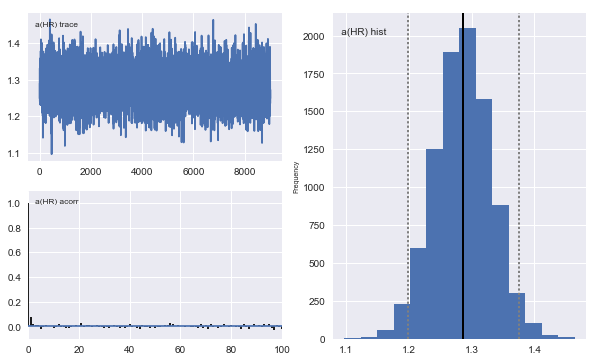

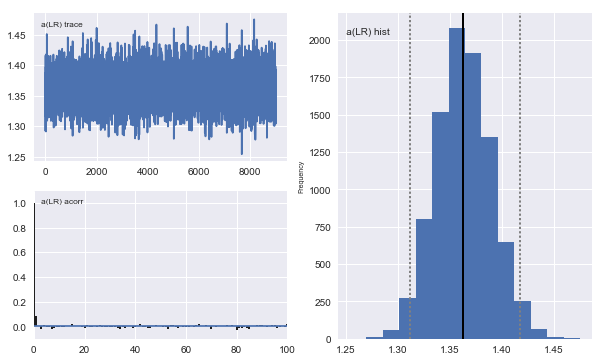

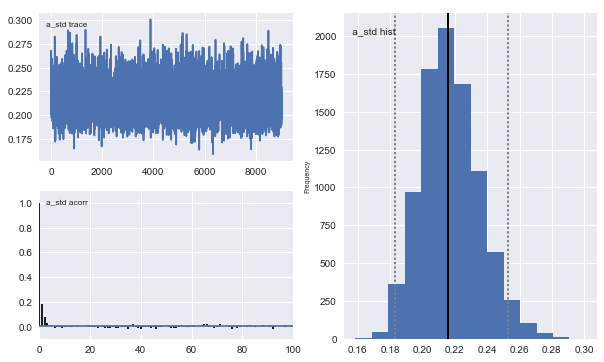

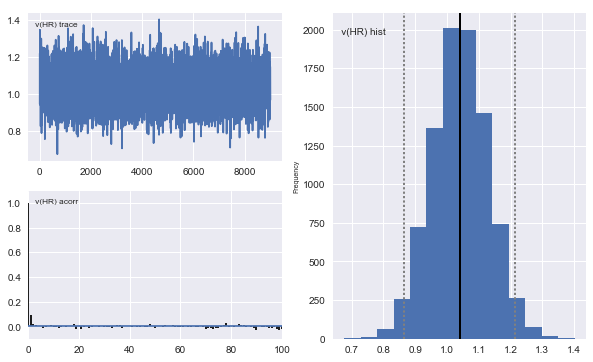

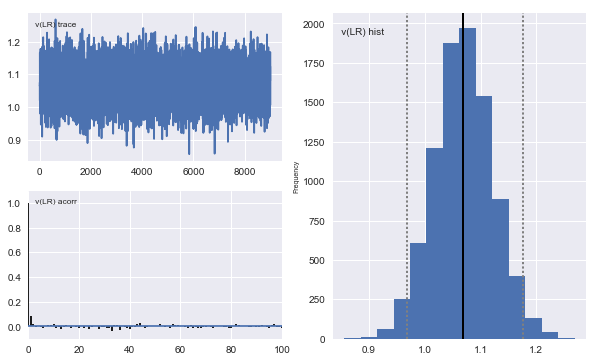

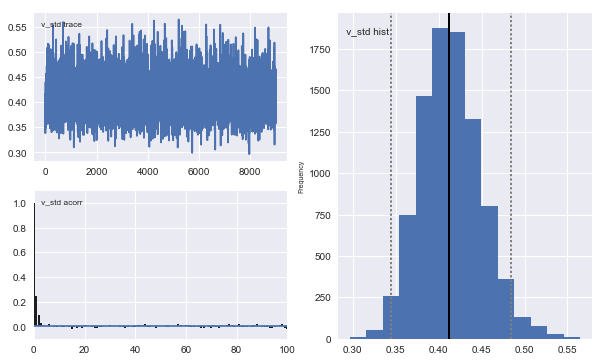

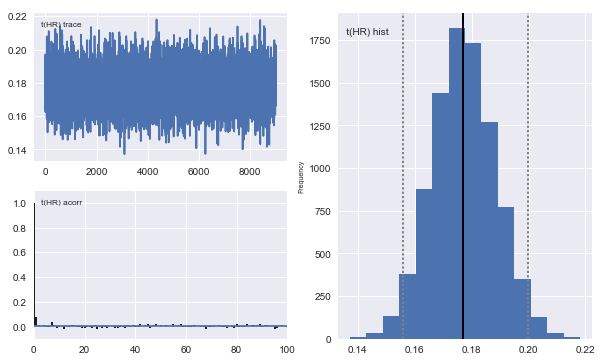

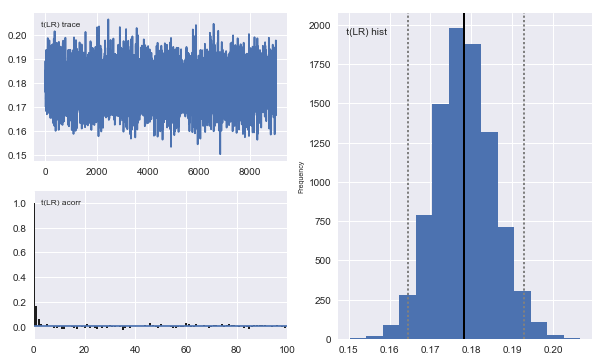

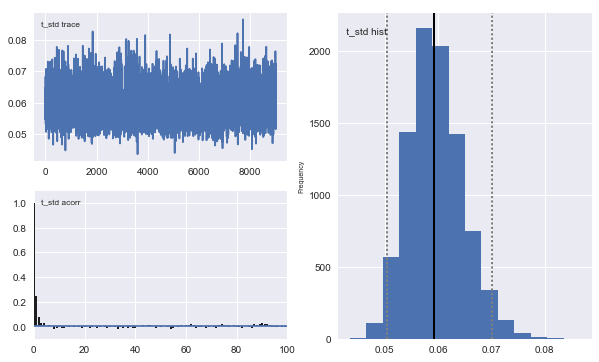

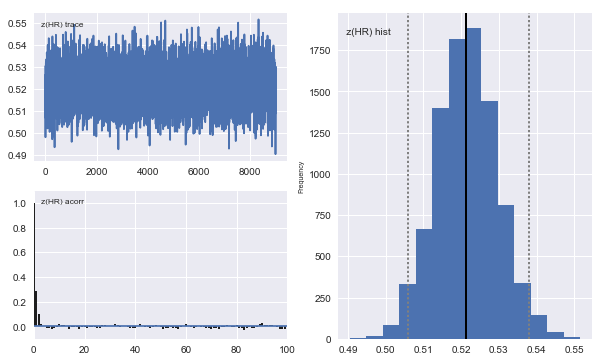

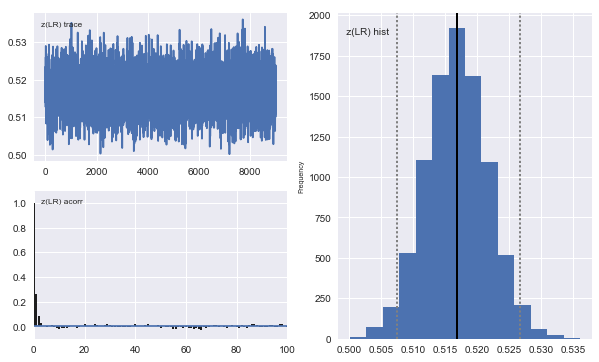

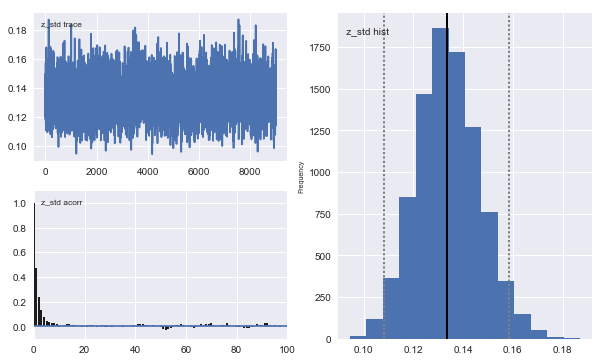

In [15]:
pad_session1_model.plot_posteriors()

P_a(HR > LR) =  0.0676666666667
P_a(LR > HR) =  0.932333333333


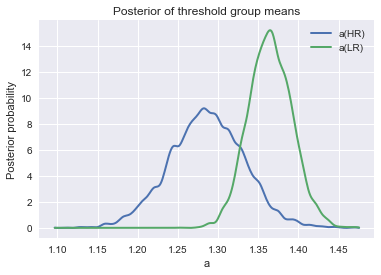

In [16]:
a_HR, a_LR = pad_session1_model.nodes_db.node[['a(HR)','a(LR)']]
hddm.analyze.plot_posterior_nodes([a_HR, a_LR])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(HR > LR) = ", (a_HR.trace() > a_LR.trace()).mean())
print ("P_a(LR > HR) = ", (a_LR.trace() > a_HR.trace()).mean())

P_a(HR > LR) =  0.390777777778
P_a(LR > HR) =  0.609222222222


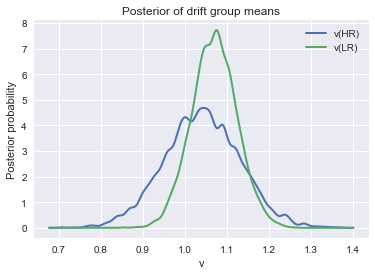

In [17]:
v_HR, v_LR = pad_session1_model.nodes_db.node[['v(HR)','v(LR)']]
hddm.analyze.plot_posterior_nodes([v_HR, v_LR])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(HR > LR) = ", (v_HR.trace() > v_LR.trace()).mean())
print ("P_a(LR > HR) = ", (v_LR.trace() > v_HR.trace()).mean())

P_z(HR > LR) =  0.686777777778
P_z(LR > HR) =  0.313222222222


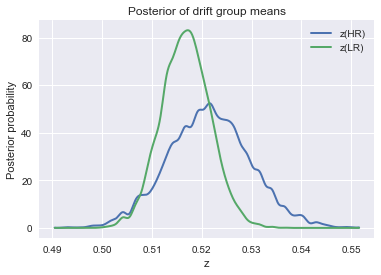

In [18]:
z_HR, z_LR = pad_session1_model.nodes_db.node[['z(HR)','z(LR)']]
hddm.analyze.plot_posterior_nodes([z_HR, z_LR])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_z(HR > LR) = ", (z_HR.trace() > z_LR.trace()).mean())
print ("P_z(LR > HR) = ", (z_LR.trace() > z_HR.trace()).mean())

P_t(HR > LR) =  0.466222222222
P_t(LR > HR) =  0.533777777778


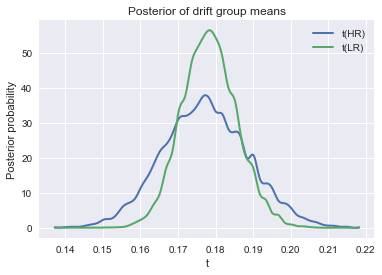

In [19]:
t_HR, t_LR = pad_session1_model.nodes_db.node[['t(HR)','t(LR)']]
hddm.analyze.plot_posterior_nodes([t_HR, t_LR])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_t(HR > LR) = ", (t_HR.trace() > t_LR.trace()).mean())
print ("P_t(LR > HR) = ", (t_LR.trace() > t_HR.trace()).mean())

**Building a second model without group for regressions**

In [21]:
pad_model_nogrp = hddm.HDDMStimCoding(pad_data_ddm, include='z', stim_col='stim', split_param='v')
pad_model_nogrp.find_starting_values()
pad_model_nogrp.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2139.4 sec

In [22]:
pad_model_nogrp.dic_info

{'DIC': 10058.07403136977,
 'deviance': 9739.0497991034499,
 'pD': 319.02423226631981}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


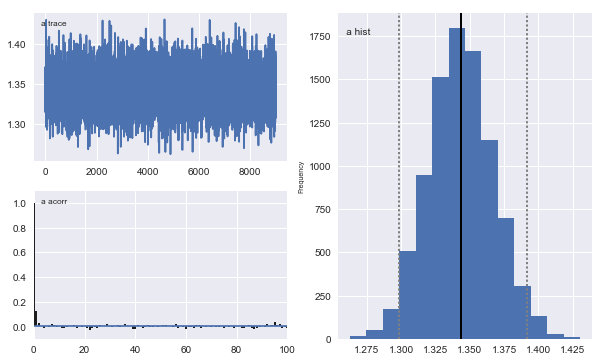

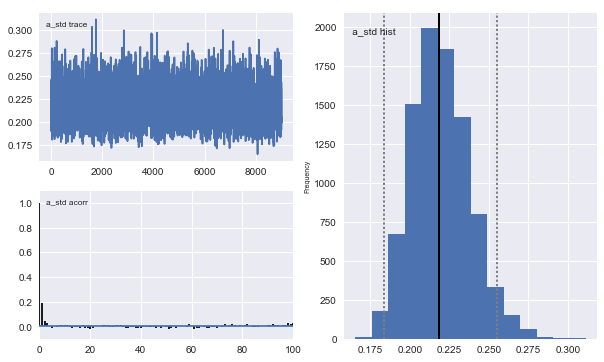

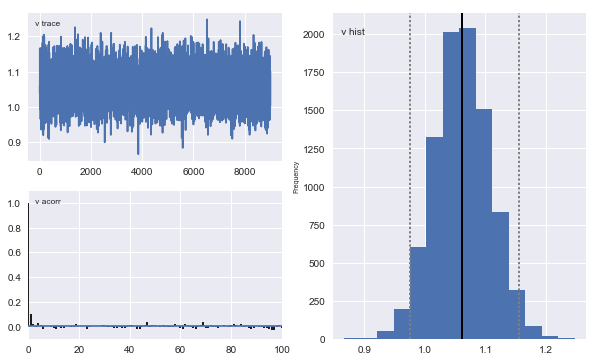

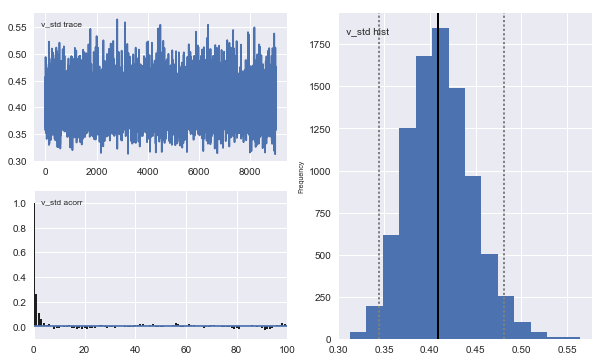

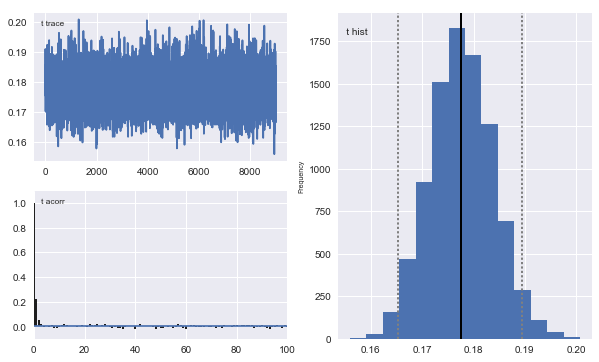

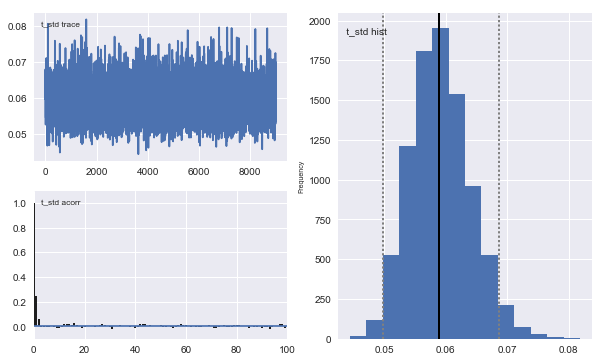

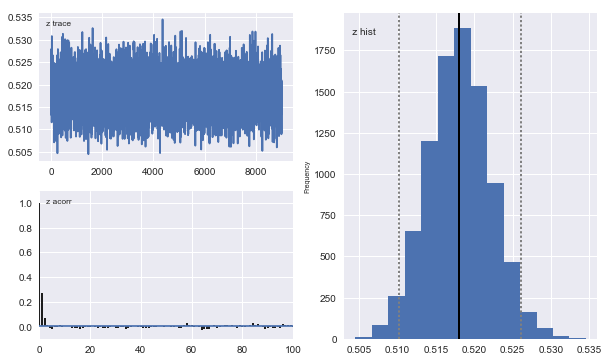

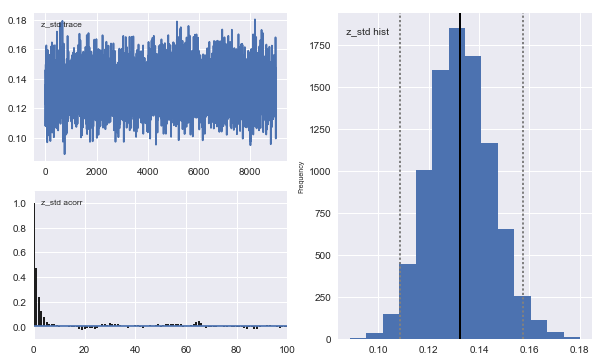

In [23]:
pad_model_nogrp.plot_posteriors()

Get subject means

In [25]:
stats = pad_model_nogrp.gen_stats()
stats.to_csv(path2data + 'pad_session1_modelstats_nogrp.csv')
stats = pd.read_csv(path2data + 'pad_session1_modelstats_nogrp.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.343477  0.023804  1.298130  1.327318  1.343442  1.359305   
1       a_std  0.219618  0.018405  0.187158  0.206511  0.218256  0.231543   
2  a_subj.200  1.571469  0.058107  1.463760  1.531286  1.569380  1.609844   
3  a_subj.201  1.614169  0.062151  1.496273  1.571779  1.611770  1.655457   
4  a_subj.205  1.216487  0.048528  1.124011  1.182702  1.215326  1.248388   

      97.5q    mc err  
0  1.391292  0.000280  
1  0.259877  0.000245  
2  1.690144  0.000862  
3  1.740387  0.000918  
4  1.316467  0.000709

In [30]:
def get_param(item):
    '''Returns the parameter from the genstats() data'''
    if len(item) == 10:
        param = item[0]
    else:
        param = np.nan
    return(param)
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 10:
        sub_id = item[7:10]
    else:
        sub_id = np.nan
    return(sub_id)

In [37]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.571469     a      200           0      0  1826           0   
1  v_subj.200  1.060361     v      200           0      0  1826           0   
2  t_subj.200  0.124940     t      200           0      0  1826           0   
3  z_subj.200  0.534382     z      200           0      0  1826           0   
4  a_subj.201  1.614169     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [38]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  1.060361      200           0      0  1826           0   
1  v_subj.201  1.226253      201         200    200  1178           1   
2  v_subj.205  1.530838      205         600    600   540           0   
3  v_subj.206  1.139419      206         800    800   717           1   
4  v_subj.208  1.436954      208        1000   1000  1010           0   
5  v_subj.209  1.192994      209        1200   1200   570           0   
6  v_subj.210  1.097405      210        1401   1401   868           1   
7  v_subj.211  0.893650      211        1600   1600  1086           0   
8  v_subj.212  0.659173      212        1800   1800   357           0   
9  v_subj.213  0.555212      213        2000   2000  1381           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         c    ...               0     79   
4           0  short         m    ...               0     79   
5           1  short         c    ...               0     75   
6           0   long         c    ...               0     76   
7           0  short         c    ...               0     72   
8           0  short         c    ...               0     76   
9           0  short         c    ...               0     76   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.203701             0.469714            0.154815   
4            0.123570             0.618065            0.127636   
5           -0.058603             0.530010           -0.189317   
6           -0.028894             0.639226           -0.171767   
7            0.076291             0.425833           -0.010325   
8            0.115270             0.244212            0.034607   
9           -0.065575             0.287424           -0.187716   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.571469  0.534382  0.124940  
1            0.797025      -0.116439  1.614169  0.454348  0.130584  
2            0.746675       0.159823  1.216487  0.538168  0.131075  
3            0.598513       0.086987  0.994347  0.495278  0.201773  
4            0.571334      -0.013872  1.074380  0.569986  0.140365  
5            0.509653       0.270919  1.172497  0.459633  0.149879  
6            0.591661       0.307354  1.452981  0.549459  0.141953  
7            0.417810       0.176222  1.200202  0.552359  0.117179  
8            0.286945       0.151136  0.965890  0.523378  0.124667  
9            0.255981       0.255977  1.317844  0.527313  0.126353  

[10 rows x 40 columns]

In [39]:
reward_stats.to_csv(path2data + 'pad_session1_hddm_params.csv')

**build third model of just the low risk kids**

In [41]:
LR_pad_data_ddm = pad_data_ddm.loc[pad_data_ddm.group == 'LR']

In [44]:
pad_model_LR = hddm.HDDMStimCoding(LR_pad_data_ddm, include='z', stim_col='stim', split_param='v')
pad_model_LR.find_starting_values()
pad_model_LR.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1487.4 sec

In [45]:
pad_model_LR.dic_info

{'DIC': 7989.3812758201593,
 'deviance': 7752.7762920881423,
 'pD': 236.60498373201699}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


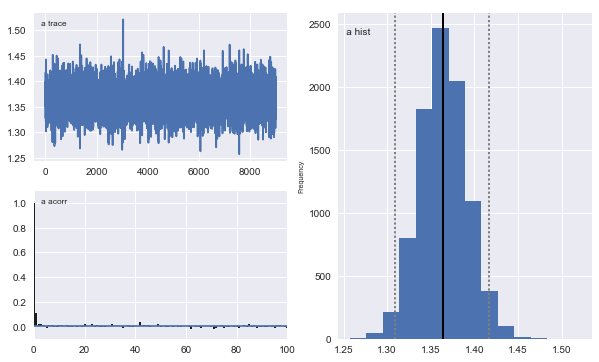

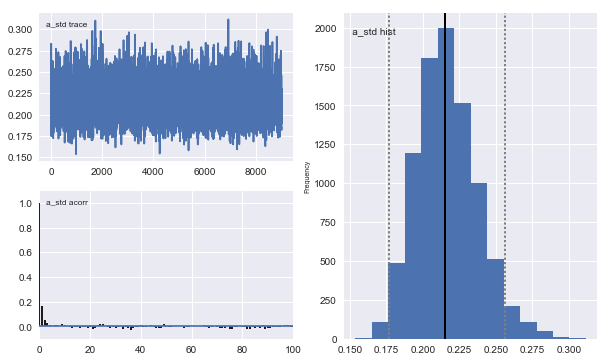

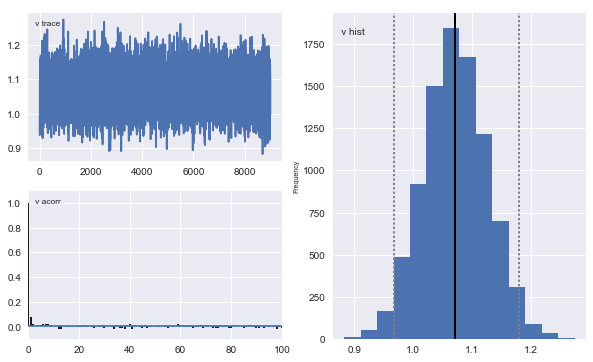

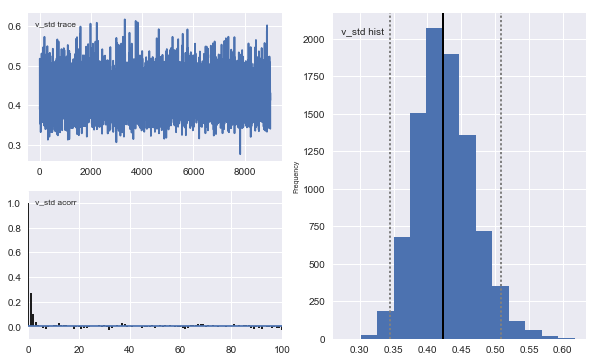

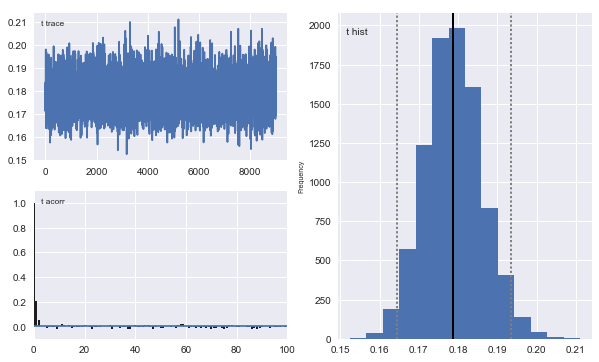

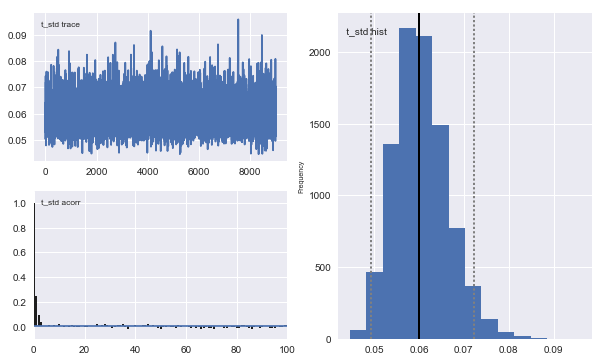

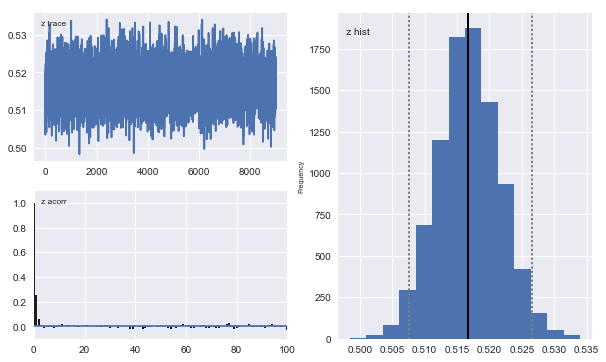

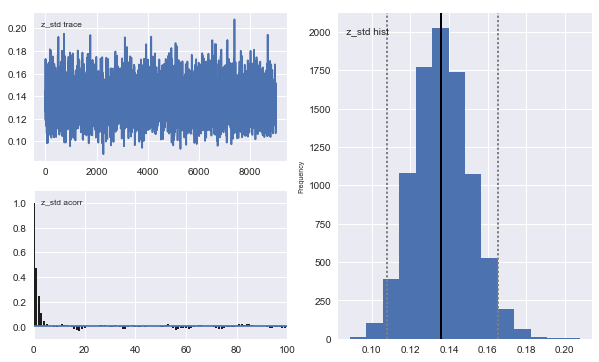

In [46]:
pad_model_LR.plot_posteriors()

In [47]:
stats = pad_model_LR.gen_stats()
stats.to_csv(path2data + 'pad_session1_modelstats_LR.csv')
stats = pd.read_csv(path2data + 'pad_session1_modelstats_LR.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.364387  0.027346  1.312356  1.345756  1.364171  1.382348   
1       a_std  0.216532  0.020766  0.180685  0.201827  0.215061  0.229545   
2  a_subj.200  1.573138  0.058991  1.461291  1.533031  1.571391  1.611870   
3  a_subj.201  1.616895  0.062594  1.500054  1.574653  1.614491  1.657965   
4  a_subj.205  1.216934  0.047770  1.128489  1.183206  1.215111  1.248439   

      97.5q    mc err  
0  1.420459  0.000348  
1  0.262168  0.000268  
2  1.694103  0.000809  
3  1.744909  0.000925  
4  1.315037  0.000813

In [49]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.573138     a      200           0      0  1826           0   
1  v_subj.200  1.063505     v      200           0      0  1826           0   
2  t_subj.200  0.124596     t      200           0      0  1826           0   
3  z_subj.200  0.534123     z      200           0      0  1826           0   
4  a_subj.201  1.616895     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [50]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  1.063505      200           0      0  1826           0   
1  v_subj.201  1.230401      201         200    200  1178           1   
2  v_subj.205  1.537817      205         600    600   540           0   
3  v_subj.206  1.144126      206         800    800   717           1   
4  v_subj.208  1.444263      208        1000   1000  1010           0   
5  v_subj.209  1.196264      209        1200   1200   570           0   
6  v_subj.210  1.100239      210        1401   1401   868           1   
7  v_subj.211  0.892833      211        1600   1600  1086           0   
8  v_subj.212  0.660314      212        1800   1800   357           0   
9  v_subj.213  0.555771      213        2000   2000  1381           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         c    ...               0     79   
4           0  short         m    ...               0     79   
5           1  short         c    ...               0     75   
6           0   long         c    ...               0     76   
7           0  short         c    ...               0     72   
8           0  short         c    ...               0     76   
9           0  short         c    ...               0     76   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.203701             0.469714            0.154815   
4            0.123570             0.618065            0.127636   
5           -0.058603             0.530010           -0.189317   
6           -0.028894             0.639226           -0.171767   
7            0.076291             0.425833           -0.010325   
8            0.115270             0.244212            0.034607   
9           -0.065575             0.287424           -0.187716   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.573138  0.534123  0.124596  
1            0.797025      -0.116439  1.616895  0.453113  0.130575  
2            0.746675       0.159823  1.216934  0.537546  0.131007  
3            0.598513       0.086987  0.995572  0.494966  0.201762  
4            0.571334      -0.013872  1.076296  0.570319  0.140292  
5            0.509653       0.270919  1.175013  0.458623  0.149775  
6            0.591661       0.307354  1.453183  0.549429  0.142039  
7            0.417810       0.176222  1.202480  0.552649  0.116934  
8            0.286945       0.151136  0.966859  0.522845  0.124586  
9            0.255981       0.255977  1.318378  0.527025  0.126291  

[10 rows x 40 columns]

In [51]:
reward_stats.to_csv(path2data + 'pad_session1_hddm_params_LR.csv')

## Session 2

In [71]:
# adding rich and lean columns, blocks
out = pd.read_csv(path2data + 'PAD_FU_trial_all.csv')
data = out.reset_index()
del data['Unnamed: 0']

data.bias = data.bias.apply(lambda x: x.strip(' '))
data.trial = data.trial.apply(lambda x: int(x))
data['rl_stim'] = ''
data.loc[data['length'] == data['bias'], 'rl_stim'] = 'rich_stim'
data.loc[data['length'] != data['bias'], 'rl_stim'] = 'lean_stim'

data['rich_key'] = ''
data.loc[data['bias'] == 'short', 'rich_key'] = data['short_key']
data.loc[data['bias'] == 'long', 'rich_key'] = data['long_key']
data.rich_key = data.rich_key.apply(lambda x: x.strip(' '))

data['rl_resp'] = ''
data.loc[data['key_press'] == data['rich_key'], 'rl_resp'] = 'rich_resp'
data.loc[data['key_press'] != data['rich_key'], 'rl_resp'] = 'lean_resp'

data['block'] = 0
data.loc[data.trial <= 300, 'block'] = 3
data.loc[data.trial <= 200, 'block'] = 2
data.loc[data.trial <= 100, 'block'] = 1

#### Quality control (trials):
"PRT trials were considered outliers and excluded from analysis if the raw RT was less than 150 ms or greater than 2500 ms, or if the log transformed RT was greater than 3 S.D.s from the participant’s mean."

In [72]:
# Mark trials as outliers if 150 > time > 2500

data.rt = data.rt.apply(lambda x: int(x))
data['ln_rt'] = data.rt.apply(np.log)
data['outlier'] = 0
data.loc[(data['rt'] > 2500) | (data['rt'] < 150), 'outlier'] = 1

cleandata = data[data.outlier == 0]
data['mean_ln_rt'] = 0 # make columns of interest
data['ln_std'] = 0
for sub in data.subjectID.unique():
    mean = cleandata[cleandata.subjectID == sub].ln_rt.mean()
    std = cleandata[cleandata.subjectID == sub].ln_rt.std()
    data.loc[data.subjectID == sub, 'mean_ln_rt'] = mean
    data.loc[data.subjectID == sub, 'ln_std'] = std
    
# Mark trials as outliers if the ln rt is >/< 3sd from the mean

data.loc[(data.ln_rt > (3*data.ln_std + data.mean_ln_rt)), 'outlier'] = 1
data.loc[(data.ln_rt < (data.mean_ln_rt-3*data.ln_std)), 'outlier'] = 1

#### Quality control (subjects):
"Additionally, participants with more than 20 outlier trials in each block, less than 24 rich or 7 lean rewards in each block, less than a 2.5 rich-to-lean reward ratio in either block, or accuracy less than 0.4 for rich or lean trials in either block were excluded from analysis."

In [73]:
data.subject.unique()

array([200, 201, 205, 208, 210, 212, 213, 214, 216, 217, 218, 226, 228,
       229, 231, 234, 235, 245, 251, 253, 254, 256, 260, 261, 262, 265,
       268, 269, 270, 400, 401, 402, 404, 405, 410, 412, 413, 414, 415,
       417, 418, 420, 421, 422, 423, 424, 427, 431, 432, 434, 435, 436,
       437, 603, 604, 605, 607, 608, 609, 610, 800, 801, 803, 805, 806,
       809, 815, 818, 819])

In [74]:
# there is a third block but the participants are never rewarded in that block

data.block.unique()
data = data.loc[data.block < 3]

In [75]:
data.did_reward = data.did_reward.apply(lambda x: int(x))
data.correct = data.correct.apply(lambda x: int(x))
data.subject = data.subject.apply(lambda x: str(x))
cleandata = data[data.outlier == 0]
data['outlier_sub'] = 0
for subject in data.subject.unique():
    for block in data.block.unique():
        
        noutliers = data[(data.subject == subject) & (data.block == block)].outlier.sum()
        
        nrichrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'rich_stim') & (cleandata.block == block)].did_reward.sum()
        nleanrew = cleandata[(cleandata.subject == subject) & (cleandata.rl_stim == 'lean_stim') & (cleandata.block == block)].did_reward.sum()
        ratio = nrichrew/nleanrew

        numcorrect = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.sum()
        count = cleandata[(cleandata.subject == subject) & (cleandata.block == block)].correct.count()
        accuracy = (numcorrect/count) 
        
        if ratio < 2.5:
            print ('Subject ' + str(subject) + ' was excluded for having a low reward ratio')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        
        if noutliers > 20:
            print ('Subject ' + str(subject) + ' was excluded for having more than 20 outlier trials')
            data.loc[data.subject == subject, 'outlier_sub'] = 1
        elif nrichrew < 24:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 24 rewarded rich trials
            print('Subject ' + str(subject) + ' was excluded for having too few rich rewarded trials')
        elif nleanrew < 7:
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # less than 7 rewarded lean trials
            print('Subject ' + str(subject) + ' was excluded for having too few lean rewarded trials')
        elif accuracy < (.4):
            data.loc[data.subject == subject, 'outlier_sub'] = 1 # mark participants as outliers if they have 
                                                                 # low accuracy
            print('Subject ' + str(subject) + ' was excluded for low overall accuracy')

Subject 213 was excluded for having a low reward ratio
Subject 213 was excluded for having more than 20 outlier trials
Subject 213 was excluded for having too few rich rewarded trials
Subject 245 was excluded for having a low reward ratio
Subject 245 was excluded for having more than 20 outlier trials
Subject 245 was excluded for having more than 20 outlier trials
Subject 253 was excluded for having a low reward ratio
Subject 253 was excluded for having too few rich rewarded trials
Subject 422 was excluded for having more than 20 outlier trials
Subject 422 was excluded for having more than 20 outlier trials
Subject 423 was excluded for having more than 20 outlier trials
Subject 431 was excluded for having a low reward ratio
Subject 434 was excluded for having a low reward ratio
Subject 434 was excluded for having more than 20 outlier trials
Subject 434 was excluded for having more than 20 outlier trials
Subject 436 was excluded for having more than 20 outlier trials
Subject 436 was exc

In [76]:
# print the subjects that were excluded in an easier to read format
data.loc[data.outlier_sub == 1].subject.unique()

array(['213', '245', '253', '422', '423', '431', '434', '436', '437',
       '605', '609'], dtype=object)

In [77]:
data['rwdct'] = 0
cleandata = data[data.outlier == 0]
for subject in data.subject.unique():
    reward = cleandata.loc[cleandata.subject == subject].did_reward.sum()
    data.loc[data.subject == subject, 'rwdct'] = reward 

In [78]:
# take only the clean data
data = data[data.outlier == 0]
data = data[data.outlier_sub == 0]
data.subject.nunique() 

58

In [79]:
# how many left in each group
data.group = data.subject
data.group = data.group.apply(lambda x: x[0])
data.group.replace({'2': 'LR','4':'LR','8':'HR','6':'HR'},inplace=True)
data.groupby('group').subject.nunique()

group
HR    14
LR    44
Name: subject, dtype: int64

### Calculate RB & Discriminability

In [80]:
def calc_rb(subject, data):
    '''Given a subject and dataframe, returns the discriminability and response bias for the subject'''
    rh_correct = data[(data.subject == subject) & (data.rl_stim == 'rich_stim')].correct.sum() + .5
    rh_incorrect = data[(data.subject == subject) & (data.rl_stim == 'rich_stim') & (data.correct == 0)].correct.count() + .5
    ln_correct = data[(data.subject == subject) & (data.rl_stim == 'lean_stim')].correct.sum() + .5
    ln_incorrect = data[(data.subject == subject) & (data.rl_stim == 'lean_stim') & (data.correct == 0)].correct.count() + .5
    
    rb = .5 * np.log10((rh_correct * ln_incorrect)/(rh_incorrect * ln_correct))
    disc = .5 * np.log10((rh_correct * ln_correct)/(rh_incorrect * ln_incorrect))
    
    return(rb, disc)

In [81]:
for subject in data.subject.unique():
    rb, disc = calc_rb(subject, data)
    data.loc[data.subject == subject, 'RB_adjst_all_total'] = rb
    data.loc[data.subject == subject, 'dis_adjst_all_total'] = disc
    for block in data.block.unique():
        rb, disc = calc_rb(subject, data[data.block == block])
        data.loc[(data.subject == subject) & (data.block == block), 'RB_adjst_all_block'] = rb
        data.loc[(data.subject == subject) & (data.block == block), 'dis_adjst_all_block'] = disc  
for subject in data.subject.unique():
    block1_rb = data[(data.subject == subject) & (data.block == 1)].RB_adjst_all_block.mean()
    block2_rb = data[(data.subject == subject) & (data.block == 2)].RB_adjst_all_block.mean()
    b2_minus_b1 = block2_rb - block1_rb
    data.loc[data.subject == subject, 'RB_b2_minus_b1'] = b2_minus_b1

In [82]:
data.head()

index    rt  did_reward  little_due length key_press  reward_due  big_due  \
0      0   802           0           0  short         M           0        0   
1      1   847           1           0   long         C           1        0   
2      2  1480           1           0  short         M           1        0   
3      3   634           0           0   long         C           0        0   
4      4   765           0           0  short         M           0        0   

   trial  correct      ...       outlier mean_ln_rt    ln_std outlier_sub  \
0      1        1      ...             0   6.202757  0.467314           0   
1      2        1      ...             0   6.202757  0.467314           0   
2      3        1      ...             0   6.202757  0.467314           0   
3      4        1      ...             0   6.202757  0.467314           0   
4      5        1      ...             0   6.202757  0.467314           0   

   rwdct RB_adjst_all_total dis_adjst_all_total RB_adjst_all_block  \
0     70           -0.05495            0.374622          -0.097938   
1     70           -0.05495            0.374622          -0.097938   
2     70           -0.05495            0.374622          -0.097938   
3     70           -0.05495            0.374622          -0.097938   
4     70           -0.05495            0.374622          -0.097938   

  dis_adjst_all_block RB_b2_minus_b1  
0            0.405917       0.088983  
1            0.405917       0.088983  
2            0.405917       0.088983  
3            0.405917       0.088983  
4            0.405917       0.088983  

[5 rows x 33 columns]

In [83]:
data.tail()

index   rt  did_reward  little_due length key_press  reward_due  \
20595  20595  461           0           0  short         c           0   
20596  20596  472           0           0   long         m           0   
20597  20597  802           0           0   long         c           0   
20598  20598  263           0           0  short         c           0   
20599  20599  354           0           0  short         c           0   

       big_due  trial  correct      ...       outlier mean_ln_rt    ln_std  \
20595        0    196        1      ...             0   6.202757  0.467314   
20596        0    197        1      ...             0   6.202757  0.467314   
20597        0    198        0      ...             0   6.202757  0.467314   
20598        0    199        1      ...             0   6.202757  0.467314   
20599        0    200        1      ...             0   6.202757  0.467314   

      outlier_sub  rwdct RB_adjst_all_total dis_adjst_all_total  \
20595           0     78          -0.209552            0.526973   
20596           0     78          -0.209552            0.526973   
20597           0     78          -0.209552            0.526973   
20598           0     78          -0.209552            0.526973   
20599           0     78          -0.209552            0.526973   

      RB_adjst_all_block dis_adjst_all_block RB_b2_minus_b1  
20595          -0.218358            0.607218      -0.020551  
20596          -0.218358            0.607218      -0.020551  
20597          -0.218358            0.607218      -0.020551  
20598          -0.218358            0.607218      -0.020551  
20599          -0.218358            0.607218      -0.020551  

[5 rows x 33 columns]

In [84]:
data.to_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/PAD_session2_trial_clean.csv')

## HDDM

In [89]:
pad_data_t2 = pd.read_csv('/Users/victorialawlor/Work/Expts/KIDPRT/Data/PAD_session2_trial_clean.csv')

In [91]:
# getting the data HDDM compatible
pad_data_t2.loc[pad_data_t2.rl_resp == 'rich_resp', 'response'] = 1
pad_data_t2.loc[pad_data_t2.rl_resp == 'lean_resp', 'response'] = 0
pad_data_t2.loc[pad_data_t2.rl_stim == 'rich_stim', 'stim'] = 1
pad_data_t2.loc[pad_data_t2.rl_stim == 'lean_stim', 'stim'] = 0
pad_data_t2.rename(columns={'subject': 'subj_idx'}, inplace=True)
pad_data_t2['rt'] = pad_data_t2.rt/1000
pad_data_ddm_t2 = pad_data_t2[['subj_idx','stim','response','group','rt']]
pad_data_ddm_t2 = pad_data_ddm_t2.dropna()
pad_data_ddm_t2.to_csv(path2data + 'PAD_session2_hddm_ready.csv')

In [92]:
pad_fudata_ddm = hddm.load_csv(path2data + 'PAD_session2_hddm_ready.csv')

In [93]:
pad_fudata_ddm.rt.describe()

count    11288.000000
mean         0.538880
std          0.257304
min          0.150000
25%          0.379000
50%          0.479000
75%          0.621000
max          1.997000
Name: rt, dtype: float64

In [94]:
pad_fudata_ddm.subj_idx.unique()

array([200, 201, 205, 208, 210, 212, 214, 216, 217, 218, 226, 228, 229,
       231, 234, 235, 251, 254, 256, 260, 261, 262, 265, 268, 269, 270,
       400, 401, 402, 404, 405, 410, 412, 413, 414, 415, 417, 418, 420,
       421, 424, 427, 432, 435, 603, 604, 607, 608, 610, 800, 801, 803,
       805, 806, 809, 815, 818, 819])

Model with group included

In [95]:
pad_session2_model = hddm.HDDMStimCoding(pad_fudata_ddm, include='z', stim_col='stim', split_param='v',depends_on={'v': 'group', 'a': 'group', 't': 'group', 'z': 'group'})
pad_session2_model.find_starting_values()
pad_session2_model.sample(10000, burn=1000,dbname=path2data + 'PAD_T2_group.db', db='pickle')
pad_session2_model.save(path2data + 'PAD_T2_group.db')

 [-----------------100%-----------------] 10001 of 10000 complete in 7059.9 sec

In [96]:
pad_session2_model.dic_info

{'DIC': 4314.3618000417227,
 'deviance': 4106.6599805849655,
 'pD': 207.70181945675722}

Plotting a(HR)
Plotting a(LR)
Plotting a_std
Plotting v(HR)
Plotting v(LR)
Plotting v_std
Plotting t(HR)
Plotting t(LR)
Plotting t_std
Plotting z(HR)
Plotting z(LR)
Plotting z_std


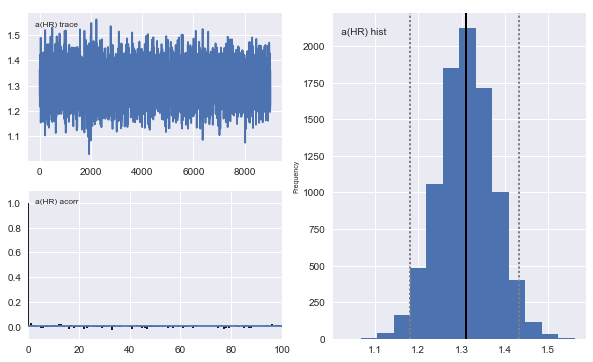

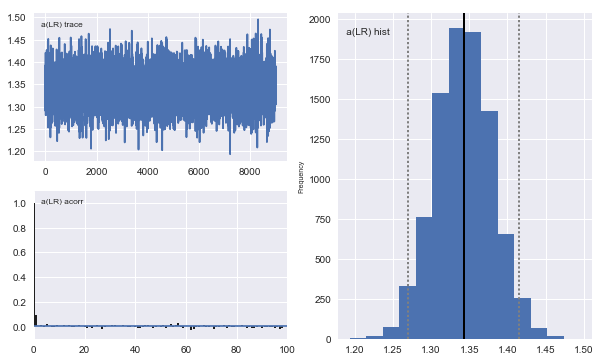

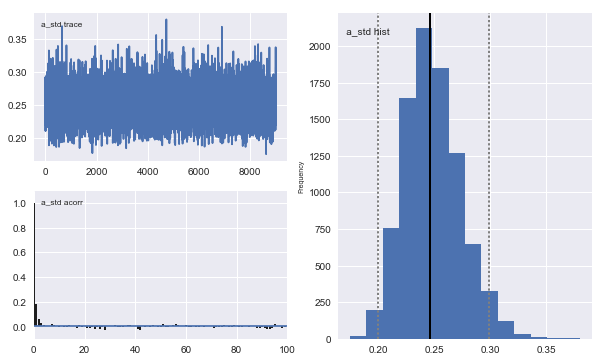

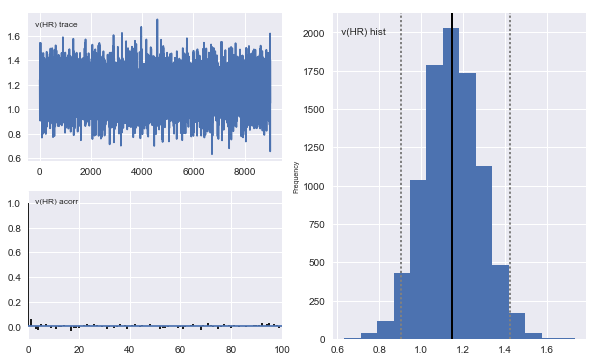

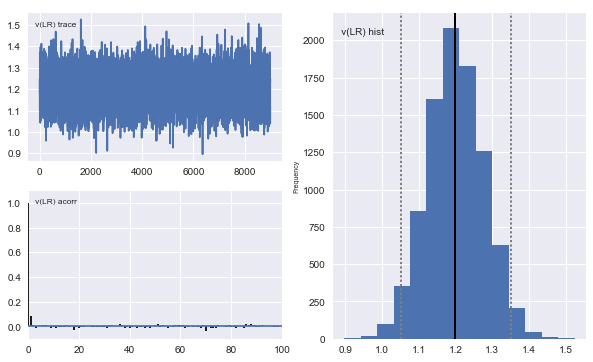

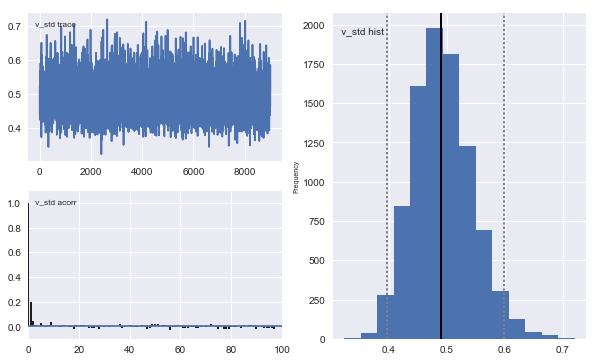

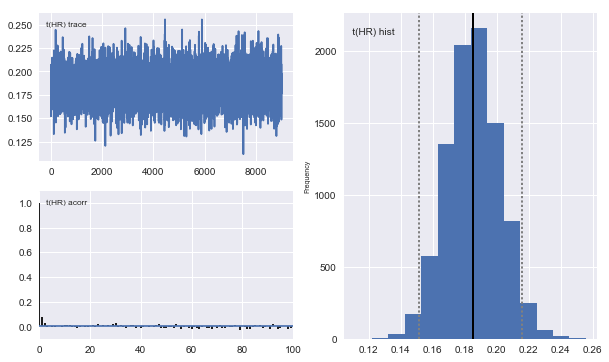

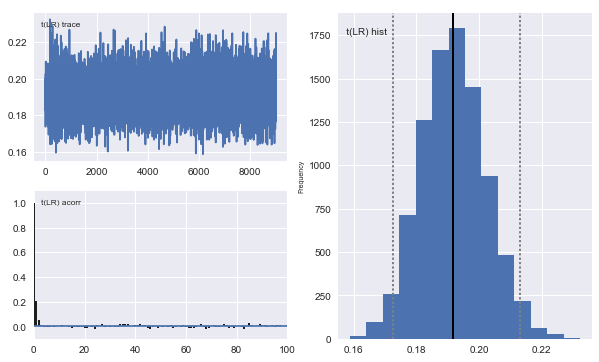

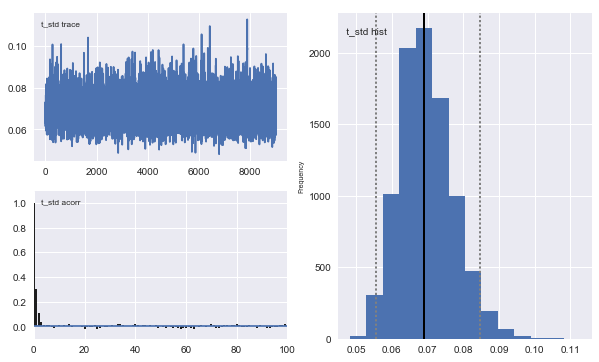

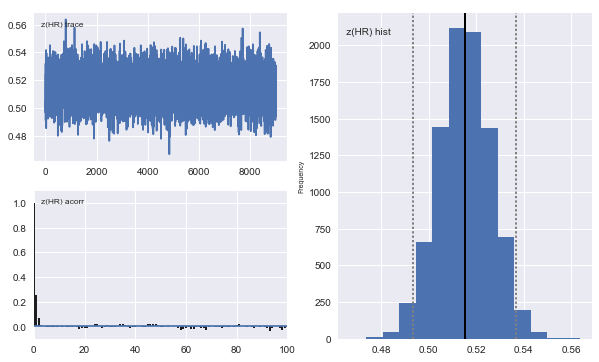

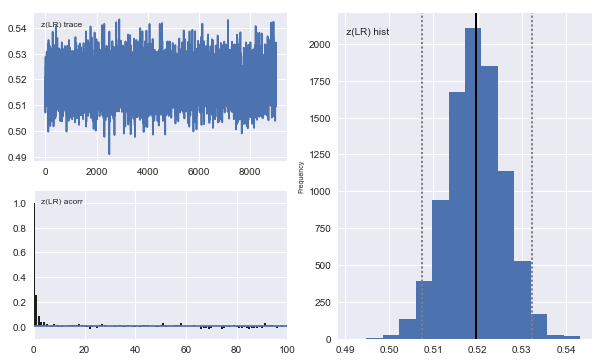

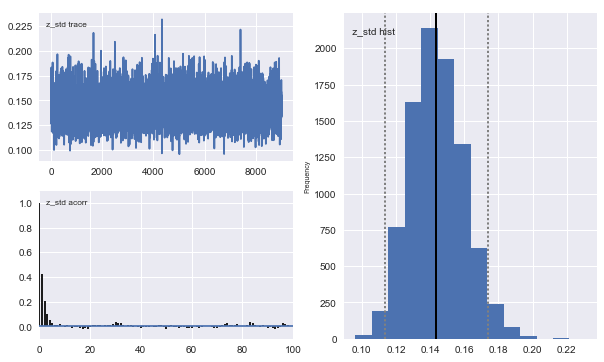

In [97]:
pad_session2_model.plot_posteriors()

P_a(HR > LR) =  0.326
P_a(LR > HR) =  0.674


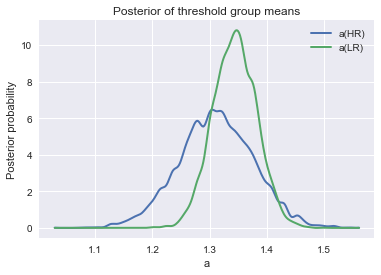

In [98]:
a_HR, a_LR = pad_session2_model.nodes_db.node[['a(HR)','a(LR)']]
hddm.analyze.plot_posterior_nodes([a_HR, a_LR])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(HR > LR) = ", (a_HR.trace() > a_LR.trace()).mean())
print ("P_a(LR > HR) = ", (a_LR.trace() > a_HR.trace()).mean())

P_a(HR > LR) =  0.362888888889
P_a(LR > HR) =  0.637111111111


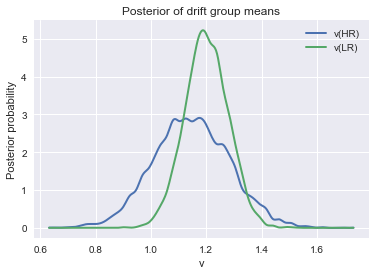

In [99]:
v_HR, v_LR = pad_session2_model.nodes_db.node[['v(HR)','v(LR)']]
hddm.analyze.plot_posterior_nodes([v_HR, v_LR])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_a(HR > LR) = ", (v_HR.trace() > v_LR.trace()).mean())
print ("P_a(LR > HR) = ", (v_LR.trace() > v_HR.trace()).mean())

P_z(HR > LR) =  0.370888888889
P_z(LR > HR) =  0.629111111111


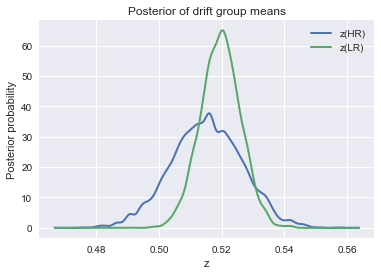

In [100]:
z_HR, z_LR = pad_session2_model.nodes_db.node[['z(HR)','z(LR)']]
hddm.analyze.plot_posterior_nodes([z_HR, z_LR])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_z(HR > LR) = ", (z_HR.trace() > z_LR.trace()).mean())
print ("P_z(LR > HR) = ", (z_LR.trace() > z_HR.trace()).mean())

P_t(HR > LR) =  0.354777777778
P_t(LR > HR) =  0.645222222222


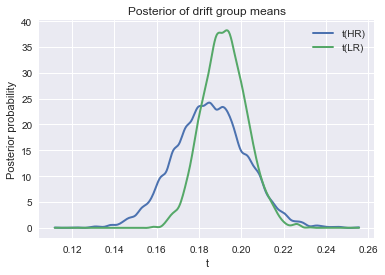

In [101]:
t_HR, t_LR = pad_session2_model.nodes_db.node[['t(HR)','t(LR)']]
hddm.analyze.plot_posterior_nodes([t_HR, t_LR])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift group means')

print ("P_t(HR > LR) = ", (t_HR.trace() > t_LR.trace()).mean())
print ("P_t(LR > HR) = ", (t_LR.trace() > t_HR.trace()).mean())

**Building a second model without group for regressions**

In [102]:
pad_model2_nogrp = hddm.HDDMStimCoding(pad_fudata_ddm, include='z', stim_col='stim', split_param='v')
pad_model2_nogrp.find_starting_values()
pad_model2_nogrp.sample(10000, burn=1000)

 [-----------------100%-----------------] 10001 of 10000 complete in 1349.4 sec

In [103]:
pad_model2_nogrp.dic_info

{'DIC': 4314.3250520606634,
 'deviance': 4107.388083723039,
 'pD': 206.93696833762442}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


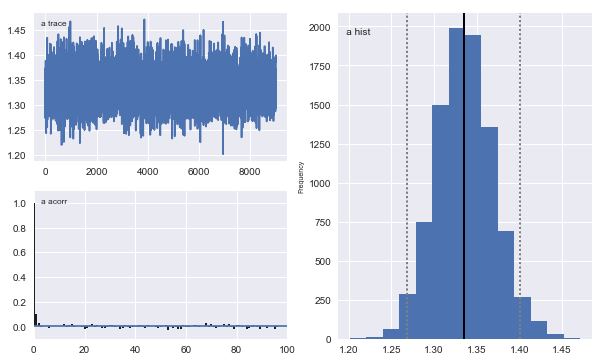

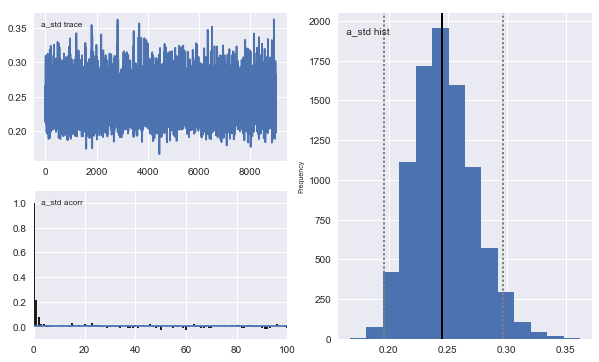

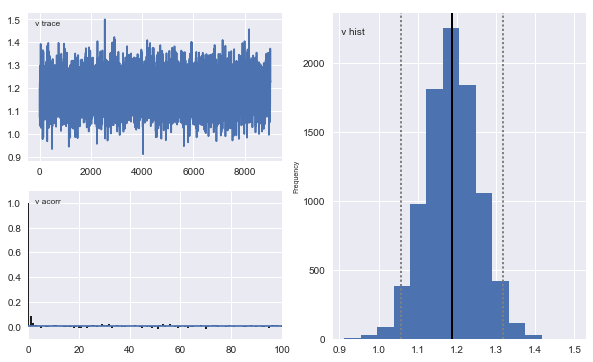

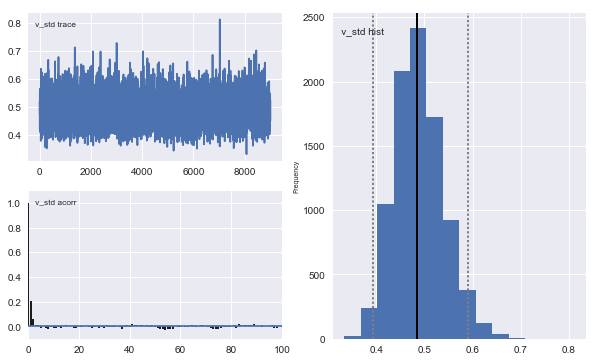

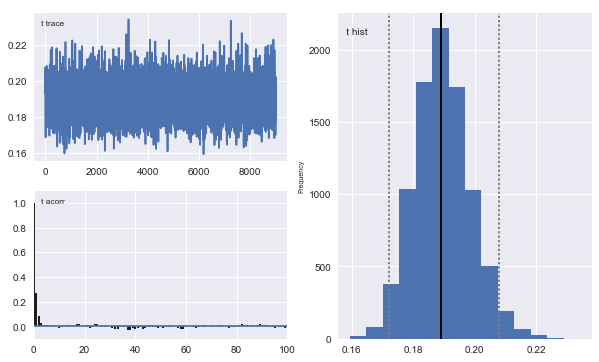

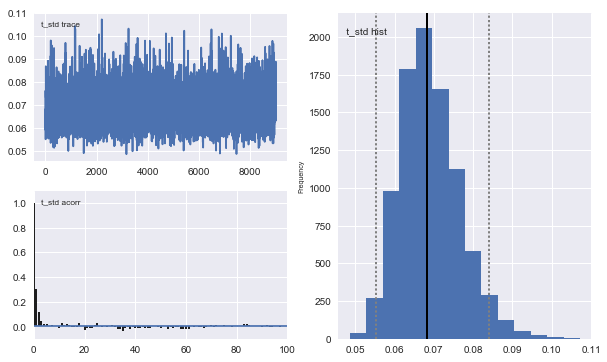

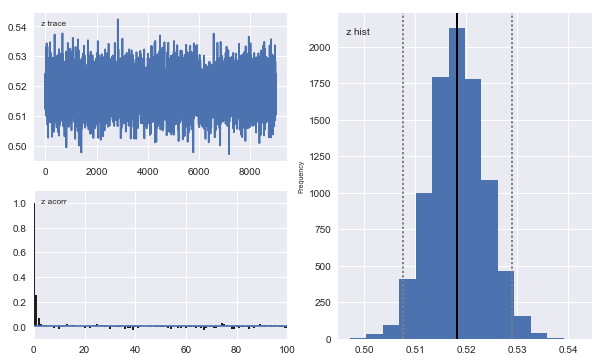

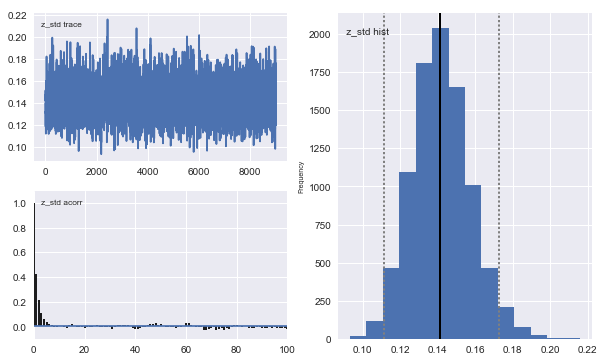

In [104]:
pad_model2_nogrp.plot_posteriors()

Get subject means

In [105]:
stats = pad_model2_nogrp.gen_stats()
stats.to_csv(path2data + 'pad_session2_modelstats_nogrp.csv')
stats = pd.read_csv(path2data + 'pad_session2_modelstats_nogrp.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.336021  0.033792  1.272378  1.313039  1.335208  1.358257   
1       a_std  0.246923  0.025972  0.202324  0.228477  0.245013  0.263342   
2  a_subj.200  1.814184  0.064432  1.691965  1.770173  1.812683  1.857004   
3  a_subj.201  1.092498  0.039184  1.018977  1.065428  1.091654  1.118229   
4  a_subj.205  0.979873  0.034597  0.915860  0.956106  0.979065  1.002665   

      97.5q    mc err  
0  1.405179  0.000388  
1  0.303548  0.000357  
2  1.946074  0.000805  
3  1.171419  0.000524  
4  1.050437  0.000553

In [106]:
def get_param(item):
    '''Returns the parameter from the genstats() data'''
    if len(item) == 10:
        param = item[0]
    else:
        param = np.nan
    return(param)
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 10:
        sub_id = item[7:10]
    else:
        sub_id = np.nan
    return(sub_id)

In [107]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.814184     a      200           0      0  1826           0   
1  v_subj.200  0.517654     v      200           0      0  1826           0   
2  t_subj.200  0.100980     t      200           0      0  1826           0   
3  z_subj.200  0.528569     z      200           0      0  1826           0   
4  a_subj.201  1.092498     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [108]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  0.517654      200           0      0  1826           0   
1  v_subj.201  1.225190      201         200    200  1178           1   
2  v_subj.205  0.942426      205         600    600   540           0   
3  v_subj.208  1.915569      208        1000   1000  1010           0   
4  v_subj.210  1.505169      210        1401   1401   868           1   
5  v_subj.212  1.539800      212        1800   1800   357           0   
6  v_subj.214  2.228216      214        2200   2200   327           1   
7  v_subj.216  1.936662      216        2600   2600   481           0   
8  v_subj.217  1.343066      217        2800   2800   632           1   
9  v_subj.226  1.099615      226        4000   4000   575           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         m    ...               0     79   
4           0   long         c    ...               0     76   
5           0  short         c    ...               0     76   
6           0  short         m    ...               0     80   
7           1  short         c    ...               0     80   
8           0  short         c    ...               0     78   
9           1  short         c    ...               0     79   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.123570             0.618065            0.127636   
4           -0.028894             0.639226           -0.171767   
5            0.115270             0.244212            0.034607   
6           -0.220095             1.111220           -0.185077   
7            0.157950             0.617698            0.221546   
8           -0.257763             0.764642           -0.299311   
9            0.097587             0.415007            0.114169   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.814184  0.528569  0.100980  
1            0.797025      -0.116439  1.092498  0.522492  0.146871  
2            0.746675       0.159823  0.979873  0.461489  0.137351  
3            0.571334      -0.013872  1.257241  0.463840  0.167351  
4            0.591661       0.307354  1.581719  0.544126  0.143603  
5            0.286945       0.151136  1.425210  0.512258  0.128200  
6            1.102725      -0.041101  0.941527  0.495943  0.153436  
7            0.541882      -0.149269  1.305550  0.531395  0.281315  
8            0.824074       0.088808  1.663368  0.577062  0.257076  
9            0.421730      -0.035776  1.248901  0.576930  0.267664  

[10 rows x 40 columns]

In [109]:
reward_stats.to_csv(path2data + 'pad_session2_hddm_params.csv')

### Relationships between HDDM variables & signal detection variables

In [184]:
# this is the model without group included
reward_stats = pd.read_csv(path2data + 'pad_session2_hddm_params.csv')
reward_stats.groupby('group').subject.nunique()

group
HR    14
LR    33
Name: subject, dtype: int64


	Pearson's product-moment correlation

data:  reward_stats$mean_v and reward_stats$dis_adjst_all_total
t = 2.0921, df = 45, p-value = 0.0421
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.01155525 0.53883119
sample estimates:
      cor 
0.2977341 



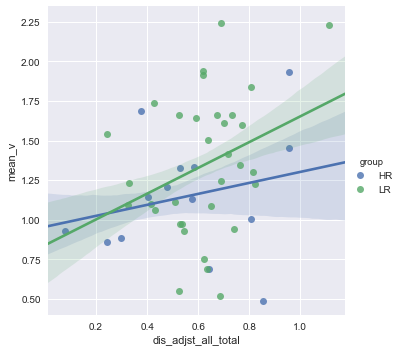

In [186]:
# disc and drift, nice

corr_param = sns.lmplot(y='mean_v', x='dis_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_v, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a and reward_stats$dis_adjst_all_total
t = 0.37694, df = 45, p-value = 0.708
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2348481  0.3378265
sample estimates:
       cor 
0.05610229 



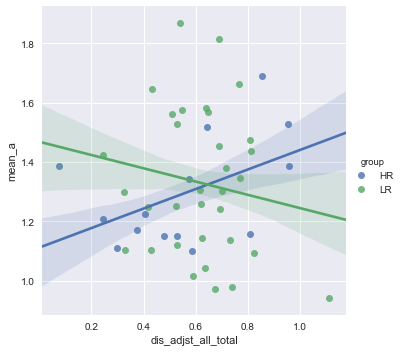

In [188]:
# disc and threshold

corr_param = sns.lmplot(y='mean_a', x='dis_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_a, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z and reward_stats$dis_adjst_all_total
t = -1.3252, df = 45, p-value = 0.1918
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4556134  0.0988658
sample estimates:
       cor 
-0.1938033 



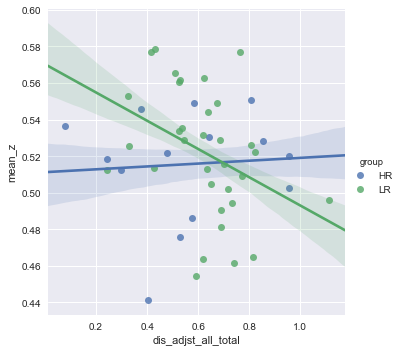

In [189]:
# disc and starting point

corr_param = sns.lmplot(y='mean_z', x='dis_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R disc_v.cor <- cor.test(reward_stats$mean_z, reward_stats$dis_adjst_all_total)
%R print(disc_v.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_z and reward_stats$RB_adjst_all_total
t = -1.4177, df = 45, p-value = 0.1632
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.46624913  0.08547549
sample estimates:
       cor 
-0.2067666 



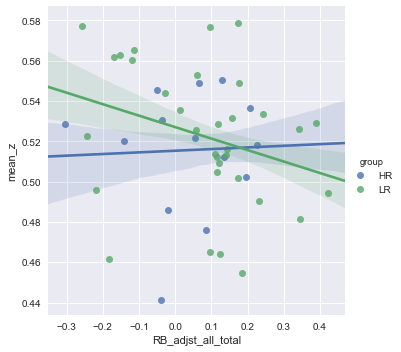

In [190]:
# RB & z, surprised there's nothing here

corr_param = sns.lmplot(y='mean_z', x='RB_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_z.cor <- cor.test(reward_stats$mean_z, reward_stats$RB_adjst_all_total)
%R print(rb_z.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_a and reward_stats$RB_adjst_all_total
t = 0.10651, df = 45, p-value = 0.9156
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2725330  0.3016678
sample estimates:
      cor 
0.0158763 



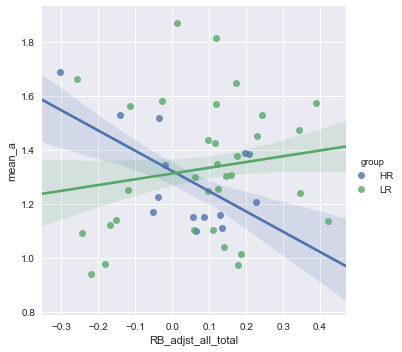

In [191]:
# RB & threshold

corr_param = sns.lmplot(y='mean_a', x='RB_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_a, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)


	Pearson's product-moment correlation

data:  reward_stats$mean_v and reward_stats$RB_adjst_all_total
t = 1.2674, df = 45, p-value = 0.2115
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1072370  0.4488829
sample estimates:
      cor 
0.1856468 



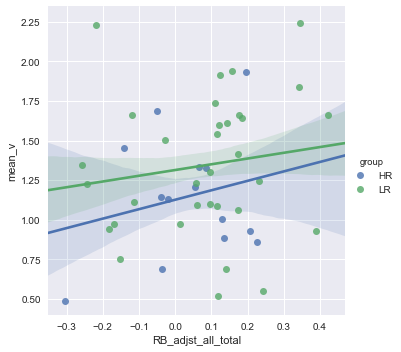

In [192]:
# RB & drift

corr_param = sns.lmplot(y='mean_v', x='RB_adjst_all_total', hue = 'group', hue_order = ['HR','LR'],data=reward_stats, ci=68)

%Rpush reward_stats
%R rb_a.cor <- cor.test(reward_stats$mean_v, reward_stats$RB_adjst_all_total)
%R print(rb_a.cor)

TODO: Regression predicting discriminability

TODO: Regression predicting response bias

**Build third model of just the low risk kids**

In [116]:
LR_pad_data_ddm_t2 = pad_fudata_ddm.loc[pad_fudata_ddm.group == 'LR']

In [117]:
pad_model_LR = hddm.HDDMStimCoding(LR_pad_data_ddm_t2, include='z', stim_col='stim', split_param='v')
pad_model_LR.find_starting_values()
pad_model_LR.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1153.4 sec

In [118]:
pad_model_LR.dic_info

{'DIC': 3243.1663496752972,
 'deviance': 3085.6622723978917,
 'pD': 157.50407727740549}

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


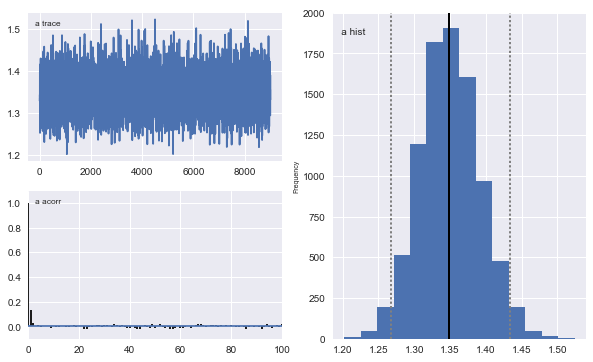

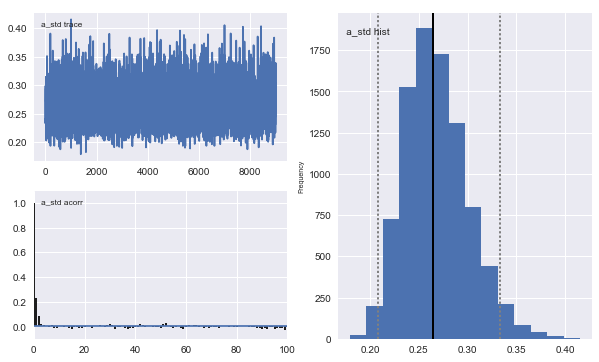

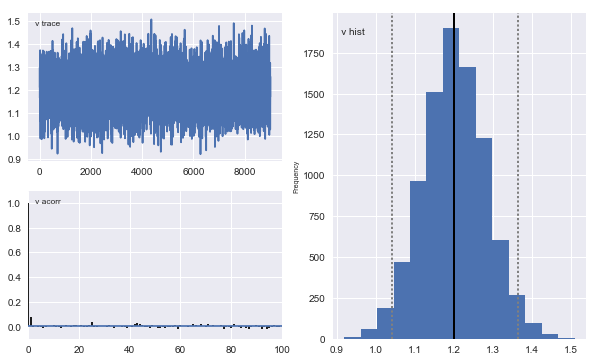

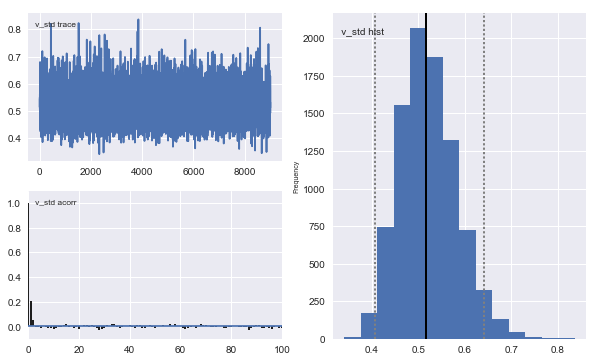

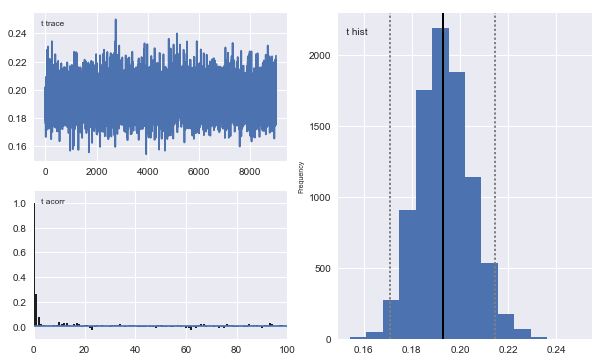

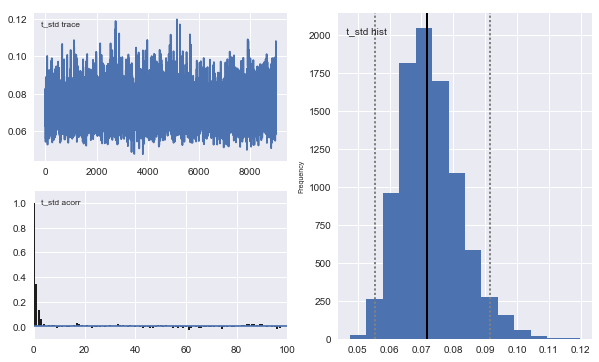

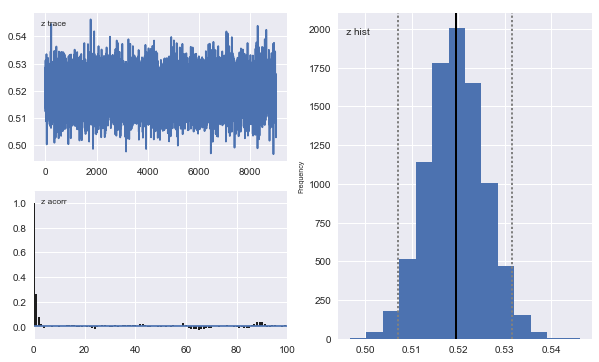

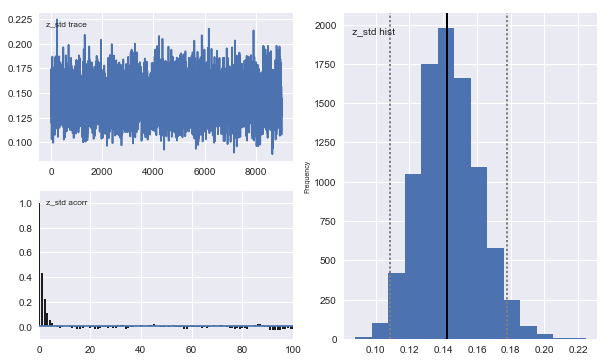

In [119]:
pad_model_LR.plot_posteriors()

In [120]:
stats = pad_model_LR.gen_stats()
stats.to_csv(path2data + 'pad_session2_modelstats_LR.csv')
stats = pd.read_csv(path2data + 'pad_session2_modelstats_LR.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.349913  0.042185  1.269049  1.321540  1.348530  1.377172   
1       a_std  0.268004  0.032639  0.213068  0.244651  0.264738  0.288314   
2  a_subj.200  1.819387  0.065732  1.696306  1.774595  1.818245  1.862549   
3  a_subj.201  1.091640  0.039751  1.016897  1.064582  1.090288  1.118231   
4  a_subj.205  0.979145  0.034305  0.916140  0.955194  0.978233  1.001781   

      97.5q    mc err  
0  1.435866  0.000514  
1  0.340982  0.000424  
2  1.951940  0.000840  
3  1.173473  0.000546  
4  1.050934  0.000480

In [121]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.819387     a      200           0      0  1826           0   
1  v_subj.200  0.514414     v      200           0      0  1826           0   
2  t_subj.200  0.100181     t      200           0      0  1826           0   
3  z_subj.200  0.529039     z      200           0      0  1826           0   
4  a_subj.201  1.091640     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [122]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  0.514414      200           0      0  1826           0   
1  v_subj.201  1.229228      201         200    200  1178           1   
2  v_subj.205  0.939840      205         600    600   540           0   
3  v_subj.208  1.928266      208        1000   1000  1010           0   
4  v_subj.210  1.512315      210        1401   1401   868           1   
5  v_subj.212  1.545354      212        1800   1800   357           0   
6  v_subj.214  2.245660      214        2200   2200   327           1   
7  v_subj.216  1.946766      216        2600   2600   481           0   
8  v_subj.217  1.347255      217        2800   2800   632           1   
9  v_subj.226  1.101578      226        4000   4000   575           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         m    ...               0     79   
4           0   long         c    ...               0     76   
5           0  short         c    ...               0     76   
6           0  short         m    ...               0     80   
7           1  short         c    ...               0     80   
8           0  short         c    ...               0     78   
9           1  short         c    ...               0     79   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.123570             0.618065            0.127636   
4           -0.028894             0.639226           -0.171767   
5            0.115270             0.244212            0.034607   
6           -0.220095             1.111220           -0.185077   
7            0.157950             0.617698            0.221546   
8           -0.257763             0.764642           -0.299311   
9            0.097587             0.415007            0.114169   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.819387  0.529039  0.100181  
1            0.797025      -0.116439  1.091640  0.522305  0.146949  
2            0.746675       0.159823  0.979145  0.462247  0.137339  
3            0.571334      -0.013872  1.260084  0.464612  0.167175  
4            0.591661       0.307354  1.586793  0.544490  0.143536  
5            0.286945       0.151136  1.427127  0.512770  0.128169  
6            1.102725      -0.041101  0.941203  0.496574  0.153480  
7            0.541882      -0.149269  1.307334  0.531741  0.281380  
8            0.824074       0.088808  1.665463  0.577722  0.257340  
9            0.421730      -0.035776  1.249891  0.578080  0.267695  

[10 rows x 40 columns]

In [123]:
reward_stats.to_csv(path2data + 'pad_session2_hddm_params_LR.csv')

## PAD HDDM Stability

In [135]:
# Just low risk to start
sess1_params = pd.read_csv(path2data + 'pad_session1_hddm_params_LR.csv')
sess2_params = pd.read_csv(path2data + 'pad_session2_hddm_params_LR.csv')

In [136]:
sess2_params.rename(columns={'mean_v':'mean_v2', 'mean_a':'mean_a2', 'mean_z':'mean_z2', 
                    'mean_t':'mean_t2'}, inplace=True)

In [137]:
all_params = pd.merge(sess1_params[['subj_idx','mean_v', 'mean_z', 'mean_a', 'mean_t']], \
                      sess2_params, on= 'subj_idx')


	Pearson's product-moment correlation

data:  all_params$mean_v and all_params$mean_v2
t = 2.2087, df = 31, p-value = 0.03472
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02912227 0.63204136
sample estimates:
      cor 
0.3687446 



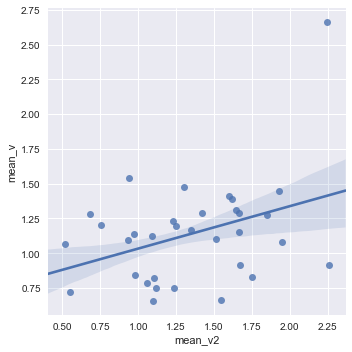

In [139]:
# drift rate correlation
corr_param = sns.lmplot(y='mean_v', \
                        x = 'mean_v2', data=all_params,ci=68, \
                        units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_v,all_params$mean_v2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_a and all_params$mean_a2
t = 2.5546, df = 31, p-value = 0.01576
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.08602672 0.66510742
sample estimates:
      cor 
0.4170196 



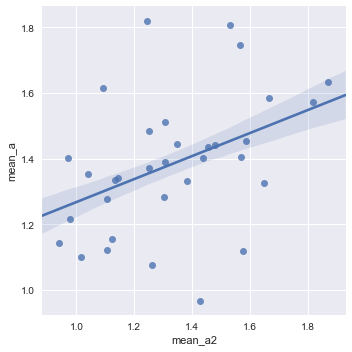

In [140]:
# threshold correlation
corr_param = sns.lmplot(y='mean_a', \
                        x = 'mean_a2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_a,all_params$mean_a2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_z and all_params$mean_z2
t = -1.5619, df = 31, p-value = 0.1285
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.56135600  0.08069094
sample estimates:
       cor 
-0.2701004 



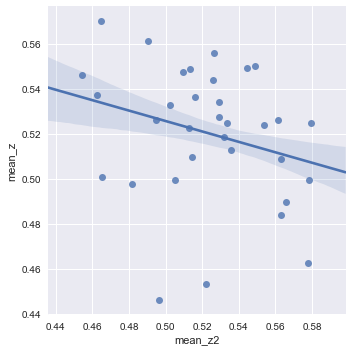

In [141]:
# Starting point bias correlation
# we got this trend in the first dataset, not sure what to make of it
corr_param = sns.lmplot(y='mean_z', \
                        x = 'mean_z2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_z,all_params$mean_z2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_t and all_params$mean_t2
t = 2.5633, df = 31, p-value = 0.01544
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0874309 0.6658956
sample estimates:
      cor 
0.4181877 



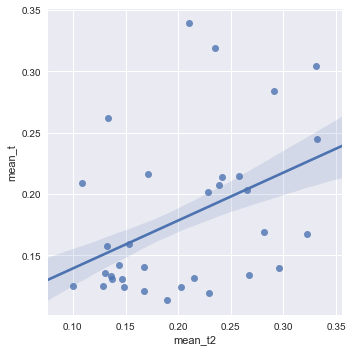

In [142]:
# non-decision time correlation
corr_param = sns.lmplot(y='mean_t', \
                        x = 'mean_t2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_t,all_params$mean_t2,method="pearson")
%R print (rl_disc.cor)

**Including HR now**

In [148]:
stats = pd.read_csv(path2data + 'pad_session1_modelstats_nogrp.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.343477  0.023804  1.298130  1.327318  1.343442  1.359305   
1       a_std  0.219618  0.018405  0.187158  0.206511  0.218256  0.231543   
2  a_subj.200  1.571469  0.058107  1.463760  1.531286  1.569380  1.609844   
3  a_subj.201  1.614169  0.062151  1.496273  1.571779  1.611770  1.655457   
4  a_subj.205  1.216487  0.048528  1.124011  1.182702  1.215326  1.248388   

      97.5q    mc err  
0  1.391292  0.000280  
1  0.259877  0.000245  
2  1.690144  0.000862  
3  1.740387  0.000918  
4  1.316467  0.000709

In [149]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.571469     a      200           0      0  1826           0   
1  v_subj.200  1.060361     v      200           0      0  1826           0   
2  t_subj.200  0.124940     t      200           0      0  1826           0   
3  z_subj.200  0.534382     z      200           0      0  1826           0   
4  a_subj.201  1.614169     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [150]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  1.060361      200           0      0  1826           0   
1  v_subj.201  1.226253      201         200    200  1178           1   
2  v_subj.205  1.530838      205         600    600   540           0   
3  v_subj.206  1.139419      206         800    800   717           1   
4  v_subj.208  1.436954      208        1000   1000  1010           0   
5  v_subj.209  1.192994      209        1200   1200   570           0   
6  v_subj.210  1.097405      210        1401   1401   868           1   
7  v_subj.211  0.893650      211        1600   1600  1086           0   
8  v_subj.212  0.659173      212        1800   1800   357           0   
9  v_subj.213  0.555212      213        2000   2000  1381           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         c    ...               0     79   
4           0  short         m    ...               0     79   
5           1  short         c    ...               0     75   
6           0   long         c    ...               0     76   
7           0  short         c    ...               0     72   
8           0  short         c    ...               0     76   
9           0  short         c    ...               0     76   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.203701             0.469714            0.154815   
4            0.123570             0.618065            0.127636   
5           -0.058603             0.530010           -0.189317   
6           -0.028894             0.639226           -0.171767   
7            0.076291             0.425833           -0.010325   
8            0.115270             0.244212            0.034607   
9           -0.065575             0.287424           -0.187716   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.571469  0.534382  0.124940  
1            0.797025      -0.116439  1.614169  0.454348  0.130584  
2            0.746675       0.159823  1.216487  0.538168  0.131075  
3            0.598513       0.086987  0.994347  0.495278  0.201773  
4            0.571334      -0.013872  1.074380  0.569986  0.140365  
5            0.509653       0.270919  1.172497  0.459633  0.149879  
6            0.591661       0.307354  1.452981  0.549459  0.141953  
7            0.417810       0.176222  1.200202  0.552359  0.117179  
8            0.286945       0.151136  0.965890  0.523378  0.124667  
9            0.255981       0.255977  1.317844  0.527313  0.126353  

[10 rows x 40 columns]

In [151]:
reward_stats.to_csv(path2data + 'pad_session1_hddm_params_nogrp.csv')

Get session 2 in a usable format

In [152]:
stats = pd.read_csv(path2data + 'pad_session2_modelstats_nogrp.csv')
stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
stats.head(5)

to_extract      mean       std      2.5q       25q       50q       75q  \
0           a  1.336021  0.033792  1.272378  1.313039  1.335208  1.358257   
1       a_std  0.246923  0.025972  0.202324  0.228477  0.245013  0.263342   
2  a_subj.200  1.814184  0.064432  1.691965  1.770173  1.812683  1.857004   
3  a_subj.201  1.092498  0.039184  1.018977  1.065428  1.091654  1.118229   
4  a_subj.205  0.979873  0.034597  0.915860  0.956106  0.979065  1.002665   

      97.5q    mc err  
0  1.405179  0.000388  
1  0.303548  0.000357  
2  1.946074  0.000805  
3  1.171419  0.000524  
4  1.050437  0.000553

In [153]:
# get column info and merge this with the behavioral data

reward_stats = stats[['to_extract', 'mean']]
reward_stats['param'] = reward_stats.to_extract.apply(get_param)
reward_stats['subj_idx'] = reward_stats.to_extract.apply(get_id)
pad_data_standard['subj_idx'] = pad_data_standard.subject.apply(lambda x: str(x))
reward_stats = pd.merge(reward_stats, pad_data_standard, on='subj_idx')
reward_stats.head()

to_extract      mean param subj_idx  Unnamed: 0  index    rt  did_reward  \
0  a_subj.200  1.814184     a      200           0      0  1826           0   
1  v_subj.200  0.517654     v      200           0      0  1826           0   
2  t_subj.200  0.100980     t      200           0      0  1826           0   
3  z_subj.200  0.528569     z      200           0      0  1826           0   
4  a_subj.201  1.092498     a      201         200    200  1178           1   

   little_due length       ...       outlier  mean_ln_rt    ln_std  \
0           0  short       ...             0    6.181892  0.484481   
1           0  short       ...             0    6.181892  0.484481   
2           0  short       ...             0    6.181892  0.484481   
3           0  short       ...             0    6.181892  0.484481   
4           0  short       ...             0    6.181892  0.484481   

   outlier_sub  rwdct  RB_adjst_all_total dis_adjst_all_total  \
0            0     79            0.119377            0.687306   
1            0     79            0.119377            0.687306   
2            0     79            0.119377            0.687306   
3            0     79            0.119377            0.687306   
4            0     79           -0.244699            0.822247   

  RB_adjst_all_block dis_adjst_all_block  RB_b2_minus_b1  
0           0.212326            0.613250       -0.212326  
1           0.212326            0.613250       -0.212326  
2           0.212326            0.613250       -0.212326  
3           0.212326            0.613250       -0.212326  
4          -0.178151            0.797025       -0.116439  

[5 rows x 38 columns]

In [154]:
# get the data into usable form 

reward_stats_v = reward_stats[reward_stats['param'] == 'v']
reward_stats_a = reward_stats[reward_stats['param'] == 'a']
reward_stats_z = reward_stats[reward_stats['param'] == 'z']
reward_stats_t = reward_stats[reward_stats['param'] == 't']
reward_stats_v.rename(columns={'mean':'mean_v'}, inplace = True)
reward_stats_a.rename(columns={'mean':'mean_a'}, inplace = True)
reward_stats_z.rename(columns={'mean':'mean_z'}, inplace = True)
reward_stats_t.rename(columns={'mean':'mean_t'}, inplace = True)
reward_stats = reward_stats_v.merge(reward_stats_a[['mean_a', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_z[['mean_z', 'subj_idx']], on = 'subj_idx')
reward_stats = reward_stats.merge(reward_stats_t[['mean_t', 'subj_idx']], on = 'subj_idx')
del reward_stats['param']
reward_stats.head(10)

to_extract    mean_v subj_idx  Unnamed: 0  index    rt  did_reward  \
0  v_subj.200  0.517654      200           0      0  1826           0   
1  v_subj.201  1.225190      201         200    200  1178           1   
2  v_subj.205  0.942426      205         600    600   540           0   
3  v_subj.208  1.915569      208        1000   1000  1010           0   
4  v_subj.210  1.505169      210        1401   1401   868           1   
5  v_subj.212  1.539800      212        1800   1800   357           0   
6  v_subj.214  2.228216      214        2200   2200   327           1   
7  v_subj.216  1.936662      216        2600   2600   481           0   
8  v_subj.217  1.343066      217        2800   2800   632           1   
9  v_subj.226  1.099615      226        4000   4000   575           0   

   little_due length key_press    ...     outlier_sub  rwdct  \
0           0  short         c    ...               0     79   
1           0  short         m    ...               0     79   
2           0  short         m    ...               0     76   
3           0  short         m    ...               0     79   
4           0   long         c    ...               0     76   
5           0  short         c    ...               0     76   
6           0  short         m    ...               0     80   
7           1  short         c    ...               0     80   
8           0  short         c    ...               0     78   
9           1  short         c    ...               0     79   

   RB_adjst_all_total  dis_adjst_all_total  RB_adjst_all_block  \
0            0.119377             0.687306            0.212326   
1           -0.244699             0.822247           -0.178151   
2           -0.181978             0.738841           -0.258124   
3            0.123570             0.618065            0.127636   
4           -0.028894             0.639226           -0.171767   
5            0.115270             0.244212            0.034607   
6           -0.220095             1.111220           -0.185077   
7            0.157950             0.617698            0.221546   
8           -0.257763             0.764642           -0.299311   
9            0.097587             0.415007            0.114169   

  dis_adjst_all_block RB_b2_minus_b1    mean_a    mean_z    mean_t  
0            0.613250      -0.212326  1.814184  0.528569  0.100980  
1            0.797025      -0.116439  1.092498  0.522492  0.146871  
2            0.746675       0.159823  0.979873  0.461489  0.137351  
3            0.571334      -0.013872  1.257241  0.463840  0.167351  
4            0.591661       0.307354  1.581719  0.544126  0.143603  
5            0.286945       0.151136  1.425210  0.512258  0.128200  
6            1.102725      -0.041101  0.941527  0.495943  0.153436  
7            0.541882      -0.149269  1.305550  0.531395  0.281315  
8            0.824074       0.088808  1.663368  0.577062  0.257076  
9            0.421730      -0.035776  1.248901  0.576930  0.267664  

[10 rows x 40 columns]

In [155]:
reward_stats.to_csv(path2data + 'pad_session2_hddm_params_nogrp.csv')

In [156]:
# Both groups included, this is from the model without group included

sess1_params = pd.read_csv(path2data + 'pad_session1_hddm_params_nogrp.csv')
sess2_params = pd.read_csv(path2data + 'pad_session2_hddm_params_nogrp.csv')

In [157]:
sess2_params.rename(columns={'mean_v':'mean_v2', 'mean_a':'mean_a2', 'mean_z':'mean_z2', 
                    'mean_t':'mean_t2'}, inplace=True)

In [158]:
all_params = pd.merge(sess1_params[['subj_idx','mean_v', 'mean_z', 'mean_a', 'mean_t']], \
                      sess2_params, on= 'subj_idx')


	Pearson's product-moment correlation

data:  all_params$mean_v and all_params$mean_v2
t = 2.5306, df = 45, p-value = 0.01495
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0732141 0.5812157
sample estimates:
    cor 
0.35296 



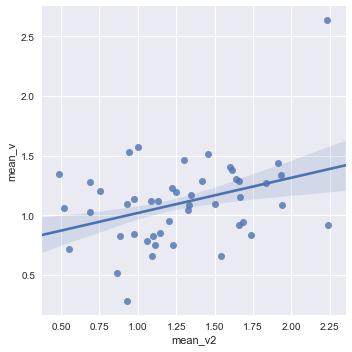

In [159]:
# drift rate correlation
corr_param = sns.lmplot(y='mean_v', \
                        x = 'mean_v2', data=all_params,ci=68, \
                        units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_v,all_params$mean_v2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_a and all_params$mean_a2
t = 3.2239, df = 45, p-value = 0.002355
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1667417 0.6406436
sample estimates:
      cor 
0.4331673 



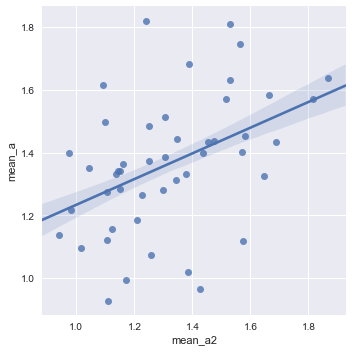

In [160]:
# threshold correlation
corr_param = sns.lmplot(y='mean_a', \
                        x = 'mean_a2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_a,all_params$mean_a2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_z and all_params$mean_z2
t = -1.4388, df = 45, p-value = 0.1571
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.46865931  0.08241312
sample estimates:
       cor 
-0.2097169 



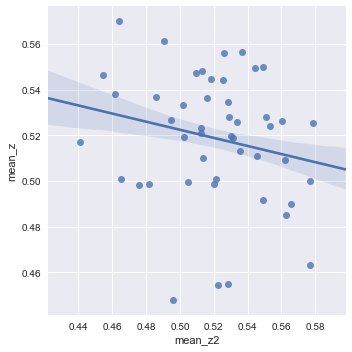

In [161]:
# Starting point bias correlation
# we got this trend in the first dataset, not sure what to make of it
corr_param = sns.lmplot(y='mean_z', \
                        x = 'mean_z2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_z,all_params$mean_z2,method="pearson")
%R print (rl_disc.cor)


	Pearson's product-moment correlation

data:  all_params$mean_t and all_params$mean_t2
t = 3.739, df = 45, p-value = 0.0005199
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2321531 0.6790858
sample estimates:
      cor 
0.4868624 



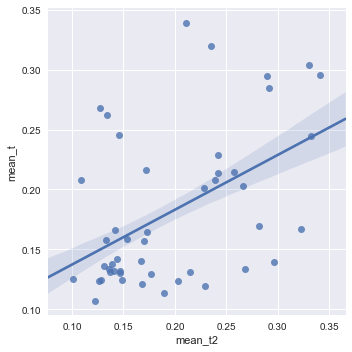

In [162]:
# non-decision time correlation
# I think it's strange that it's so strong here, yet there was nothing in the first group

corr_param = sns.lmplot(y='mean_t', \
                        x = 'mean_t2', data=all_params,ci=68, units = 'subj_idx')
%Rpush all_params
%R rl_disc.cor <- cor.test(all_params$mean_t,all_params$mean_t2,method="pearson")
%R print (rl_disc.cor)

**Group x Time x Parameter**

In [173]:
all_params2 = all_params[["subj_idx","mean_v","mean_v2","mean_a","mean_a2","mean_z",'mean_z2','mean_t','mean_t2']]
melted = pd.melt(all_params2, id_vars=["subj_idx"], 
                 var_name="parameter", value_name="value")

In [174]:
new = {'mean_a': "mean_a1", 'mean_v': "mean_v1",'mean_z':'mean_z1','mean_t':'mean_t1'}
melted['parameter'].replace(new, inplace=True)
melted['time'] = melted.parameter.apply(lambda x: x[6])
melted['parameter'] = melted.parameter.apply(lambda x: x[5])
melted.head()

subj_idx parameter     value time
0       200         v  1.060361    1
1       201         v  1.226253    1
2       205         v  1.530838    1
3       208         v  1.436954    1
4       210         v  1.097405    1

In [175]:
melted.tail()

subj_idx parameter     value time
371       806         t  0.289547    2
372       809         t  0.142210    2
373       815         t  0.172614    2
374       818         t  0.138600    2
375       819         t  0.140453    2

In [178]:
pad_data_standard['subj_idx'] = pad_data_standard.subject
melted = melted.merge(pad_data_standard[['subj_idx','group']], on='subj_idx')

In [179]:
melted.head()

subj_idx parameter     value time group
0       200         v  1.060361    1    LR
1       200         v  0.517654    2    LR
2       200         a  1.571469    1    LR
3       200         a  1.814184    2    LR
4       200         z  0.534382    1    LR

In [180]:
melted.tail()

subj_idx parameter     value time group
371       819         a  1.226487    2    HR
372       819         z  0.517227    1    HR
373       819         z  0.441145    2    HR
374       819         t  0.132164    1    HR
375       819         t  0.140453    2    HR

In [181]:
# not sure if this makes sense to do

%Rpush melted
%R rb.aov <- aov_ez("subj_idx", dv = "value", \
                                 data = melted, within = c("time","parameter"), \
                                 between = "group",anova_table=list(correction="GG", es = "pes"))
%R print(rb.aov)

Anova Table (Type 3 tests)

Response: value
                Effect          df  MSE          F  pes p.value
1                group       1, 45 0.07     3.55 +  .07     .07
2                 time       1, 45 0.04       2.44  .05     .13
3           group:time       1, 45 0.04       0.31 .007     .58
4            parameter 1.40, 62.86 0.16 306.81 ***  .87  <.0001
5      group:parameter 1.40, 62.86 0.16       1.19  .03     .30
6       time:parameter 1.45, 65.47 0.07     4.60 *  .09     .02
7 group:time:parameter 1.45, 65.47 0.07       0.35 .008     .64

Sphericity correction method: GG 


In [182]:
%R detach(package:lmerTest) # not a linear model error

%R library(lsmeans)
%R time_x_parameter.lsm <- lsmeans(rb.aov, ~ time*parameter)
%R print(time_x_parameter.lsm)
%R print(pairs(time_x_parameter.lsm))

 time parameter    lsmean         SE     df  lower.CL  upper.CL
 X1   a         1.3629465 0.03633927 319.13 1.2914517 1.4344413
 X2   a         1.3233418 0.03633927 319.13 1.2518470 1.3948366
 X1   t         0.1932669 0.03633927 319.13 0.1217721 0.2647618
 X2   t         0.2017318 0.03633927 319.13 0.1302370 0.2732266
 X1   v         1.0932255 0.03633927 319.13 1.0217307 1.1647203
 X2   v         1.2563106 0.03633927 319.13 1.1848158 1.3278055
 X1   z         0.5283960 0.03633927 319.13 0.4569011 0.5998908
 X2   z         0.5299721 0.03633927 319.13 0.4584773 0.6014669

Results are averaged over the levels of: group 
Confidence level used: 0.95 


 contrast        estimate         SE     df t.ratio p.value
 X1,a - X2,a  0.039604685 0.04181720 179.88   0.947  0.9809
 X1,a - X1,t  1.169679531 0.05248440 236.77  22.286  <.0001
 X1,a - X2,t  1.161214663 0.05273108 237.46  22.021  <.0001
 X1,a - X1,v  0.269720972 0.05248440 236.77   5.139  <.0001
 X1,a - X2,v  0.106635827 0.05273108 237.46   2.022  0.4691
 X1,a - X1,z  0.834550512 0.05248440 236.77  15.901  <.0001
 X1,a - X2,z  0.832974398 0.05273108 237.46  15.797  <.0001
 X2,a - X1,t  1.130074846 0.05273108 237.46  21.431  <.0001
 X2,a - X2,t  1.121609978 0.05248440 236.77  21.370  <.0001
 X2,a - X1,v  0.230116287 0.05273108 237.46   4.364  0.0005
 X2,a - X2,v  0.067031142 0.05248440 236.77   1.277  0.9065
 X2,a - X1,z  0.794945827 0.05273108 237.46  15.075  <.0001
 X2,a - X2,z  0.793369713 0.05248440 236.77  15.116  <.0001
 X1,t - X2,t -0.008464868 0.04181720 179.88  -0.202  1.0000
 X1,t - X1,v -0.899958559 0.05248440 236.77 -17.147  <.0001
 X1,t - X2,v -1.063043704 0.05273108 237

The notebook was getting unruly and difficulty to navigate, the below code allows you to freeze a cell and keep at at the top of the notebook. I used it for the cell with all of the links to the different sections at the top. It doesn't show up in the .html but that's fine.  
  
taken from: https://github.com/jupyter/notebook/issues/1116

In [201]:
%%javascript
if (!Jupyter.toolbar.actions.get('cellfreezer:freeze')) {
    Jupyter.toolbar.actions.register({
      icon: 'fa-thumb-tack',
      handler: function() {
        var cell = Jupyter.notebook.get_selected_cell().element[0];
        if (!cell.style.position) {
          cell.style.position = 'fixed';
          cell.style.top = '0px';
          cell.style.left = '0px';
          cell.style['z-index'] = 999;
          cell.style.background = 'rgba(50, 150, 255, 0.88)';
          cell.style.width = '50%';
        } else {
          cell.style.position = '';
          cell.style.top = '';
          cell.style.left = '';
          cell.style['z-index'] = '';
          cell.style.background = '';
          cell.style.width = '';
        }
      }
    }, 'freeze', 'cellfreezer');
    Jupyter.toolbar.add_buttons_group(['cellfreezer:freeze']);
    Jupyter.keyboard_manager.command_shortcuts.add_shortcut('q', 'cellfreezer:freeze');
}

<IPython.core.display.Javascript object>